README:  
Introcuction: This script is for figure 6 in fullscope analysis(RNA editing analysis)  
Author: Y0NEKO  
Time: 2024.04.10  

In [ ]:
#load package
.libPaths(c("/cluster/home/liuhengxin/software/miniconda3_2/envs/r-kernel/lib/R/library",
           "/cluster/home/liuhengxin/software/miniconda3/envs/r4.1.2/lib/R/library",
           "/cluster/home/liuhengxin/software/miniconda3_2/envs/Rsplot/lib/R/library"))
library(data.table)
library(qs)
library(GenomicRanges)
library(GenomicFeatures)
library(rtracklayer)
library(dplyr)
library(ggbio)
library(reshape2)
library(ggsci)
library(viridis)
library(ggpubr)
library(ggh4x)
library(ggtranscript)
library(khroma)
library(bambu)
library(ggdensity)
library(Seurat)
library(scCustomize)
library(ComplexUpset)
library(circlize)
library(randomcoloR)

In [ ]:
#load data
setwd("/cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/")
MySplit = function(str,sep, n){
  return(unlist(lapply(strsplit(str,sep),"[[",n)))
}
cellan = read.csv("../ref/cell_type_type20230220-macaque1-contour2_v1.csv")
cellan = unique(cellan[,c("subclass","class")])
areaan = read.csv("../ref/area_annotation.csv")
gtf = rtracklayer::import("ref/bambu_extended_annotations_novelname.gtf")
areaan = unique(areaan[c("L0","L3")])
colnames(areaan) = c("lobe","area")
areaan[areaan$area == "1/2",]$area = "1|2"

In [3]:
#isosigls = qread(file = "data/dtu_analysis/dtu_isoform_ls_fsraw_cor_24_09_04.qs")
isosigls = qread(file = "data/dtu_analysis/dtu_isoform_ls_fsraw_co.qs")
isosigi = isosigls$subcortical
length(unique(isosigi[isosigi$sig != "N",]$gene_id))

[1] 2262

In [61]:
fsraw.cor = qread("data/reads_full_anotation/main_data_read_total_annotation_delete_multiread_24_09_04.qs")
#fsraw.cor = fsraw.cor[fsraw.cor$layer %in% paste0("l",1:6),]
head(fsraw.cor)

readid                                                                                                               
1 00000033-e8ce-4144-8ded-93a772582329-14;st_ed:A:10616-11399;AD:A:adapterJ-adapterK;AP:A:Correct_739-763:+            
2 00000033-e8ce-4144-8ded-93a772582329-3;st_ed:A:1542-1993;AD:A:adapterD-adapterE;AP:A:Correct_413-432:+               
3 00000033-e8ce-4144-8ded-93a772582329-3;st_ed:A:1542-1993;AD:A:adapterD-adapterE;AP:A:Correct_413-432:+               
4 00000033-e8ce-4144-8ded-93a772582329-3;st_ed:A:1542-1993;AD:A:adapterD-adapterE;AP:A:Correct_413-432:+               
5 00000036-9da5-46f6-80c5-a6a0bee7474f-2;st_ed:A:646-1552;AD:A:adapterC-adapterD;AP:A:Correct_863-887:+                
6 0000009e-f52a-4eb5-97dd-4ad22c3acd50-4;st_ed:A:1918-2609;AD:A:adapterL-adapterN;AP:A:Jump|AD:A:no-split|ts-te:103-320
  origin_name cell_id cell_type_id subclass class transcript_id  gene_id x    
1 L-lv-v          NA  NA                          XM_005540610.2 NUCKS1  19690
2 L-cb-cb         NA  NA                          XM_005581643.2 MLLT3    7970
3 L-cb-cb         NA  NA                          XM_005581643.2 MLLT3    7970
4 L-cb-cb         NA  NA                          XM_005581643.2 MLLT3    7970
5 L-TEpv-l4       NA  NA                          GPX4-WeiLab-1  GPX4    37772
6 L-1|2-l5    996777  77           L4/5     GLU   XM_005582166.2 STXBP1  14185
  y     layer region lobe          subcortical readcount areatr    
1 62662 v     lv     NA            Ventricle    9933     Ventricle 
2 88627 cb    cb     NA            Cerebellum   1966     Cerebellum
3 88627 cb    cb     NA            Cerebellum   1966     Cerebellum
4 88627 cb    cb     NA            Cerebellum   1966     Cerebellum
5 84660 l4    TEpv   temporal      Cortex       6884     Cortex    
6 29617 l5    1|2    somatosensory Cortex      56275     Cortex

In [62]:
#fsrawdp = qread("data/reads_full_anotation/main_data_read_total_annotation_dedup_24_09_04.qs")
longbed = qread("ref/long_read_mapping_total_rawnano_total_fil_24_11_12.qs")

In [6]:
#transtls = qread("data/reads_full_anotation/read_trans_stat_list_dedup_fsrawdp_24_09_04.qs")
transtls = qread("data/reads_full_anotation/read_trans_stat_list_dedup_fsrawcor_24_09_04.qs")

In [15]:
datas5 = list()

In [4]:
theme_presentation<- function(base_size = 16, base_family = "") {
  # Starts with theme_grey and then modify some parts
  theme_bw(base_size = base_size, base_family = base_family) %+replace%
    theme(
      strip.background = element_blank(),
      strip.text.x = element_text(size=16,colour="white"),
      strip.text.y = element_text(size=16,colour="white"),
      axis.text.x = element_blank(),
      axis.text.y = element_blank(),
      axis.ticks =  element_blank(), 
      axis.title.x= element_blank(),
      axis.title.y= element_blank(),
      panel.background = element_rect(fill="black"), 
      panel.border =element_blank(),  
      panel.grid.major = element_blank(), 
      panel.grid.minor = element_blank(), 
      panel.margin = unit(1.0, "lines"), 
      plot.background = element_rect(fill="black"), 
      plot.title =element_text(size=16,colour="white"), 
      # plot.margin = unit(c(1,  1, 1, 1), "lines"),
      legend.background=element_rect(fill='black'),
      legend.title=element_text(size=12,colour="white"),
      legend.text=element_text(size=12,colour="white"),
      legend.key = element_rect( fill = 'black'),
      # legend.key.size = unit(c(0, 0), "lines"),
      axis.line.x = element_blank(),
      axis.line.y = element_blank()
    )
}


## Spatial annotation

In [ ]:
refpos = unique(fsraw.cor[,c("x","y","subcortical","region")])
reflabel = refpos %>% group_by(subcortical) %>% summarise(xmid = median(x), ymid = median(y))

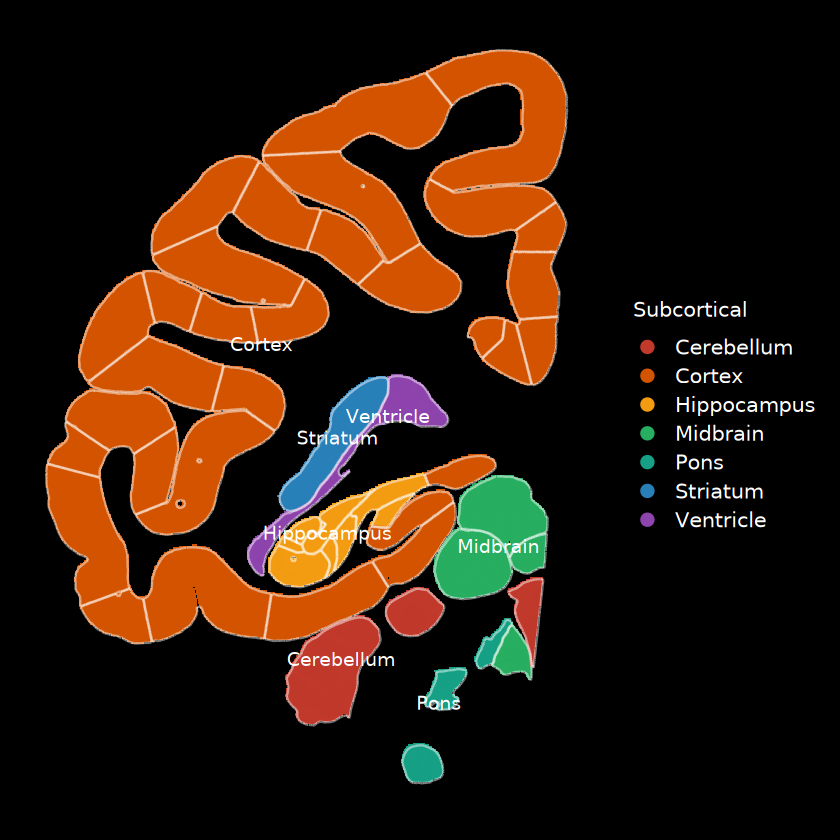

In [342]:
raster.dpi=c(512, 512)
library(khroma)
parea = ggplot() +
    scattermore::geom_scattermore(
      data = refpos,
      aes(x, y, color = subcortical),
      pixels = raster.dpi,
      pointsize = 1
    ) +
    # geom_point(data = refpos,
    #            aes(x, y, color = subcortical),
    #            size = 0.01) + 
    geom_segment(data = edgesdf, aes(x = x1, y = y1, xend = x2, yend = y2),
                 size = 0.5,color = "white",alpha = 0.5) + 
    geom_text(data = reflabel, aes(y = ymid, x = xmid, label= subcortical),
              color = "white") +
    scale_color_flatui() +
    theme_presentation() +
    guides(color = guide_legend(override.aes = list(size=4),
                                title = "Subcortical")) +
    # theme(legend.title = element_blank()) +
    scale_y_reverse() + scale_x_reverse()
parea

In [345]:
ggexport(parea,filename = "result/figure6_other_cmp/subcortical_annotation_spatial_24_11_27.pdf",width = 5,height = 5)

file saved to result/figure6_other_cmp/subcortical_annotation_spatial_24_11_27.pdf



## Case Plot function

In [66]:
#case plot
BuildPlotBed = function(npclf,nanobed,groupname,geneex,sigtr = NULL){
    readgroup = npclf[npclf$gene_id == geneex,]
    # readgroup = readgroup[readgroup$arealayer %in% paste0("l",1:6),]
    readgroup = unique(readgroup[c("readid","transcript_id","gene_id",
                                   groupname)])
    # readgroup = readgroup %>% group_by(readid) %>% 
    #   mutate(transgroup = 
    #            paste(unique(transcript_id)[order(unique(transcript_id))],
    #                              collapse = "|"))
    readgrt = nanobed[nanobed$name %in% readgroup$readid,]
    readgrt$group = readgroup[match(readgrt$name,
                                    readgroup$readid),
                              groupname]
    # readgrt$transcript_id = readgroup[match(readgrt$name,readgroup$readid),
    #                                   "transcript_id"]
    # readgrt$transgroup = readgroup[match(readgrt$name,readgroup$readid),
    #                                   "transgroup"]
    
    grtdfl = as.data.frame(readgrt)
    colnames(grtdfl)[ncol(grtdfl)] = "group"
    colnames(grtdfl)[6] = "readid"
    grtdfl = merge(grtdfl,readgroup[c("readid",
                              "transcript_id")],
          by = "readid")
    grtdfl = grtdfl[order(grtdfl$transcript_id,
                          grtdfl$start,grtdfl$end),]
    grtdfl = grtdfl[!is.na(grtdfl$group) &
                      grtdfl$group != "",]
    grtdfl
    grtdfl$readord = paste0(grtdfl$transcript_id,"-",grtdfl$readid)
    grtdfl = grtdfl %>% group_by(group) %>% 
      mutate(orid = as.numeric(factor(readord,
                                      levels = unique(readord)))) %>%
      mutate(oridnorm = orid/max(orid))
    grtdfl$sig = "black"
    grtdfl[grtdfl$group %in% sigtr, "sig"] = "red"
    return(grtdfl)
}
IsoformReadPlot = function(gtfp, grtdfl, geneex, onlyhub = T,mycolor = NULL){
    library(randomcoloR)
    library(ggbio)
    library(ggtranscript)
    tartrans = gtfp[which(gtfp$gene_id == geneex),]
    tartrans = as.data.frame(tartrans)
    tartrans = tartrans[tartrans$type == "exon",]
    tartrans = tartrans[order(tartrans$transcript_id),]
    tartrans$orid = as.numeric(factor(tartrans$transcript_id,levels = unique(tartrans$transcript_id)))
    tartrans$group = NA
    if(onlyhub){
      grtdfl = grtdfl %>% group_by(readid) %>% filter(length(unique(transcript_id)) == 1)
      grtdfl$readord = paste0(grtdfl$transcript_id,"-",grtdfl$readid)
      grtdfl = grtdfl %>% group_by(group) %>% 
        mutate(orid = as.numeric(factor(readord,
                                        levels = unique(readord)))) %>%
        mutate(oridnorm = orid/max(orid))
      tartrans = tartrans[tartrans$transcript_id %in% grtdfl$transcript_id,]
    }
    # tartrans = merge(tartrans,unique(grtdfl[c("transcript_id",
    #                                           "transgroup")]),
    #                  by = "transcript_id")
    tartranstx = tartrans %>% group_by(transcript_id,orid) %>% 
      summarise(start = min(start),end = max(end))
    tartranstx$group = NA
    mylim = c(min(tartranstx$start)-1000,max(tartranstx$end)+1000)
    library(ggh4x)
    
    #facetcol = list()
    #facetcoldf = unique(grtdfl[c("group","sig")])
    #facetcoldf = facetcoldf[order(facetcoldf$group,decreasing = F),]
    #for (i in 1:nrow(facetcoldf)) {
    #  facetcol[[i]] = element_text(color = facetcoldf[i,]$sig)
    #}
    #facetcol[[nrow(facetcoldf)+1]] = element_text(color = "black")
    grtdflin = to_intron(grtdfl,
                     "readord")
    no_of_colors = length(unique(grtdfl$transcript_id)) 
    colorful_palette = distinctColorPalette(no_of_colors) 
    names(colorful_palette) = unique(grtdfl$transcript_id)
    if(!is.null(mycolor)){
        colorful_palette = mycolor
    }

    
    pc = ggplot(grtdfl,aes(x = start,xend = end,
                      y = orid,
                      yend = orid,
                      fill = transcript_id,color = transcript_id)) +
      geom_segment(size = 0.5) +
      geom_segment(data = grtdflin,
                   aes(x = start,xend = end,
                       y = orid,
                       yend = orid),
                   size = 0.03,alpha = 0.5,color = "grey") +
      geom_range(data = tartrans,
                 aes(xstart = start,xend = end,
                     y = orid,
                     fill = transcript_id,color = transcript_id),
                 size = 0.2) +
      geom_intron(data = to_intron(tartrans,
                                   "transcript_id"),
                  aes(xstart = start,xend = end,strand = strand),
                  size = 0.2,
                  arrow.min.intron.length = 200,
                  arrow = arrow(length=unit(0.3,"cm"))) +
      geom_text(data = tartranstx,
                aes(x = (start + end) / 2,y = orid,
                    label = transcript_id),
                size = 3, vjust = -0.1, color = "black") +
     # facet_grid2(group~.,scales = "free",
     #             strip = strip_themed(
     #               text_y = facetcol
    #            )) +
      facet_wrap(group~.,scales = "free",ncol = 1,strip.position = "top") +
      scale_x_continuous(limits = mylim)+
      scale_color_manual(values = colorful_palette) +
      scale_fill_manual(values = colorful_palette) +
      # scale_fill_discreterainbow() +
      theme_void() + 
      ggtitle(geneex) +
      theme(legend.position = "none",
            panel.spacing = unit(0,'lines'),
            strip.background = element_rect(fill = NA,color = NA),
           strip.placement = "outside",
           plot.title = element_text(hjust = 0.5))
    pc
    
    return(pc)
}

#spatial point plot
MarkerSpPlot = function(npclfdp.cell,npclfdp.cellb,geneex,edgesdf,mycolor = NULL,hubtrans = NULL){
    markdf = npclfdp.cell[npclfdp.cell$gene_id %in% geneex,]
    if(!is.null(hubtrans)){
        markdf = markdf[markdf$transcript_id %in% hubtrans,]
    }
    markdfb = npclfdp.cellb

    if(is.null(mycolor)){
        mycolor = distinctColorPalette(length(unique(markdf$transcript_id)))
    }
    
    pmkpti = ggplot() +
      scattermore::geom_scattermore(
        data = markdfb,
        aes(x,y),
        color = "white",
        # pixels = raster.dpi,
        pointsize = 0.01
      ) +
      geom_point(data = markdf,
                 aes(x,y,color = transcript_id,size = readnum)) + 
      scale_size(range = c(0.01,0.05)) +
      # facet_wrap(~gene_id,nrow = 2) +
      theme_void() + 
      scale_color_manual(values = mycolor) +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 20)) +
      guides(color = guide_legend(override.aes = list(size=10),
                                  nrow = 2),
            size = "none") +
      scale_y_reverse() + scale_x_reverse()
    pmkpti
    return(pmkpti)
}
  # selectedhub  = c("APOE","CALB1","NEFM","SCN1B","SMYD2","PLP1")
#fsraw.cor = fsraw[fsraw$layer %in% paste0("l",1:6),]
#
CasePlotTotalClass = function(fsraw,isosigi,gtf,geneex,hubtrans = NULL){
    transname = unique(isosigi[isosigi$gene_id %in% geneex,]$transcript_id)
    if(!is.null(hubtrans)){
        transname = hubtrans
    }
    mycolors = distinctColorPalette(length(transname))
    print(mycolors)
    names(mycolors) = transname
    grtdfl = BuildPlotBed(fsraw,longbed,'areatr',geneex,NULL)
    print(head(grtdfl))
    grtdfl = grtdfl[grtdfl$transcript_id %in% transname,]
    
    pci1 = IsoformReadPlot(gtf, grtdfl, geneex,onlyhub = F,mycolors)
    pci1
#ggexport(p0c1,filename = "processed/figures/f3/bambu_cell_case_NNvsNeuron_CDC42.pdf",
#           width = 6,height = 5)

    npcase1 = fsraw[fsraw$gene_id == geneex,]
    npcase1 = npcase1 %>% 
        group_by(areatr,chunk) %>%
        mutate(genecount = length(unique(readid))) %>% 
        filter(genecount > 10) %>%
        group_by(areatr,chunk,transcript_id) %>%
        summarise(count = length(unique(readid)),genecount = genecount[1])
    npcase1 = npcase1[npcase1$areatr != "",]
    npcase1 = npcase1[npcase1$transcript_id %in% transname,]
    npcase1$rate = npcase1$count/npcase1$genecount

    npcase1$transid = as.numeric(as.factor(npcase1$transcript_id))
    npcase1$cmpgroup = paste0(substr(npcase1$transid,1,1),
                            "-",npcase1$areatr)
    comparisons = list()
    classid = as.character(unique(npcase1$areatr))
    n = 1
    for(i in 1:length(classid)){
        for(j in (i+1):length(classid)){
            comparisons[[n]] = c(classid[i],classid[j])
            n = n + 1
        }
    }
    
    pci2 = ggbarplot(npcase1,
                    x = "areatr", y = "rate", 
                    fill = "areatr",size = 0.5,
                    width = 0.7,facet.by = "transcript_id",
                    add = c("mean_se")) +
        geom_jitter(data = npcase1,
                aes(x = areatr, y = rate),size = 0.3,
                    width = 0.25) +
        scale_fill_flatui() +
#        scale_fill_manual(values = mycolors) +
        stat_compare_means(label = "p.signif",hide.ns = T,method = "t.test",vjust = 0.7,
                           ref.group = ".all.") + 
        xlab("") + ylab("Isoform ratio") + labs(fill = "") +
        theme_pubr() + 
    theme(axis.text.x = element_blank(),
         axis.ticks.x = element_blank(),
          legend.position = "bottom")
    pci2

    pci3 = MarkerSpPlot(fsrawdp.cell,fsrawdp.cellb,geneex,edgesdf,mycolors,hubtrans)
    
    pci = ggarrange(ggarrange(pci1,pci2,widths = c(1.5,1),ncol = 1),pci3,nrow = 1)
    return(pci)
}


## Isoform diversity compare

In [9]:
subct.st = fsraw.cor %>% group_by(subcortical) %>% summarise(readnum = length(unique(readid)))
subct.st

subcortical readnum 
1 Cerebellum   4260997
2 Cortex      61836381
3 Hippocampus  2783850
4 Midbrain     3142746
5 Pons         1079095
6 Striatum     1575965
7 Ventricle    2161925

In [11]:
ReadIsoNumRandom = function(npclfglu,n = 500,mygroup){
    readids = unique(npclfglu$readid)
    readid1 = readids[sample(1:length(readids),n)]
    transt1 = npclfglu[npclfglu$readid %in% readid1,]
    transt1 = transt1[order(transt1$readid,transt1$gene_id,
                            transt1$transcript_id),]
    transt1 = transt1[!duplicated(transt1[c("readid","gene_id")]),]
    
    transt1 = transt1 %>% group_by(gene_id) %>% 
      summarise(transnum = length(unique(transcript_id)),
                readnum = length(unique(readid)))
    transt1f = transt1[transt1$readnum > 1,]
    median(transt1f$transnum)
    
    resdf = data.frame("mison" = mean(transt1f$transnum),
                       "isot" = sum(transt1$transnum),
                       "genet" = nrow(transt1),
                       "readnum" = n,
                       "group" = mygroup)
    
    return(resdf)
  }

groupanid = unique(fsraw.cor$subcortical)
  fsrawdpls = list()
for (i in 1:length(groupanid)) {
    fsrawdpls[[i]] = fsraw.cor[fsraw.cor$subcortical == groupanid[i],]
}
names(fsrawdpls) = groupanid
  
k = 100000
cellrdsto = NULL
for (i in 1:100) {
    print(i)
    for (j in 1:length(fsrawdpls)) {
      cellrdti = ReadIsoNumRandom(fsrawdpls[[j]],k,names(fsrawdpls)[j])
      cellrdsto = rbind(cellrdsto,cellrdti)
    }
}
qsave(cellrdsto,"result/figure6_other_cmp/bambu_subcortical_isoform_diversity_cmp_24_11_22.qs")


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100


In [5]:
cellrdsto = qread("result/figure6_other_cmp/bambu_subcortical_isoform_diversity_cmp_24_11_22.qs")

Warning message:
"The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


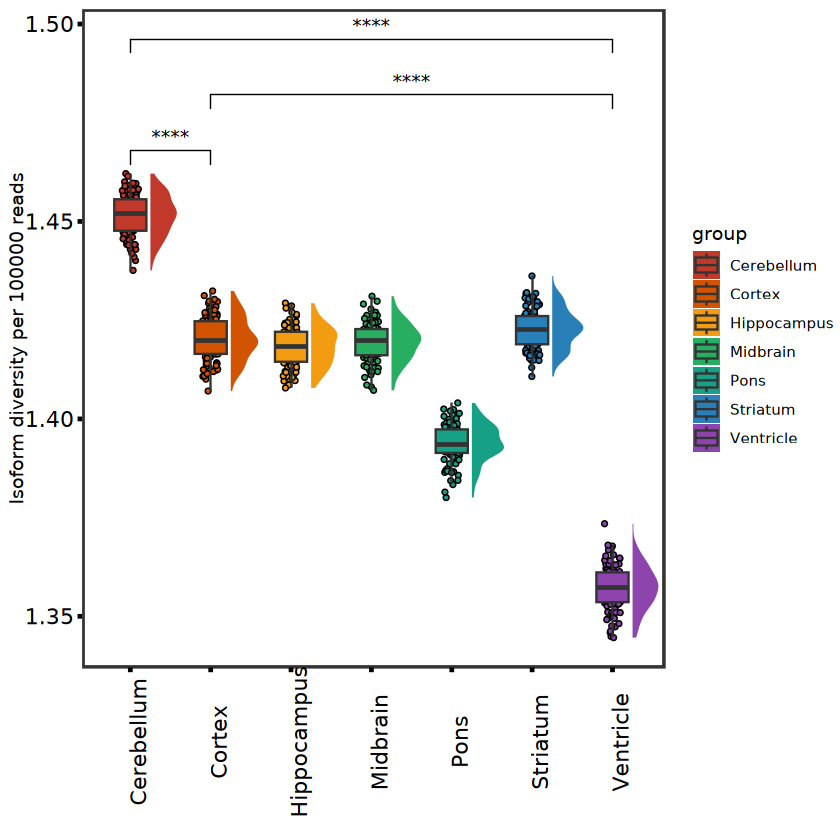

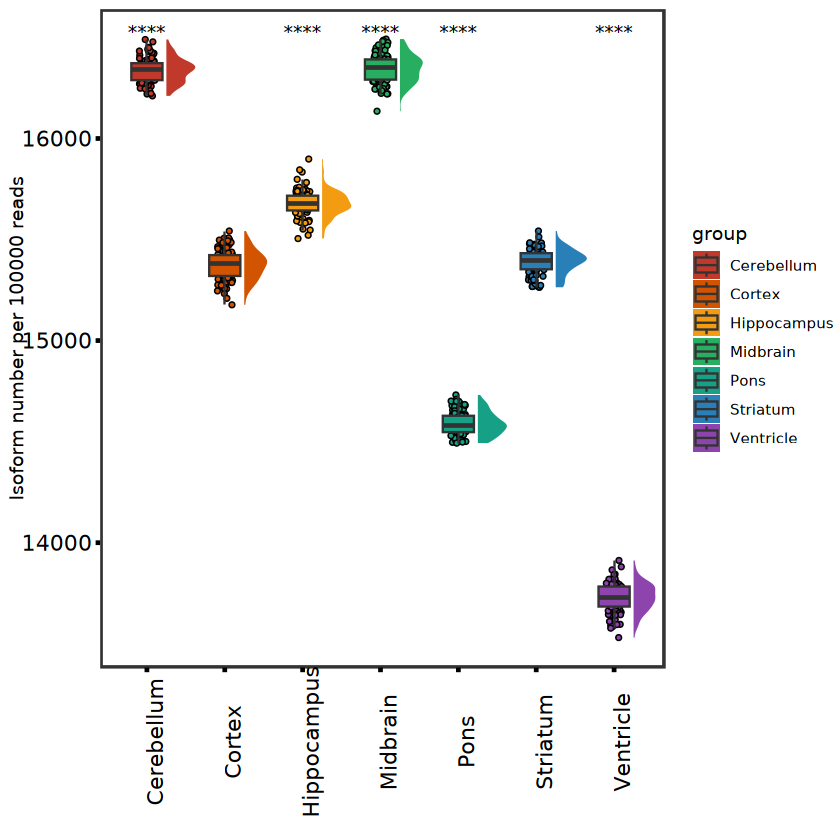

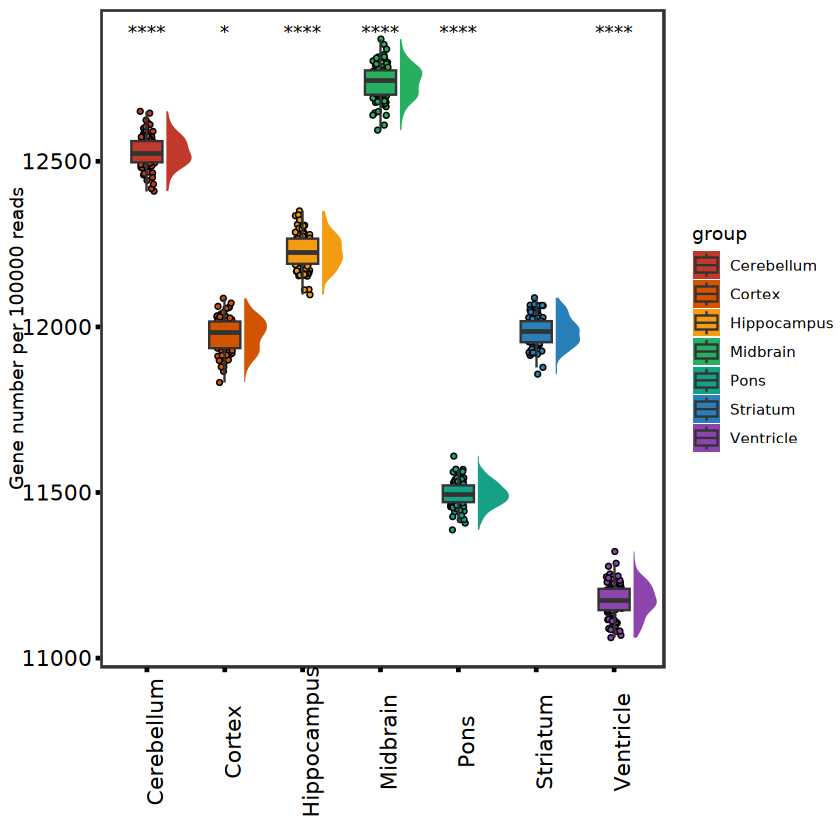

In [6]:
library(gghalves)
pt1 = ggplot(cellrdsto,aes(x = group, y = mison, fill = group))+
      geom_jitter(aes(fill = group),shape=21,size=1,width=0.1) +
      geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
      geom_boxplot(width=0.4,size=0.5, outlier.color =NA) +
      stat_compare_means(label = "p.signif", method = "t.test",hide.ns = T,comparison = list(c("Cerebellum","Cortex"),
                                                                                            c("Cortex","Ventricle"),
                                                                                            c("Cerebellum","Ventricle")))  +
      theme_bw()+
      theme(panel.grid = element_blank(),
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90),
        axis.text.y = element_text(color = "black",size = 13),
        axis.ticks = element_line(color="black",linewidth = 1)) +
      scale_fill_flatui() + ylab("Isoform diversity per 100000 reads") + xlab("")
  pt1
  
  pt2 = ggplot(cellrdsto,aes(x = group, y = isot, fill = group))+
      geom_jitter(aes(fill = group),shape=21,size=1,width=0.1) +
      geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
      geom_boxplot(width=0.4,size=0.5, outlier.color =NA) +
      stat_compare_means(label = "p.signif", method = "t.test",hide.ns = T,
                     ref.group = ".all.")  +
      theme_bw()+
      theme(panel.grid = element_blank(),
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90),
        axis.text.y = element_text(color = "black",size = 13),
        axis.ticks = element_line(color="black",linewidth = 1)) +
      scale_fill_flatui() + ylab("Isoform number per 100000 reads") + xlab("")
  pt2
  
  pt3 = ggplot(cellrdsto,aes(x = group, y = genet, fill = group))+
      geom_jitter(aes(fill = group),shape=21,size=1,width=0.1) +
      geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
      geom_boxplot(width=0.4,size=0.5, outlier.color =NA) +
      stat_compare_means(label = "p.signif", method = "t.test",hide.ns = T,
                     ref.group = ".all.")  +
      theme_bw()+
      theme(panel.grid = element_blank(),
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90),
        axis.text.y = element_text(color = "black",size = 13),
        axis.ticks = element_line(color="black",linewidth = 1)) +
      scale_fill_flatui() + ylab("Gene number per 100000 reads") + xlab("")
  pt3

In [ ]:
p1.2 = ggarrange(pt1,pt2,pt3,common.legend = T,ncol = 1)
p1.2
ggexport(p1.2,filename = "result/figure6_other_cmp/subcortical_isoform_diversity_cmp_box_25_04_11.pdf", width = 3,height = 12)

#  ggexport(pt2,filename = "processed/figures/f4/bambu_structure_isoform_diversity_abs_cmp_box.pdf",
#           width = 8,height = 4)
#  ggexport(pt3,filename = "processed/figures/f4/bambu_structure_gene_diversity_abs_cmp_box.pdf",
#           width = 8,height = 4)

file saved to result/figure6_other_cmp/subcortical_isoform_diversity_cmp_box_25_04_11.pdf



In [16]:
ra = 1000
fsrawdp$xid = as.integer(fsrawdp$x/(ra*2)) * ra * 2 + ra
fsrawdp$yid = as.integer(fsrawdp$y/(ra*2)) * ra * 2 + ra
fsrawdp$blockid = paste0(fsrawdp$xid,"_", fsrawdp$yid)
fsrawdp.bl = fsrawdp %>% group_by(subcortical,blockid) %>% 
    mutate(readnum = length(readid))
summary(fsrawdp.bl$readnum)

ERROR: Error in eval(expr, envir, enclos): object 'fsrawdp' not found


In [17]:
nrow(fsrawdp.bl)
fsrawdp.bl = fsrawdp.bl[fsrawdp.bl$readnum > 100000,]
nrow(fsrawdp.bl)
fsrawdp.blt = NULL
for(i in 1:1){
    fsrawdp.bli = fsrawdp.bl %>% group_by(subcortical,blockid) %>% filter(readid %in% readid[sample(1:length(readid),1000)])
    fsrawdp.bli = fsrawdp.bli %>% group_by(subcortical,blockid,gene_id) %>% 
    summarise(transnum = length(unique(transcript_id)),readnum = length(readid))
    fsrawdp.bli = fsrawdp.bli %>% group_by(subcortical,blockid) %>% 
    summarise(mtrans = mean(transnum),readnum = sum(readnum))
    fsrawdp.bli$group = i
    fsrawdp.blt = rbind(fsrawdp.blt,fsrawdp.bli)
}
fsrawdp.blt = fsrawdp.blt %>% group_by(subcortical,blockid) %>% summarise(mtrans = mean(mtrans))
fsrawdp.blt$x = as.numeric(MySplit(fsrawdp.blt$blockid,"_",1))
fsrawdp.blt$y = as.numeric(MySplit(fsrawdp.blt$blockid,"_",2))


[1] 89189400

[1] 78280163

`summarise()` has grouped output by 'subcortical', 'blockid'. You can override
using the `.groups` argument.
`summarise()` has grouped output by 'subcortical'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'subcortical'. You can override using the
`.groups` argument.


In [524]:
head(fsrawdp.blt)

subcortical blockid     mtrans   x     y    
1 Cerebellum  15600_87600 1.078553 15600 87600
2 Cerebellum  15600_88400 1.051326 15600 88400
3 Cerebellum  16400_86800 1.059272 16400 86800
4 Cerebellum  16400_87600 1.059022 16400 87600
5 Cerebellum  16400_88400 1.054945 16400 88400
6 Cerebellum  16400_89200 1.072968 16400 89200

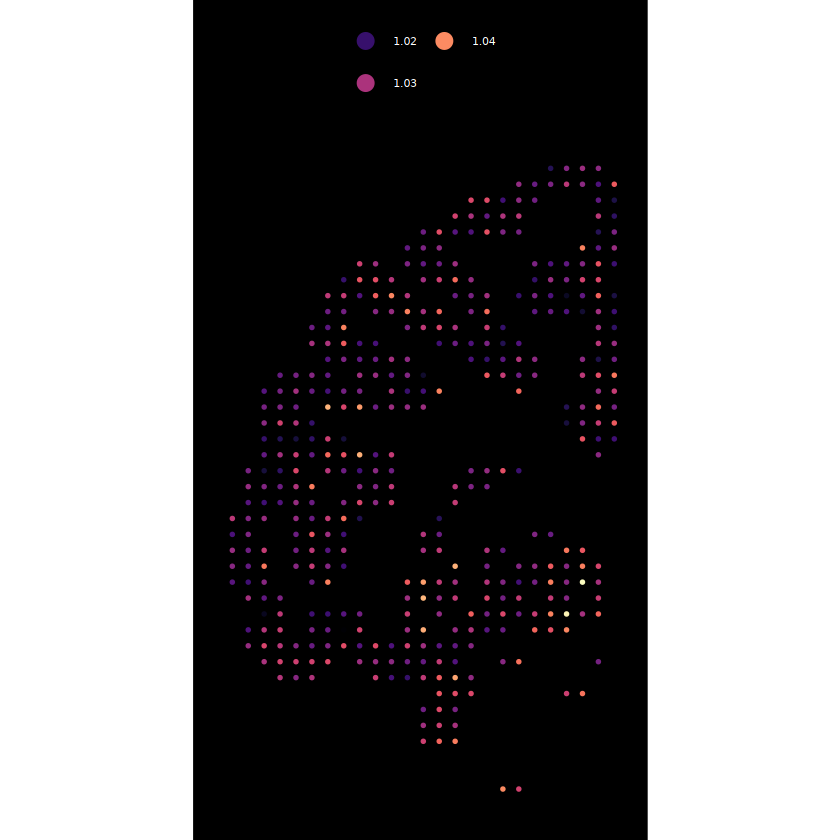

In [18]:
pmkpti1 = ggplot(fsrawdp.blt,aes(x = x, y = y,color = mtrans)) +
      geom_point(size = 0.5) +
      theme_void() + 
      scale_color_viridis(option = "A") +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 6)) +
      guides(color = guide_legend(override.aes = list(size=4),
                                  nrow = 2),
            size = "none") +
      scale_y_reverse() + scale_x_reverse() +
        coord_fixed()
pmkpti1

## Subcortical DTU analysis

### DTU Stat

file saved to result/figure6_other_cmp/isosig_stat_otheregion_25_03_03.pdf



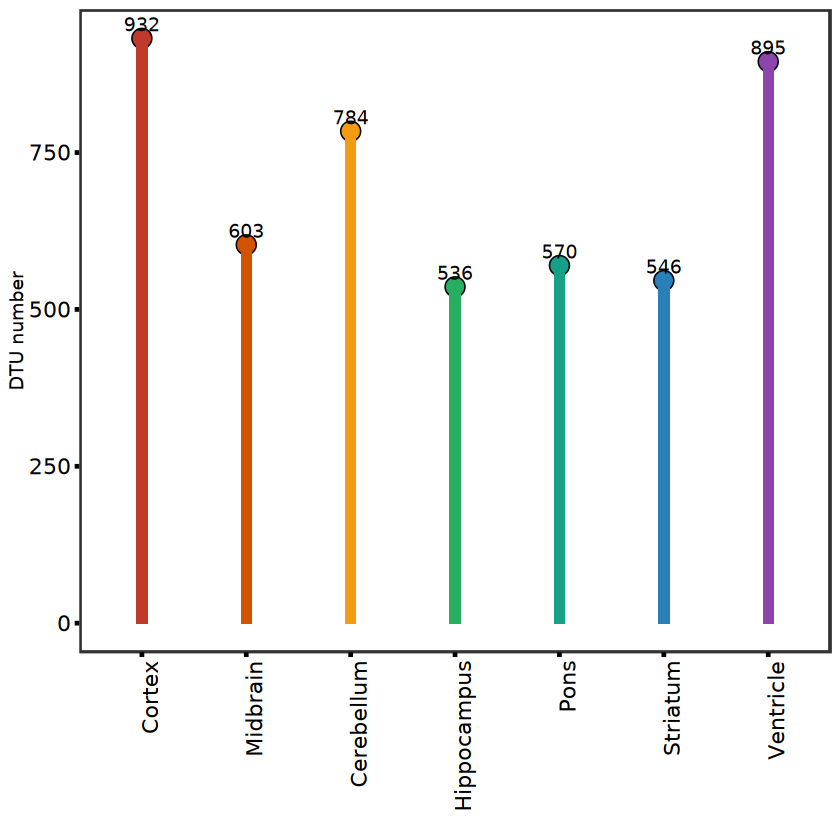

In [98]:
isosig = isosigls$subcortical
isosigf = isosig[isosig$sig != "N" ,]
#isosigf.st = isosigf %>% group_by(gene_id) %>% filter(length(unique(areatr)) == 1)
isosigf.st = isosigf %>% group_by(areatr) %>% summarise(genenum = length(unique(gene_id)))
isosigf.st$areatr = factor(isosigf.st$areatr,levels = c("Cortex","Midbrain","Cerebellum","Hippocampus",
                                                  "Pons","Striatum","Ventricle"))
p1.1 = ggplot(isosigf.st,
                aes(x= areatr, y=genenum,fill = areatr)) +
  geom_point(aes(fill = areatr),shape=21,size = 5) +
  geom_bar(width=0.1,size=0.5, stat = "identity") +
  geom_text(aes(label = genenum),vjust = -0.5) +
  theme_bw()+
  scale_fill_flatui() + ylab("DTU number") + xlab("") +
  theme(panel.grid = element_blank(),legend.position = "none",
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90,hjust = 1),
        axis.text.y = element_text(color = "black",size = 13),
        axis.ticks = element_line(color="black",linewidth = 1))
p1.1
ggexport(p1.1,filename = "result/figure6_other_cmp/isosig_stat_otheregion_25_03_03.pdf",width = 3,height = 4)

In [19]:
length(unique(isosig[!isosig$sig%in% c("N","Y"),]$gene_id))
length(unique(isosig[!isosig$sig%in% c("N","Y"),]$transcript_id))

[1] 2262

[1] 3977

In [44]:
isosiggene = list()
  areatrs = unique(isosigf$areatr)
  for (i in 1:length(areatrs)) {
    isosiggene[[i]] = unique(isosigf[isosigf$areatr == areatrs[i],]$gene_id)
  }
  names(isosiggene) = areatrs
  
  MyJaccard = function(genels1,genels2){
    calculate_jaccard <- function(list1, list2) {
      intersection <- length(intersect(list1, list2))
      union <- length(union(list1, list2))
      jaccard_score <- intersection / union
      return(jaccard_score)
    }
    num_groups1 = length(genels1)
    num_groups2 = length(genels2)
    jaccard_matrix <- matrix(0, nrow = num_groups1, ncol = num_groups2)
    
    for (i in 1:num_groups1) {
      for (j in 1:num_groups2) {
        jaccard_matrix[i, j] <- calculate_jaccard(genels1[[i]], genels2[[j]])
      }
    }
    rownames(jaccard_matrix) <- names(genels1)
    colnames(jaccard_matrix) <- names(genels2)
    return(jaccard_matrix)
  }
  jcst = MyJaccard(isosiggene,isosiggene)
#install.packages("pheatmap")
    print(pheatmap::pheatmap(jcst))
 # pdf(file = "processed/figures/f4/bambu_otheregion_sig_isoform_st_jaccardoverlap_23_12_10.pdf",
 #          width = 5,height = 4)

 # dev.off()

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'unique': object 'isosigf' not found


In [60]:
# major isoform shift stat
isosigi = isosigls$subcortical
hubgene = unique(isosigi[isosigi$sig != "N",]$gene_id)
isosigi = isosigi[isosigi$gene_id %in% hubgene,]
head(isosigi)

gene_id transcript_id  areatr     count genecount relative   meanrelative
1 AAAS    AAAS-WeiLab-1  Cerebellum  16    90       0.17777778 0.1359423   
2 AAAS    AAAS-WeiLab-1  Cortex     103   758       0.13588391 0.1359423   
3 AAAS    AAAS-WeiLab-1  Midbrain     8    60       0.13333333 0.1359423   
4 AAAS    AAAS-WeiLab-1  Ventricle    3    31       0.09677419 0.1359423   
5 AAAS    XM_005571000.2 Cerebellum  68    90       0.75555556 0.8075480   
6 AAAS    XM_005571000.2 Cortex     591   758       0.77968338 0.8075480   
  otherrelative dr            sig pvalue      padj      
1 0.1219971      5.578063e-02 N   0.009654935 0.02297132
2 0.1359618     -7.786321e-05 N   0.009654935 0.02297132
3 0.1368120     -3.478625e-03 N   0.009654935 0.02297132
4 0.1489983     -5.222415e-02 N   0.009654935 0.02297132
5 0.8205461     -6.499058e-02 N   0.009654935 0.02297132
6 0.8145142     -3.483080e-02 N   0.009654935 0.02297132

In [61]:
#construct phase dataset
isosigi$ismajor <- FALSE
isosigi <- isosigi %>%
  group_by(areatr, gene_id) %>%
  mutate(ismajor = ifelse(relative == max(relative), TRUE, FALSE)) %>%
  ungroup()
isosigi = isosigi %>% group_by(gene_id) %>% filter(meanrelative == max(meanrelative))
#isosigi[isosigi$relative > 0.5,]$ismajor = TRUE
isosigi = isosigi %>% group_by(transcript_id) %>% filter(length(unique(ismajor)) > 1)
length(unique(isosigi$gene_id))
length(unique(isosigi$transcript_id))


[1] 609

[1] 609

In [257]:
unique(isosigi$areatr)

[1] "Cerebellum"  "Cortex"      "Hippocampus" "Midbrain"    "Pons"       
[6] "Striatum"    "Ventricle"

In [62]:
# 创建原始数据框

# 转换为宽格式，每个areatr作为列
library(tidyr)
df_wide <- pivot_wider(isosigi, 
                       id_cols = transcript_id, 
                       names_from = areatr, 
                       values_from = ismajor)
#df_wide
# # 获取所有areatr的名称
# areas <- names(df_wide)[-1]  # 去除transcript_id列

# # 生成所有可能的areatr组合
# combinations <- expand.grid(ismajorT = areas, ismajorF = areas, stringsAsFactors = FALSE)
# combinations$value = 0
# for(i in 1:nrow(combinations)){
#     x <- combinations[i,"ismajorT"]
#     y <- combinations[i,"ismajorF"]
#     df_widei = df_wide[,c(x,y)]
#     df_widei = df_widei[!is.na(df_widei[,1]) & !is.na(df_widei[,2]),]
#     combinations[i,]$value = nrow(df_widei[df_widei[,1] & !df_widei[,2],])
# }
# combinations

library(dplyr)
library(tidyr)
library(purrr)
df = df_wide
# 生成单细胞组合统计表
result_single <- df %>%
  pivot_longer(-transcript_id, names_to = "cell_type", values_to = "value") %>%
  filter(!is.na(value)) %>%
  group_by(transcript_id) %>%
  summarise(
    T_cells = list(cell_type[value == TRUE]),
    F_cells = list(cell_type[value == FALSE])
  ) %>%
  filter(lengths(T_cells) > 0 & lengths(F_cells) > 0) %>%
  # 拆分单个细胞并计算权重
  mutate(
    T_single = map(T_cells, ~ {
      if(length(.x) > 0) tibble(T_single = .x, t_weight = 1/length(.x))
    }),
    F_single = map(F_cells, ~ {
      if(length(.x) > 0) tibble(F_single = .x, f_weight = 1/length(.x))
    })
  ) %>%
  select(-T_cells, -F_cells) %>%
  # 展开单细胞组合
  unnest(T_single, keep_empty = TRUE) %>%
  unnest(F_single, keep_empty = TRUE) %>%
  # 计算标准化频数
  mutate(count = t_weight * f_weight) %>%
  group_by(T_single, F_single) %>%
  summarise(count = sum(count), .groups = "drop") %>%
  # 格式整理
  arrange(desc(count)) %>%
  filter(!is.na(T_single) & !is.na(F_single))

# 查看结果
print(result_single)
result_single$T_single = factor(result_single$T_single,suborder)
result_single$F_single = factor(result_single$F_single,suborder)
library(ggalluvial)
pf1.1 = ggplot(result_single,
                   aes(axis1 = T_single, axis2 = F_single, y = count, fill = T_single)) +
        scale_x_discrete(expand = c(.1, .1)) +
        geom_alluvium(aes(fill = T_single)) +
        # geom_flow(aes(color = celltype)) +
        #geom_flow(aes(fill = prog)) +
        geom_stratum(alpha = .5) +
        scale_fill_discreterainbow() + 
        geom_text(stat = "stratum", aes(label = after_stat(stratum))) +
theme_void()
pf1.1

ismajorT    ismajorF    value
1  Cerebellum  Cerebellum    0  
2  Cortex      Cerebellum  119  
3  Hippocampus Cerebellum  112  
4  Midbrain    Cerebellum  124  
5  Pons        Cerebellum   63  
6  Striatum    Cerebellum   79  
7  Ventricle   Cerebellum   83  
8  Cerebellum  Cortex      132  
9  Cortex      Cortex        0  
10 Hippocampus Cortex      109  
11 Midbrain    Cortex      137  
12 Pons        Cortex       87  
13 Striatum    Cortex       93  
14 Ventricle   Cortex      122  
15 Cerebellum  Hippocampus  86  
16 Cortex      Hippocampus  69  
17 Hippocampus Hippocampus   0  
18 Midbrain    Hippocampus  87  
19 Pons        Hippocampus  53  
20 Striatum    Hippocampus  50  
21 Ventricle   Hippocampus  75  
22 Cerebellum  Midbrain     74  
23 Cortex      Midbrain     83  
24 Hippocampus Midbrain     70  
25 Midbrain    Midbrain      0  
26 Pons        Midbrain     22  
27 Striatum    Midbrain     50  
28 Ventricle   Midbrain     58  
29 Cerebellum  Pons         79  
30 Cortex      Pons         78  
31 Hippocampus Pons         78  
32 Midbrain    Pons         71  
33 Pons        Pons          0  
34 Striatum    Pons         77  
35 Ventricle   Pons         61  
36 Cerebellum  Striatum     86  
37 Cortex      Striatum     79  
38 Hippocampus Striatum     78  
39 Midbrain    Striatum     96  
40 Pons        Striatum     70  
41 Striatum    Striatum      0  
42 Ventricle   Striatum     75  
43 Cerebellum  Ventricle   144  
44 Cortex      Ventricle   158  
45 Hippocampus Ventricle   152  
46 Midbrain    Ventricle   153  
47 Pons        Ventricle   102  
48 Striatum    Ventricle   126  
49 Ventricle   Ventricle     0

Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
"Some strata appear at multiple axes."
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
"Some strata appear at multiple axes."
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
"Some strata appear at multiple axes."


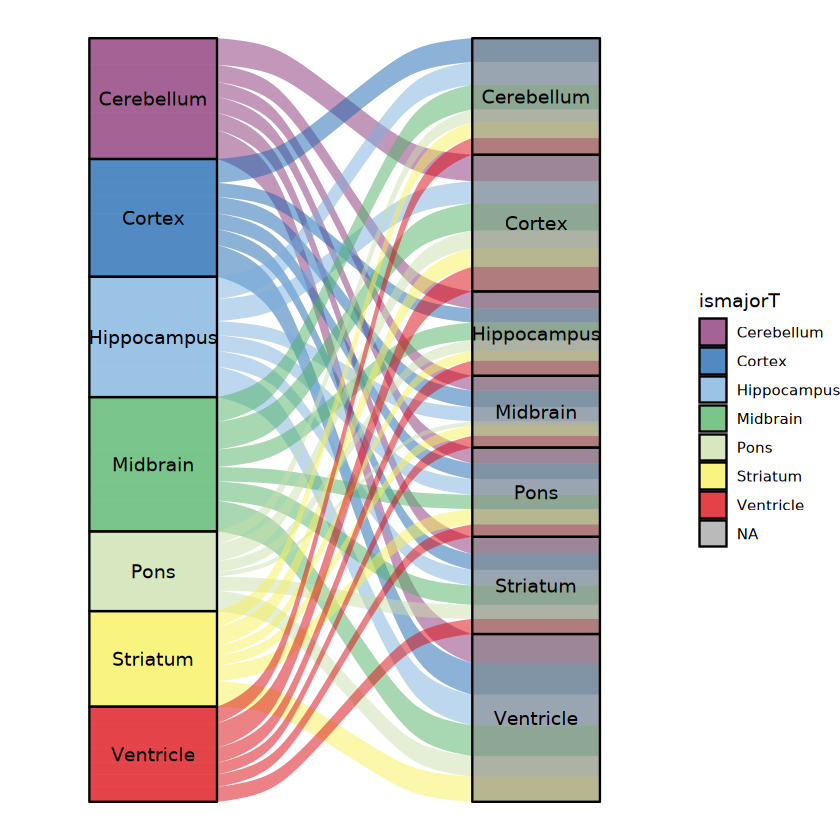

In [63]:
library(ggalluvial)
pf1.1 = ggplot(combinations,
                   aes(axis1 = ismajorT, axis2 = ismajorF, y = value, fill = ismajorT)) +
        scale_x_discrete(expand = c(.1, .1)) +
        geom_alluvium(aes(fill = ismajorT)) +
        # geom_flow(aes(color = celltype)) +
        #geom_flow(aes(fill = prog)) +
        geom_stratum(alpha = .5) +
        scale_fill_discreterainbow() +
        geom_text(stat = "stratum", aes(label = after_stat(stratum))) +
theme_void()
pf1.1

PhaseAllPlot = function(phasest_lod.org,titlei,progid){
    phasest_lod.org$color = phasest_lod.org$ismajorT
    pf1.1 = ggplot(phasest_lod.org,
                   aes(x = phase, stratum = celltype, alluvium = alluvium,
                       y = Freq, fill = color, label = celltype)) +
        scale_x_discrete(expand = c(.1, .1)) +
        #geom_alluvium(aes(fill = prog), width = 1/12) +
        # geom_flow(aes(color = celltype)) +
        geom_flow(aes(fill = prog)) +
        geom_stratum(alpha = .5) +
        scale_fill_discreterainbow() +
        geom_text(stat = "stratum", size = 3) + theme_void() +
        ggtitle(titlei)
    return(pf1.1)
}

### DTU isoform cluster

In [1]:
isosigf = isosig[isosig$transcript_id %in% isosigf$transcript_id,]

ERROR: Error in eval(expr, envir, enclos): object 'isosig' not found


In [152]:
#basic stat
#isosigf2 = isosigf2[isosigf2$sig != "N",]
isosigi = isosigls$subcortical
isosigi = isosigi[isosigi$sig != "N",]
#isosigi = isosigi %>% group_by(transcript_id,sig) %>% filter(length(areatr) == 1)
hubtrans = unique(isosigi$transcript_id)
isosigi = isosigls$subcortical
#isosigi = isosigi[isosigi$genecount > 10,]
#isosigi = isosigi %>% group_by(gene_id) %>% filter(length(unique(areatr)) > 2)
isosigf2 = isosigi[isosigi$transcript_id %in% hubtrans,]
isosigf2$dr2 = isosigf2$relative - isosigf2$meanrelative
print(length(unique(isosigf2$transcript_id)))
isosigf2 = isosigf2[isosigf2$gene_id %in% testgene, ] %>% group_by(gene_id) %>% filter(meanrelative == max(meanrelative))
print(length(unique(isosigf2$transcript_id)))
isosigf.mx = dcast(isosigf2,transcript_id~areatr,value.var = "dr",fill = 0)
rownames(isosigf.mx) = isosigf.mx$transcript_id;isosigf.mx = isosigf.mx[-1]
    
# isosigf$dr2 = isosigf$relative - isosigf$meanrelative
# isosigf2 = isosigf %>% group_by(transcript_id) %>% filter(max(dr2) > 0.1)
# isosigf2 = isosigf2 %>% group_by(gene_id) %>% filter(meanrelative == max(meanrelative))
# length(unique(isosigf2$transcript_id))
# isosigf.mx = dcast(isosigf2,transcript_id~areatr,value.var = "dr2",fun.aggregate = sum)
# rownames(isosigf.mx) = isosigf.mx$transcript_id;isosigf.mx = isosigf.mx[-1]
# #isosigf.mx = isosigf.mx[,!colnames(isosigf.mx) %in% c("EC","VLMC")]
# library(ComplexHeatmap)

n = 7
isosigf.mx2 = isosigf.mx
isosigf.mx2[is.na(isosigf.mx2)] = 0
fit = kmeans(abs(isosigf.mx2),n)
split <- factor(as.character(fit$cluster), levels=as.character(c(1:n)))
library(ComplexHeatmap)
#splitc = c(4,1,1,1,2,2,2,2,2,2,2,3,5,3,3,3,3,3)
#splitc <- factor(splitc, levels=as.character(c(1:m)))
#reorder.hmap <- Heatmap(as.matrix(cellmxfn), split=split, cluster_row_slices = FALSE,
#                          show_row_names = F,column_order = cellorder)
#reorder.hmap
isosigf.mx = as.matrix(isosigf.mx)
library(circlize)


[1] 3977
[1] 257


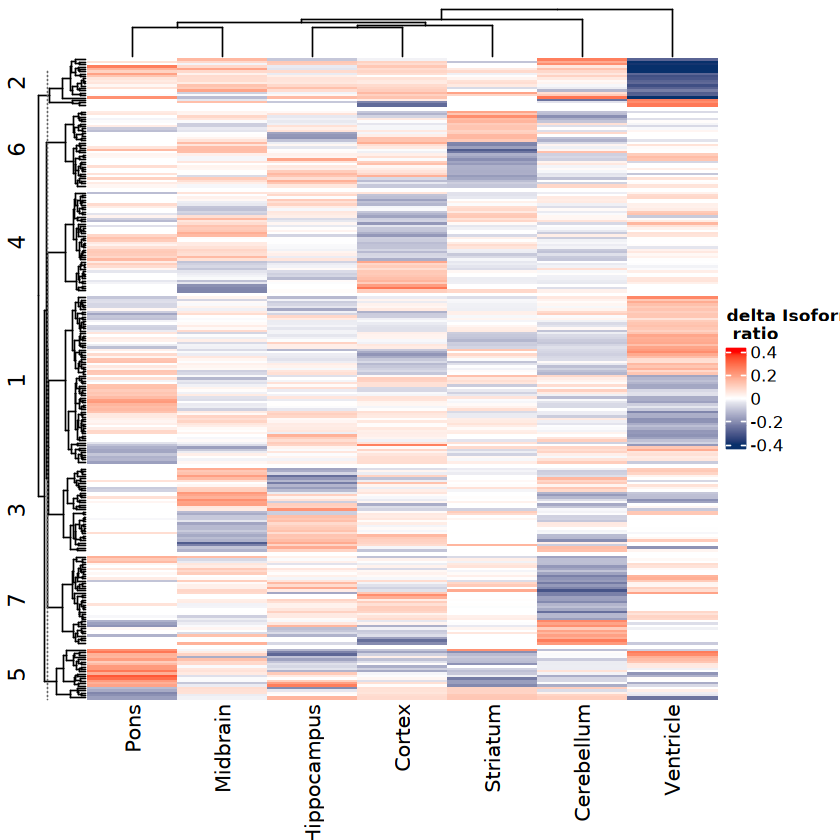

In [155]:
isosigf.mx = as.matrix(isosigf.mx)
pclonehti = Heatmap(isosigf.mx,show_row_names = F,na_col = "grey",
                    col = colorRamp2(c(-0.4,0,0.4), 
                                          c("#08306B", "white", "red")),
                    row_split = split,name = "delta Isoform\n ratio")
pclonehti

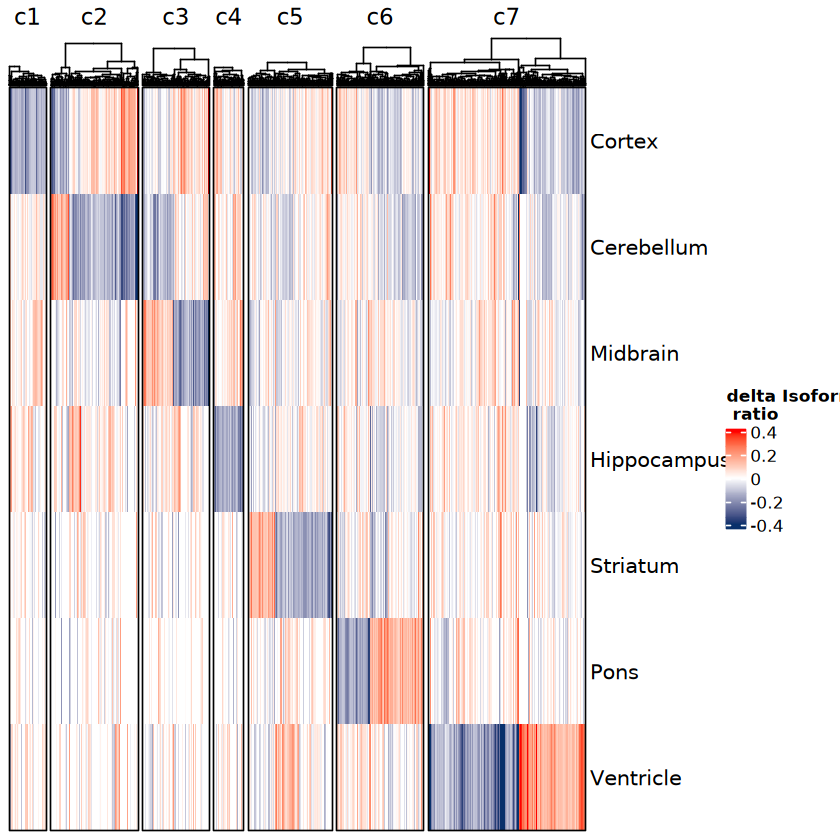

In [98]:
clist = list("c1" = c(17),"c2" = c(9,10,4,6),"c3" = c(5,1),"c4" = c(3),
             "c5" = c(19,18,20),"c6" = c(2,7,12),"c7" = c(16,11,15,13,14,8))

MergeCluster = function(htls,clist){
  #merge cluster
  split = as.character(htls$rowcluster)
  for (i in 1:length(clist)) {
    split[which(as.character(split) %in% as.character(clist[[i]]))] = names(clist)[i]
  }
  # 
  split = factor(as.character(split), levels = names(clist))
  names(split) = names(htls$rowcluster)
  reorder.hmap = Heatmap(htls$ht@matrix, 
                         name = "delta Isoform\n ratio",
                         row_split = split,
                         # cluster_rows = F,
                         cluster_columns = F,
                         cluster_row_slices = FALSE,
                         #cluster_column_slices = FALSE,
                         show_row_names = F,
                         col = colorRamp2(c(-0.4,0,0.4), 
                                          c("#08306B", "white", "red")),
                         column_order = htls$colorder
  )
  reorder.hmap
  htls$rowcluster = split
  htls$ht = reorder.hmap
  return(htls)
}
colorder = c("Cortex","Cerebellum","Midbrain","Hippocampus","Striatum","Pons","Ventricle")
htls = list(rowcluster = split,ht = pclonehti,colorder = colorder)
htls = MergeCluster(htls,clist)
htmx = t(htls$ht@matrix)
pclonehti2 = Heatmap(htmx, name = "delta Isoform\n ratio",
                         column_split = htls$rowcluster,
                         # cluster_rows = F,
                         cluster_rows = F,
                         cluster_column_slices = FALSE,
                         #cluster_column_slices = FALSE,
                         show_column_names = F,
                         col = colorRamp2(c(-0.4,0,0.4), 
                                          c("#08306B", "white", "red")),
                         row_order = htls$colorder,
                         border = TRUE)
pclonehti2
ggexport(pclonehti2,filename = "result/figure6_other_cmp/sigiso_subcortical_transcript_dr_cluster_heatmap_clone_24_11_22.pdf",width = 8,height = 3)

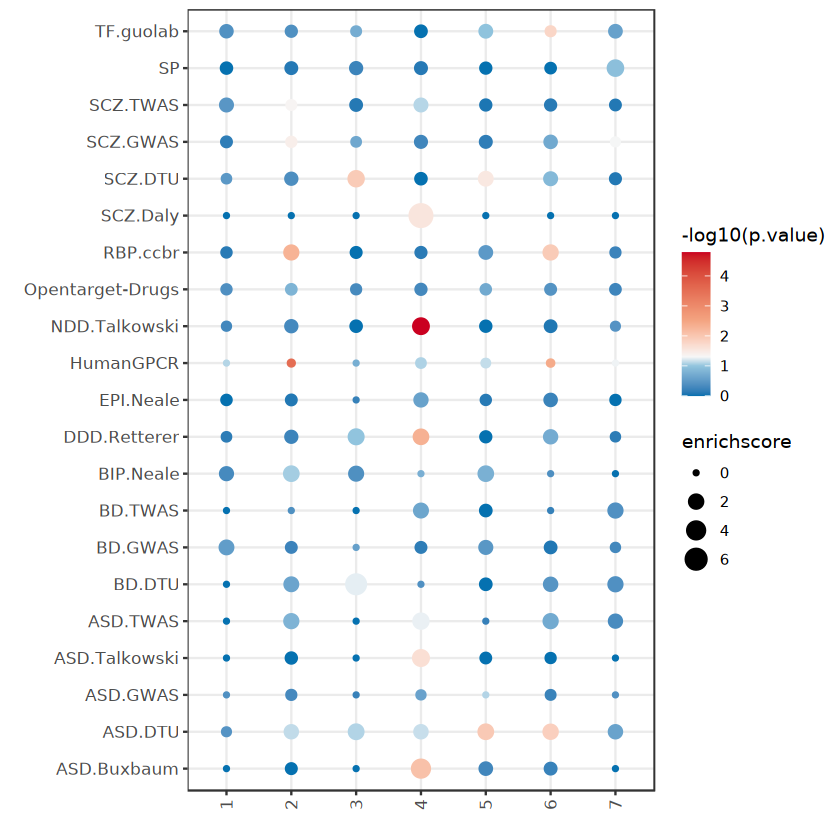

In [150]:
refgdf = read.csv("ref/disease_gene/Total_gene_list_summary_24_11_18.csv")
library(RColorBrewer)
FishEnrich = function(geneset,funcset,total_genen){
    drugovl = intersect(unique(funcset),geneset)
    geneset_size <- length(geneset)    # 感兴趣的基因集大小
    functional_category_size <- length(unique(funcset))  # 特定功能类别中的基因总数
    both <- length(drugovl)  # 两个集合都包含的基因数量
    total_genes <- 20000  # 整个基因组中的基因总数

    contingency_table <- matrix(c(both, geneset_size - both, 
                              functional_category_size - both, 
                              total_genes - (geneset_size + functional_category_size - both)), 
                            nrow = 2)

    # 进行Fisher精确检验
    fisher_test_result <- fisher.test(contingency_table)
    # 输出p值
    p_value <- fisher_test_result$p.value

    # 计算富集分数（Enrichment Ratio），这通常是感兴趣的基因集中具有特定功能的基因比例与整个基因组中该功能基因比例的比值
    enrichment_ratio <- (both / geneset_size) / (functional_category_size / total_genes)
    res = data.frame("p.value" = p_value,"enrichscore" = enrichment_ratio,"overlap_size" = both,
                     "term_size" = functional_category_size,"query_size" = geneset_size,
                    "overlap_ratio" = both/functional_category_size)
    return(res)
}

isosigt = isosigf2
isosigt = unique(isosigt[,c("gene_id","cluster")])
colnames(isosigt)[ncol(isosigt)] = "areatr"
areatrs = unique(isosigt$areatr)
goana = NULL
#refgdfi = refgdf
refgdfi = refgdf
sourceid = unique(refgdfi$source)
for(i in 1:length(areatrs)){
    isosigii = isosigt[isosigt$areatr == areatrs[i],]
    hubgene = unique(isosigii$gene_id)
    for(j in 1:length(sourceid)){
        refgene = unique(refgdfi[refgdfi$source == sourceid[j],]$gene_id)
        goanai = FishEnrich(hubgene,refgene,30000)
        goanai$group = sourceid[j]
        goanai$areatr = areatrs[i]
        goana = rbind(goana,goanai)
    }
}
maxp = max(-log10(goana$p.value))

ph = ggplot(goana,aes(x = areatr,y = group, color = -log10(p.value),size = enrichscore)) + geom_point() + theme_bw() + 
theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1,size = 10),
     axis.text.y = element_text(size = 10)) +
#facet_wrap(~class,scale = "free") +
#scale_color_gradient2(low = "blue", mid = "white",high = "red",midpoint = -log10(0.05)) + 
scale_color_gradientn(colours = rev(brewer.pal(5,"RdBu")),
                        values = c(0, 1/maxp,(-log10(0.05))/maxp,2.5/maxp,1)) +
#coord_fixed() + 
xlab("") + ylab("")
ph
#ggexport(ph,filename = "result/figure5/WGCNA_Disease_analysis.pdf",width = 5,height = 5)

In [137]:
goi = gost(query = unique(isosigf2$gene_id),organism = "mfascicularis",evcodes = TRUE)
goidf = goi$result
goidf = goidf[goidf$source == "HP",]
testgene = goidf[goidf$term_name == "Abnormal forebrain morphology",]$intersection
testgene = unlist(strsplit(testgene,","))
length(testgene)
isosigf2.hub = isosigf2[isosigf2$gene_id %in% testgene,]
isosigf2.hub = unique(isosigf2.hub[,c("gene_id","cluster")])
table(isosigf2.hub$cluster)
isosigi = isosigls$subcortical
isosigi = isosigi[isosigi$sig != "N" & isosigi$gene_id %in% testgene,]
table(isosigi[,c("sig","areatr")])

[1] 257


c1 c2 c3 c4 c5 c6 c7 
17 42 29 18 36 45 70 

      areatr
sig    Cerebellum Cortex Hippocampus Midbrain Pons Striatum Ventricle
  Down         66     65          39       33   33       39        51
  Up           60     61          51       54   71       51        87

In [28]:
hubgene = c("ARPP19","CD164L2","CLTA","CLTB","DDRGK1","FXYD1","GPX4","IDH3B","MYL6","NKX6-2","NUTF2","PDHA1","RPS27","TNNC1")
#isosigi = isosigls$subcortical
#isosigi = isosigi[isosigi$sig != "N",]
unique(isosigi[isosigi$gene_id %in% hubgene,c("gene_id","sig")])
isosigi = isosigls$subcortical

gene_id sig 
3957  ARPP19  Down
3958  ARPP19  Up  
3959  ARPP19  N   
11970 CD164L2 N   
11972 CD164L2 Up  
11973 CD164L2 Down
14215 CLTA    N   
14221 CLTA    Down
14235 CLTA    Up  
14236 CLTB    N   
14242 CLTB    Down
14249 CLTB    Up  
17063 DDRGK1  N   
17064 DDRGK1  Up  
17071 DDRGK1  Down
24560 FXYD1   N   
24561 FXYD1   Up  
24566 FXYD1   Down
26471 GPX4    N   
28945 IDH3B   Up  
28946 IDH3B   N   
28947 IDH3B   Down
44872 MYL6    Up  
44873 MYL6    Down
44875 MYL6    N   
46911 NKX6-2  N   
46912 NKX6-2  Down
46916 NKX6-2  Up  
48452 NUTF2   N   
48453 NUTF2   Up  
48460 NUTF2   Down
50445 PDHA1   N   
50446 PDHA1   Down
50450 PDHA1   Up  
59745 RPS27   Up  
59746 RPS27   Down
59749 RPS27   N   
70811 TNNC1   N   
70812 TNNC1   Up  
70815 TNNC1   Down

In [156]:
#fsraw$areatr = fsraw$subcortical
fsraw.cor$areatr = fsraw.cor$subcortical
geneex = "RPS27"
#npcase1 = fsraw.cor[fsraw.cor$gene_id == geneex,]
npcase1 = fsraw.cor[fsraw.cor$gene_id == geneex,]
npcase1 = npcase1 %>% 
        group_by(areatr) %>%
        mutate(genecount = length(unique(readid))) %>% 
        filter(genecount > 10) %>%
        group_by(areatr,transcript_id) %>%
        summarise(count = length(unique(readid)),genecount = genecount[1])
npcase1 = npcase1[npcase1$areatr != "",]
npcase1$rate = npcase1$count/npcase1$genecount
npcase1
grtdfl = BuildPlotBed(fsraw.cor,longbed,"subcortical",geneex,NULL)
pclsi = tryCatch(IsoformReadPlot(gtf, grtdfl, geneex,onlyhub = F), 
                                                  error = function(e) NULL)
pclsi

`summarise()` has grouped output by 'areatr'. You can override using the
`.groups` argument.


areatr      transcript_id  count genecount rate     
1  Cerebellum  RPS27-WeiLab-1  198   277      0.7148014
2  Cerebellum  XM_005541720.2   79   277      0.2851986
3  Cortex      RPS27-WeiLab-1 2661  9487      0.2804891
4  Cortex      XM_005541720.2 6826  9487      0.7195109
5  Hippocampus RPS27-WeiLab-1  106   137      0.7737226
6  Hippocampus XM_005541720.2   31   137      0.2262774
7  Midbrain    RPS27-WeiLab-1  127   174      0.7298851
8  Midbrain    XM_005541720.2   47   174      0.2701149
9  Pons        RPS27-WeiLab-1   31    49      0.6326531
10 Pons        XM_005541720.2   18    49      0.3673469
11 Striatum    RPS27-WeiLab-1   39    60      0.6500000
12 Striatum    XM_005541720.2   21    60      0.3500000
13 Ventricle   RPS27-WeiLab-1   45    95      0.4736842
14 Ventricle   XM_005541720.2   50    95      0.5263158

ERROR: Error in BuildPlotBed(fsraw.cor, longbed, "subcortical", geneex, NULL): could not find function "BuildPlotBed"


Warning message:
"Duplicated aesthetics after name standardisation: size"
file saved to result/figure6_other_cmp/sigiso_subcortical_transcript_dr_cluster_heatmap_module_ana_24_11_21.pdf



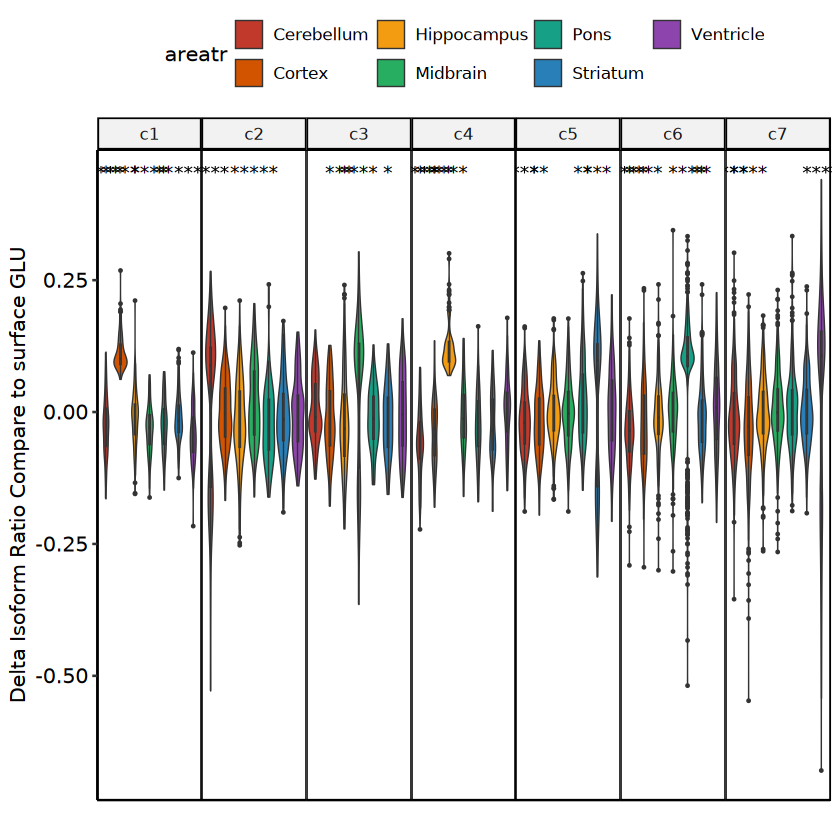

In [56]:
#myclassan
#isosigf2$class = splitc[match(isosigf2$areatr,myclassan$subclass),]$class
#isosigf3 = isosigf2[isosigf2$class %in% c("surface-GLU","deep-GLU","GABA",'nonNeuron-ASC','nonNeuron-OLG'),]
#isosigf3$class = factor(isosigf3$class,levels = c("surface-GLU","deep-GLU","GABA",'nonNeuron-ASC','nonNeuron-OLG'))
clusteran = data.frame("cluster" = htls$rowcluster,"transcript_id" = rownames(htls$ht@matrix))
isosigf2$cluster = clusteran[match(isosigf2$transcript_id,clusteran$transcript_id),]$cluster

pmst = ggplot(isosigf2,aes(x = areatr,y = dr2,fill = areatr)) + 
geom_violin(size = 0.3,drop = FALSE) +
geom_boxplot(size = 0.3,fill = "white",width=0.1,cex=0.8,outlier.size = 0.3,position = position_dodge(0.9)) +
facet_grid(~cluster,scales = "free") + theme_pubr() + xlab("") + ylab("Delta Isoform Ratio Compare to surface GLU") +
scale_fill_flatui() +
stat_compare_means(aes(label = after_stat(p.signif)),hide.ns = T,ref.group = ".all.") +
theme(axis.text.x = element_blank(),
       axis.ticks.x = element_blank(),
      panel.spacing = unit(0,'lines'),
      panel.border = element_rect(fill = NA)) 
pmst
ggexport(pmst,filename = "result/figure6_other_cmp/sigiso_subcortical_transcript_dr_cluster_heatmap_module_ana_24_11_21.pdf",width = 8,height = 5)

In [76]:
write.csv(isosigf2,file = "result/figure6_other_cmp/sigiso_subcortical_transcript_dr_cluster_file_24_11_22.csv",quote = F,row.names = F)
head(isosigf2)

gene_id transcript_id  areatr      count genecount relative  meanrelative
1 AAAS    XM_005571000.2 Cerebellum   68    90       0.7555556 0.8075480   
2 AAAS    XM_005571000.2 Cortex      591   758       0.7796834 0.8075480   
3 AAAS    XM_005571000.2 Hippocampus  18    23       0.7826087 0.8075480   
4 AAAS    XM_005571000.2 Midbrain     49    60       0.8166667 0.8075480   
5 AAAS    XM_005571000.2 Ventricle    28    31       0.9032258 0.8075480   
6 AACS    NM_001284010.1 Cerebellum  145   157       0.9235669 0.8555514   
  otherrelative dr          sig pvalue      padj       dr2          cluster
1 0.8205461     -0.06499058 N   0.009654935 0.02297132 -0.051992465 c7     
2 0.8145142     -0.03483080 N   0.009654935 0.02297132 -0.027864643 c7     
3 0.8137829     -0.03117416 N   0.009654935 0.02297132 -0.024939325 c7     
4 0.8052684      0.01139831 N   0.009654935 0.02297132  0.009118646 c7     
5 0.7836286      0.11959723 Up  0.009654935 0.02297132  0.095677786 c7     
6 0.8419483      0.08161863 N   0.001925820 0.00561410  0.068015521 c3

#### Cluster Module GO analysis

In [24]:
library(gprofiler2)

In [25]:
library(gprofiler2)
MyGOPlot = function(hubgenei,ni,mytitle,mycolor = NULL){
    goi = gost(query = hubgenei,
               organism = "mfascicularis")
#godfi = CalOddRate(goi$result,5)
    godfi = goi$result
    godfi = godfi[godfi$source %in% c("HP","KEGG"),]
    godfi$gene_ratio = godfi$intersection_size/godfi$term_size
#godfi = godfi[godfi$p_value < 0.05,]
    godfi = godfi[godfi$intersection_size > 2,] %>% group_by(source) %>% arrange(intersection_size) %>% 
    top_n(wt = intersection_size,n = ni)
    godfi$term_name = factor(godfi$term_name,levels = unique(godfi$term_name))
    print(nrow(godfi))

    if(is.null(mycolor)){
        mycolor = pal_flatui("default")(length(unique(godfi$source)))
    }
    godfi = godfi[!godfi$term_name %in% c("cell junction","cytoplasm","cytosol","cytoskeleton"),]
    if(nrow(godfi) > 0){
        pgi = ggplot(godfi,
               aes(x = intersection_size, y=term_name,fill = source)) + 
        geom_point(aes(size = gene_ratio),shape = 21) +
        geom_bar(stat = "identity",width = 0.03) +
        geom_text(aes(label = term_name,x = 0),hjust = -0.01,vjust = -0.5) +
        scale_fill_manual(values = mycolor) +
 #       scale_fill_viridis(direction = 1,option = "A") +
        #scale_fill_distiller(direction = 1,palette = "Greens") +
    # scale_y_discrete(labels = rev(unique(godftf$term_name))) +
    #facet_grid(source~.,scales = "free",space = "free") + 
        xlab("gene counts") +
        theme_pubr() + theme(legend.position = "top",axis.text.y = element_blank()) +
        ggtitle(mytitle)
    }else{
        pgi = NULL
    }
    return(pgi)
    
}

MyGOCal = function(hubgenei,ni){
    goi = gost(query = hubgenei,
               organism = "mfascicularis")
#godfi = CalOddRate(goi$result,5)
    godfi = goi$result
    #godfi = godfi[godfi$source %in% c("HP","KEGG"),]
    godfi$gene_ratio = godfi$intersection_size/godfi$term_size
#godfi = godfi[godfi$p_value < 0.05,]
    
    godfi = godfi %>% group_by(source) %>% arrange(intersection_size) %>% 
    top_n(wt = intersection_size,n = ni)
    godfi$term_name = factor(godfi$term_name,levels = unique(godfi$term_name))
    print(nrow(godfi))

    godfi = godfi[!godfi$term_name %in% c("cell junction","cytoplasm","cytosol","cytoskeleton"),]

    return(godfi)
    
}


[1] 3602

[1] 402
[1] 9
[1] 529
[1] 22
[1] 585
[1] 8
[1] 338
[1] 15
[1] 358
[1] 21
[1] 345
[1] 24


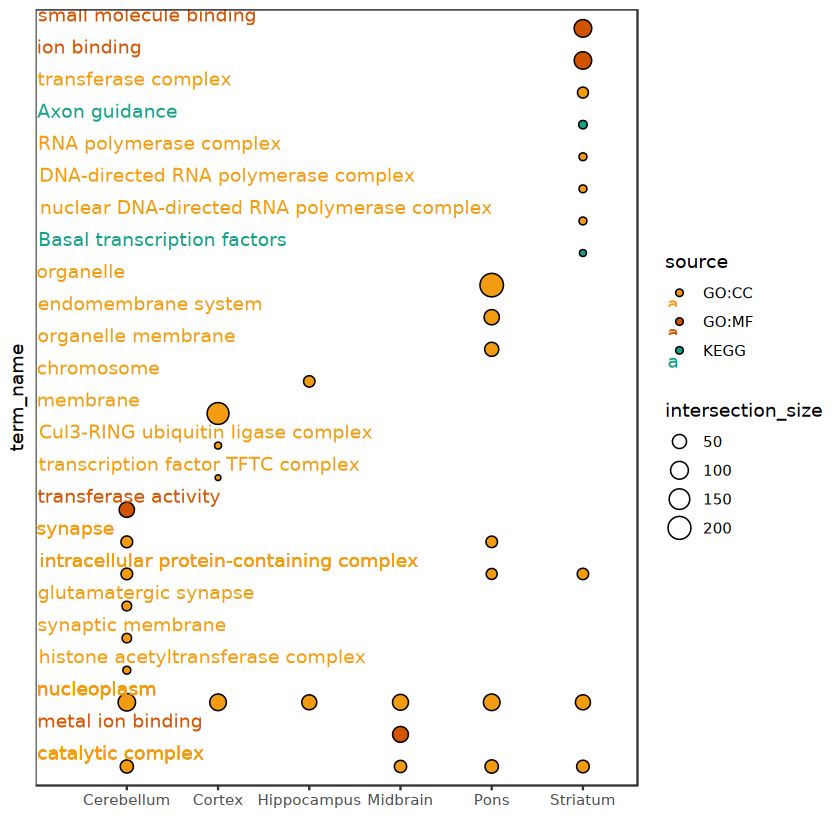

In [30]:
clusterid = paste0("c",as.character(1:7))
mycolor = pal_flatui("default")(5)
names(mycolor) = c("GO:BP","GO:MF","GO:CC","HP","KEGG")

isosigi = isosigls$subcortical
isosigi = isosigi[isosigi$sig != "N",]
filtg = isosigi[isosigi$areatr == 'Ventricle',]$gene_id
isosigi = isosigi[!isosigi$gene_id %in% filtg,]
#isosigi = isosigi %>% group_by(gene_id) %>% filter(length(areatr) == 1)
length(isosigi$gene_id)
isosigi$cluster = isosigi$areatr

# htls = list(rowcluster = split,ht = pclonehti)
# clusteran = data.frame("cluster" = htls$rowcluster,"transcript_id" = rownames(htls$ht@matrix))
# isosigf2$cluster = clusteran[match(isosigf2$transcript_id,clusteran$transcript_id),]$cluster
# isosigi = isosigf2
clusterid = unique(isosigi$cluster)
pgls = list()
godft = NULL
for(i in 1:length(clusterid)){
    hubgenei = unique(isosigi[as.character(isosigi$cluster) == clusterid[i],]$gene_id)
    print(length(hubgenei))
    godfi = tryCatch(MyGOCal(hubgenei,10),error = function(e) 0)
    if(!is.null(nrow(godfi))){
        if(nrow(godfi) > 0){
            godfi$group = clusterid[i]
            godft = rbind(godft,godfi)
        }
    }
    #godfi = MyGOCal(hubgenei,5)
    
    #pgls[[i]] = MyGOPlot(hubgenei,5,clusterid[i],mycolor)
}
#head(godft)
pgot = ggplot(data = godft[!godft$source %in% "GO:BP",]) + 
     # geom_rect(data = unique(godft[,c("term_name","source")]),
     #                               aes(ymin = as.numeric(term_name)-0.5,ymax = as.numeric(term_name)+0.5,
     #                                                        xmin = -Inf,xmax = Inf,fill = source),
     #            alpha = 0.2) +
    geom_point(aes(x = group,y = term_name,size = intersection_size,fill = source),shape = 21,color = "black") +
    geom_text(aes(y = term_name,label = term_name,x = 0,color = source),hjust = -0.01,vjust = -0.5) +
        scale_fill_manual(values = mycolor) + 
    scale_color_manual(values = mycolor) +
#    facet_grid(group~.,scales = "free",space = "free") +
    theme_bw() +
    theme(axis.text.y = element_blank(),
       axis.ticks.y = element_blank(),
      panel.spacing = unit(0,'lines'),
      panel.grid.major = element_blank(),
      #panel.grid.minor = element_blank(),
      panel.border = element_rect(fill = NA)) + xlab("")
pgot
#ggexport(pgot,filename = "result/figure6_other_cmp/dtu_go_analysis_cluster_total_24_11_22.pdf",width = 6,height = 9)

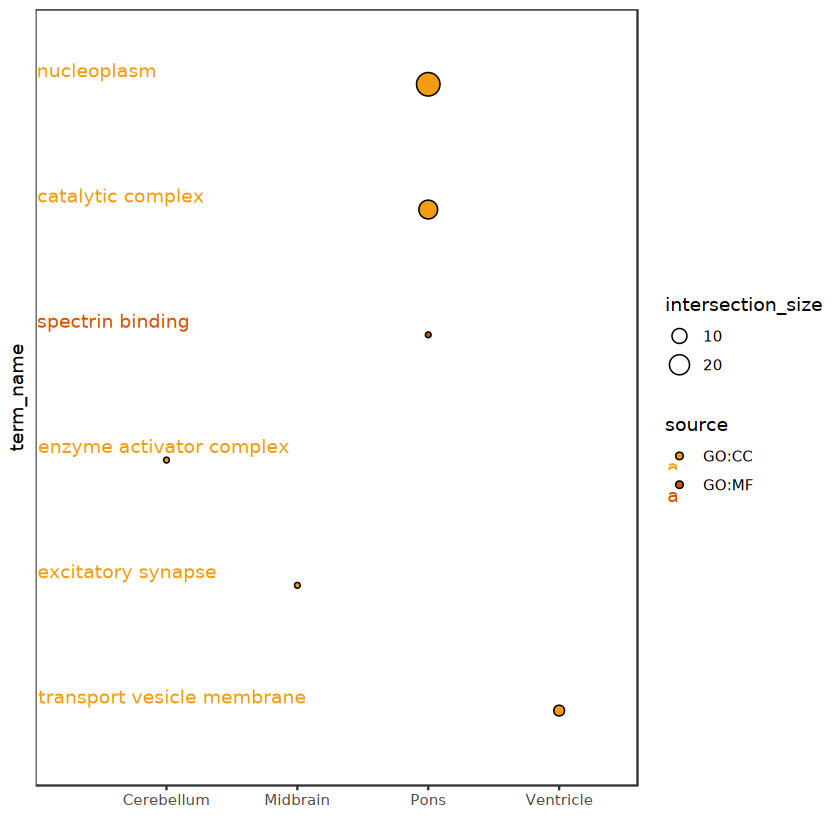

In [27]:
pgot = ggplot(data = godft[!godft$source %in% "GO:BP",]) + 
     # geom_rect(data = unique(godft[,c("term_name","source")]),
     #                               aes(ymin = as.numeric(term_name)-0.5,ymax = as.numeric(term_name)+0.5,
     #                                                        xmin = -Inf,xmax = Inf,fill = source),
     #            alpha = 0.2) +
    geom_point(aes(x = group,y = term_name,size = intersection_size,fill = source),shape = 21,color = "black") +
    geom_text(aes(y = term_name,label = term_name,x = 0,color = source),hjust = -0.01,vjust = -0.5) +
        scale_fill_manual(values = mycolor) + 
    scale_color_manual(values = mycolor) +
#    facet_grid(group~.,scales = "free",space = "free") +
    theme_bw() +
    theme(axis.text.y = element_blank(),
       axis.ticks.y = element_blank(),
      panel.spacing = unit(0,'lines'),
      panel.grid.major = element_blank(),
      #panel.grid.minor = element_blank(),
      panel.border = element_rect(fill = NA)) + xlab("")
pgot
#ggexport(pgot,filename = "result/figure6_other_cmp/dtu_go_analysis_cluster_total_24_11_22.pdf",width = 6,height = 9)

[1] 2262

[1] 14


file saved to result/figure6_other_cmp/dtu_go_analysis_total_subcortical_HP_KEGG_24_12_25.pdf



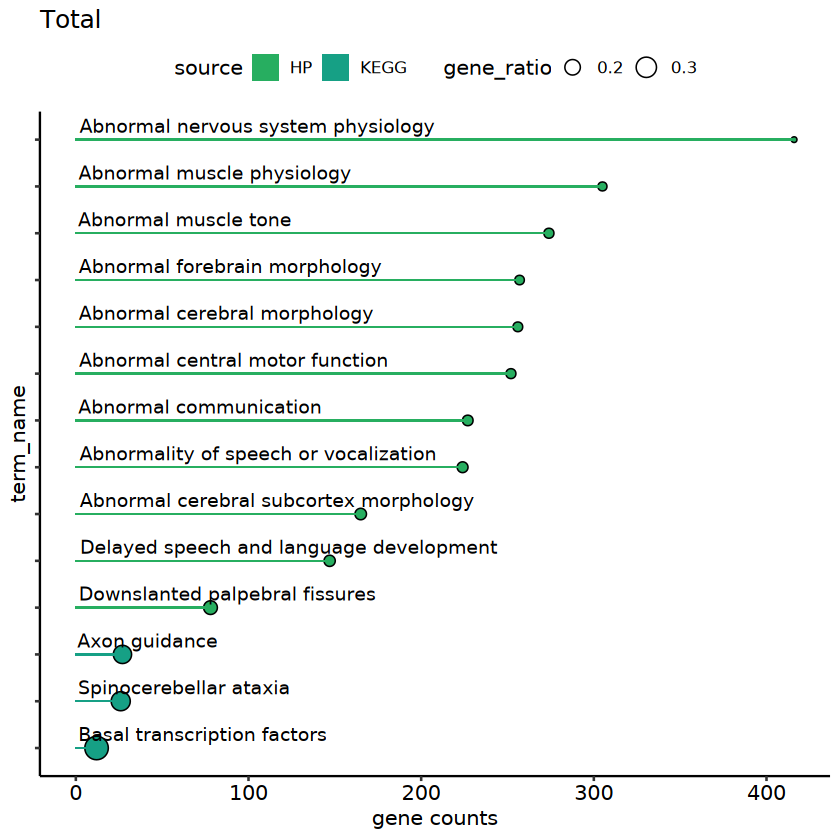

In [31]:
mycolor = pal_flatui("default")(5)
names(mycolor) = c("GO:BP","GO:MF","GO:CC","HP","KEGG")
isosigi = isosigls$subcortical
isosigi = isosigi[isosigi$sig != "N",]
hubgenei = unique(isosigi$gene_id)
#hubgenei = unique(isosigf2[as.character(isosigf2$cluster) %in% c('3'),]$gene_id)
length(hubgenei)
pgi = MyGOPlot(hubgenei,20,"Total",mycolor)
pgi
ggexport(pgi,filename = "result/figure6_other_cmp/dtu_go_analysis_total_subcortical_HP_KEGG_24_12_25.pdf",width = 4,height = 6)

#### subcortical regression analysis

[1] 6175

[1] 2483

Warning message in geom_text(data = textData, aes(label = !!as.name("diagLabel")), :
"Ignoring unknown parameters: `stroke`"


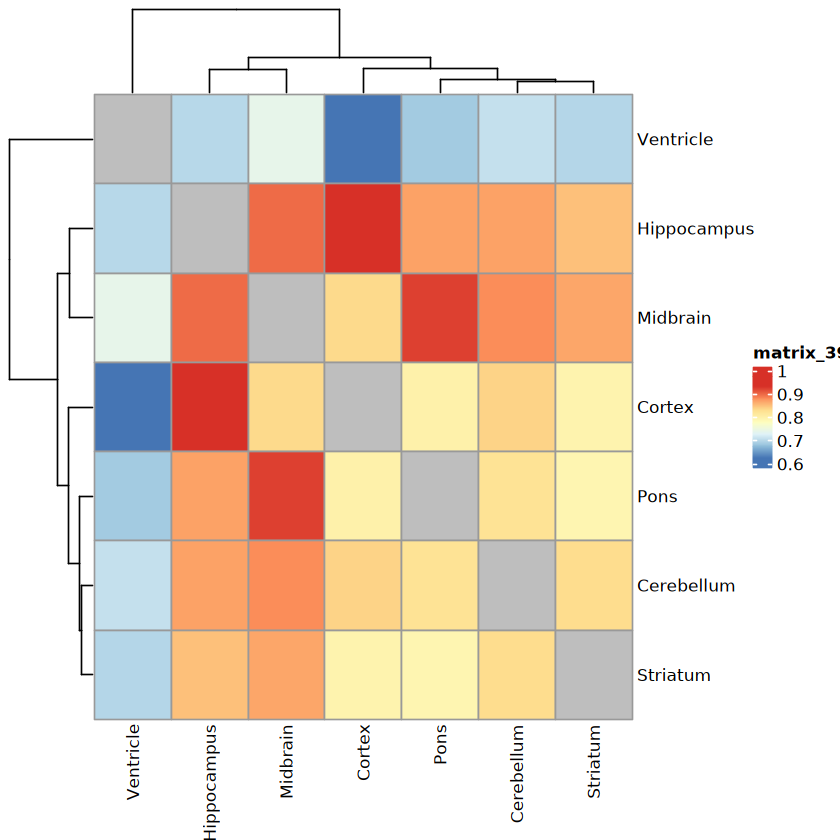

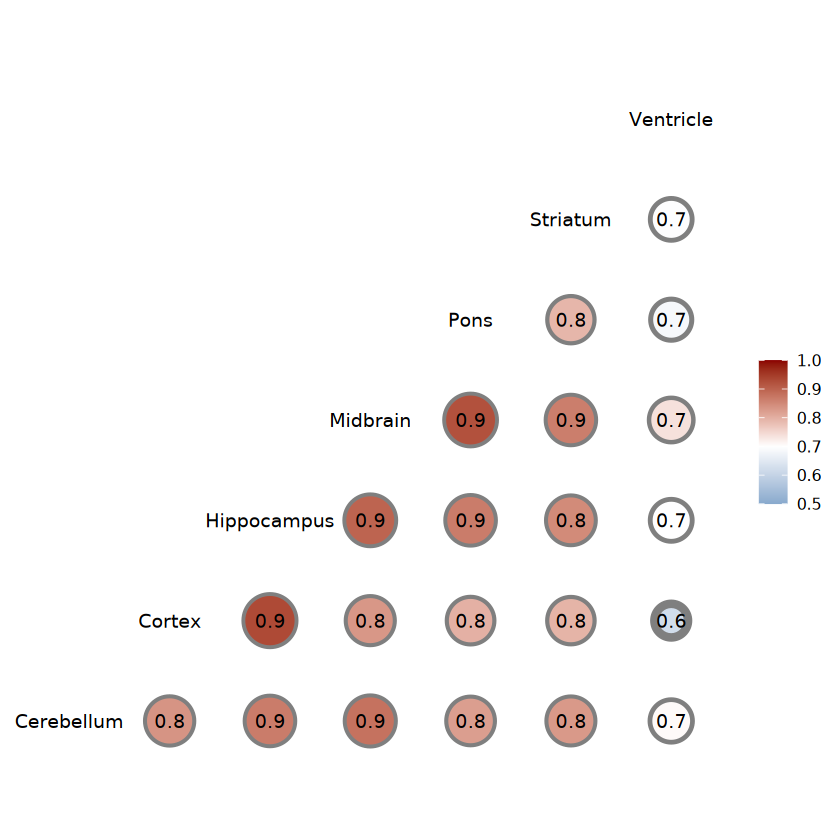

In [245]:
isosigi = isosigls$subcortical
#isosigi = isosigi[isosigi$transcript_id %in% isosigi[isosigi$sig != "N",]$transcript_id,]
isosigf.mx = dcast(isosigi,gene_id~areatr,value.var = "count",fun.aggregate = sum)
rownames(isosigf.mx) = isosigf.mx$gene_id;isosigf.mx = isosigf.mx[-1]
isosigf.mx = as.data.frame(isosigf.mx)
nrow(isosigf.mx)
isosigf.mx = isosigf.mx[rowSums(isosigf.mx != 0) == 7,]
nrow(isosigf.mx)
subcor.pr = cor(isosigf.mx)
subcor.pr[subcor.pr == 1] = NA
pheatmap(subcor.pr)

pcor = GGally::ggcorr(isosigf.mx, 
               label = TRUE,limits = c(0.5,1),stroke = 2,
               min_size = 6, max_size = 15,
               method =  c("pairwise", "pearson"),geom = "circle",midpoint = 0.7,
               low = "steelblue", mid = "white", high = "darkred")
pcor

[1] 15687

[1] 5565

Cerebellum  Cortex      Hippocampus Midbrain    Pons       
Cerebellum   1.00000000  0.16377508 -0.05737463 -0.12373941 -0.27895559
Cortex       0.16377508  1.00000000  0.18289840 -0.22262491 -0.26202166
Hippocampus -0.05737463  0.18289840  1.00000000 -0.10441735 -0.26304230
Midbrain    -0.12373941 -0.22262491 -0.10441735  1.00000000  0.04345071
Pons        -0.27895559 -0.26202166 -0.26304230  0.04345071  1.00000000
Striatum    -0.09878036 -0.08621543 -0.02323885 -0.15733941 -0.31166351
Ventricle   -0.29033461 -0.40898123 -0.32524785 -0.18963016 -0.18785122
            Striatum    Ventricle 
Cerebellum  -0.09878036 -0.2903346
Cortex      -0.08621543 -0.4089812
Hippocampus -0.02323885 -0.3252479
Midbrain    -0.15733941 -0.1896302
Pons        -0.31166351 -0.1878512
Striatum     1.00000000 -0.2130058
Ventricle   -0.21300577  1.0000000

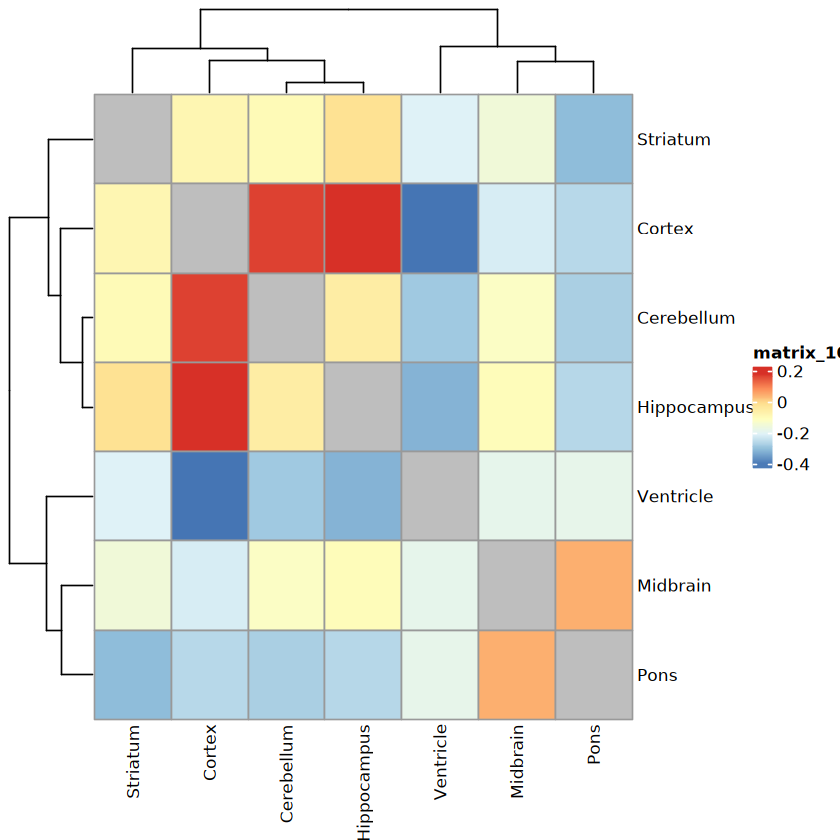

In [75]:
isosigi = isosigls$subcortical
#isosigi = isosigi[isosigi$transcript_id %in% isosigi[isosigi$sig != "N",]$transcript_id,]
isosigf.mx = dcast(isosigi,transcript_id~areatr,value.var = "dr",fun.aggregate = sum)
rownames(isosigf.mx) = isosigf.mx$transcript_id;isosigf.mx = isosigf.mx[-1]
isosigf.mx = as.data.frame(isosigf.mx)
nrow(isosigf.mx)
isosigf.mx = isosigf.mx[rowSums(isosigf.mx != 0) == 7,]
nrow(isosigf.mx)
subcor.pr = cor(isosigf.mx)
subcor.pr[subcor.pr == 1] = NA
pheatmap(subcor.pr)
cor(isosigf.mx)

In [79]:
head(isosigf.mx)

Cerebellum  Cortex       Hippocampus  Midbrain     Pons        
AAMDC-WeiLab-1  -0.02537020 -0.037190585  0.031172197  0.007382531  0.006610793
ABLIM1-WeiLab-1  0.04404519  0.014722870 -0.039397002 -0.001238560 -0.014652516
ACAA2-WeiLab-1  -0.08561570 -0.014877277  0.106249527 -0.001702907  0.013254358
ACBD5-WeiLab-1   0.01028387  0.001791812 -0.028931816 -0.017370219 -0.010235966
ACP1-WeiLab-2    0.04114767  0.012464880 -0.035176053 -0.005180039  0.013810956
ACP6-WeiLab-1   -0.08108715  0.019171440 -0.004198989  0.047431944  0.006450098
                Striatum      Ventricle   
AAMDC-WeiLab-1  -0.0001237854  0.017519051
ABLIM1-WeiLab-1  0.0039955026 -0.007475483
ACAA2-WeiLab-1   0.0880406827 -0.105348685
ACBD5-WeiLab-1   0.0532702957 -0.008807977
ACP1-WeiLab-2   -0.0086794305 -0.018387979
ACP6-WeiLab-1   -0.0871758159  0.099408474

file saved to result/figure6_other_cmp/subcortical_correlation_cor_25_03_05.pdf



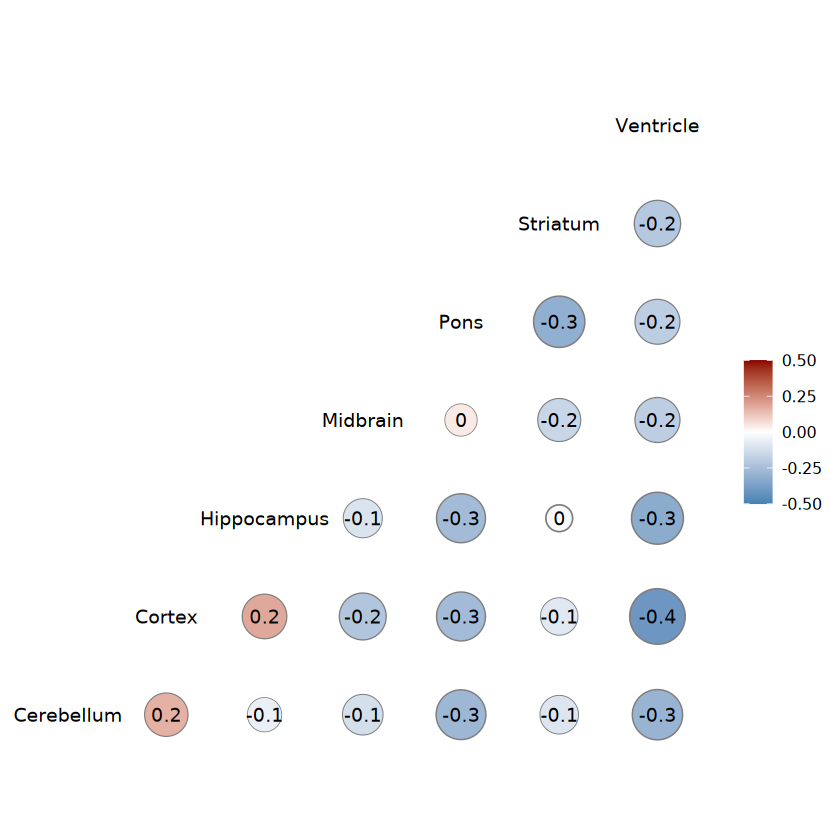

In [223]:
pcor = GGally::ggcorr(isosigf.mx, 
               label = TRUE,
               limits = c(-0.5,0.5),min_size = 6, max_size = 15,
               method =  c("pairwise", "pearson"),geom = "circle", 
               low = "steelblue", mid = "white", high = "darkred")
pcor
ggexport(pcor,filename = "result/figure6_other_cmp/subcortical_correlation_cor_25_03_05.pdf",width = 5,height = 4)

[1] -0.5407308

[1] 0.06059645

[1] -0.4063269

[1] "Cerebellum"  "Cortex"      "Hippocampus" "Midbrain"    "Pons"       
[6] "Striatum"    "Ventricle"

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
file saved to result/figure6_other_cmp/structure_sig_transcript_dr_point_cor_24_11_25.pdf



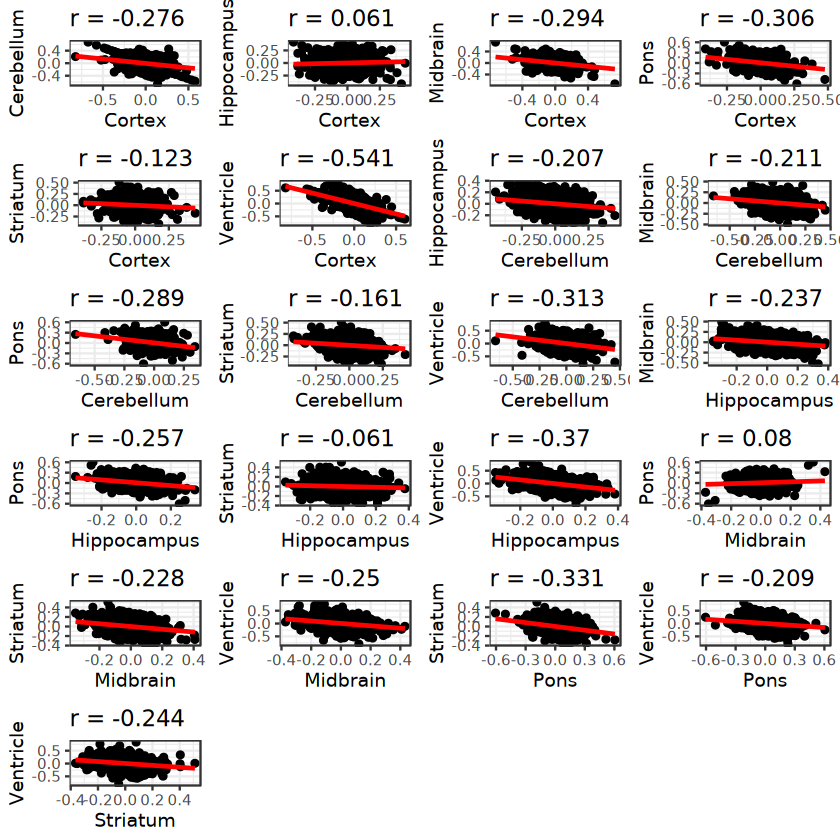

In [344]:
isosigi = isosigls$subcortical
isosigi = isosigi[isosigi$transcript_id %in% isosigi[isosigi$sig != "N",]$transcript_id,]
isosigf.mx = dcast(isosigi,transcript_id~areatr,value.var = "dr",fun.aggregate = sum)
rownames(isosigf.mx) = isosigf.mx$transcript_id;isosigf.mx = isosigf.mx[-1]
isosigf.mx = as.data.frame(isosigf.mx)
  cor(isosigf.mx[isosigf.mx$Cortex != 0 &
                    isosigf.mx$Ventricle != 0,]$Cortex,
      isosigf.mx[isosigf.mx$Cortex != 0 &
                    isosigf.mx$Ventricle != 0,]$Ventricle)
  cor(isosigf.mx[isosigf.mx$Cortex != 0 &
                    isosigf.mx$Hippocampus != 0,]$Cortex,
      isosigf.mx[isosigf.mx$Cortex != 0 &
                    isosigf.mx$Hippocampus != 0,]$Hippocampus)
  cor(isosigf.mx$Cortex,isosigf.mx$Ventricle)
  colnames(isosigf.mx)
  isosigf.mx2 = isosigf.mx[,c("Cortex","Cerebellum", "Hippocampus",
                              "Midbrain", "Pons", "Striatum","Ventricle")]
  pls = list()
  n = 1
  for (i in 1:6) {
    for (j in (i+1):7) {
      pdf1 = isosigf.mx2
      colnames(pdf1)[c(i,j)] = c("Var1","Var2")
      pdf1 = pdf1[pdf1$Var1 != 0 &
                    pdf1$Var2 != 0,]
      pi = ggplot(pdf1,
             aes(x = Var1,y = Var2)) + 
        geom_point() + 
        geom_smooth(method = "lm",color = "red") + 
        ggtitle(paste0("r = ", round(cor(pdf1$Var1,pdf1$Var2),3))) +
        theme_bw() + xlab(colnames(isosigf.mx2)[i]) + ylab(colnames(isosigf.mx2)[j])
      pls[[n]] = pi
      n = n +1
    }
  }
  pt = ggarrange(plotlist = pls,nrow = 6,ncol = 4)
pt
ggexport(pt,filename = "result/figure6_other_cmp/structure_sig_transcript_dr_point_cor_24_11_25.pdf",width = 8,height = 12)

file saved to result/figure6_other_cmp/subcortical_sig_iso_cluster_correlation_ana_24_11_22.pdf



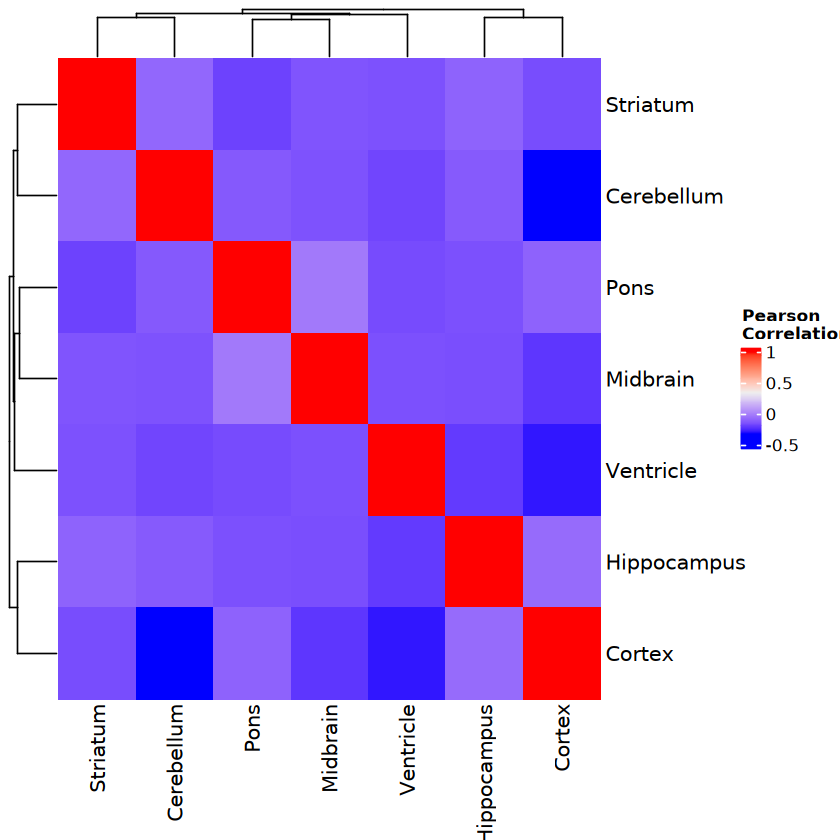

In [34]:
pclcor = Heatmap(cor(isosigf.mx),name = "Pearson \nCorrelation")
pclcor
ggexport(pclcor,filename = "result/figure6_other_cmp/subcortical_sig_iso_cluster_correlation_ana_24_11_22.pdf",width = 5,height = 4)

### Isoform shift stat

In [16]:
library(dplyr)
library(tidyr)
library(purrr)
# major isoform shift stat
isosigi = isosigls$subcortical
hubgene = unique(isosigi[isosigi$sig != "N",]$gene_id)
isosigi = isosigi[isosigi$gene_id %in% hubgene,]
head(isosigi)
#construct phase dataset
isosigi$ismajor <- FALSE
isosigi <- isosigi %>%
  group_by(areatr, gene_id) %>%
  mutate(ismajor = ifelse(relative == max(relative), TRUE, FALSE)) %>%
  ungroup()
isosigi = isosigi %>% group_by(gene_id) %>% filter(meanrelative == max(meanrelative))
#isosigi[isosigi$relative > 0.5,]$ismajor = TRUE
isosigi = isosigi[isosigi$ismajor == TRUE | (isosigi$ismajor == FALSE & abs(isosigi$relative - isosigi$otherrelative) > 0.1),]
isosigi = isosigi %>% group_by(transcript_id) %>% filter(length(unique(ismajor)) > 1)
length(unique(isosigi$gene_id))
length(unique(isosigi$transcript_id))
library(tidyr)
df_wide <- pivot_wider(isosigi, 
                       id_cols = transcript_id, 
                       names_from = areatr, 
                       values_from = ismajor)


Attaching package: 'tidyr'


The following object is masked from 'package:reshape2':

    smiths


The following object is masked from 'package:S4Vectors':

    expand



Attaching package: 'purrr'


The following object is masked from 'package:XVector':

    compact


The following object is masked from 'package:GenomicRanges':

    reduce


The following object is masked from 'package:IRanges':

    reduce


The following object is masked from 'package:data.table':

    transpose




gene_id transcript_id  areatr     count genecount relative   meanrelative
1 AAAS    AAAS-WeiLab-1  Cerebellum  16    90       0.17777778 0.1359423   
2 AAAS    AAAS-WeiLab-1  Cortex     103   758       0.13588391 0.1359423   
3 AAAS    AAAS-WeiLab-1  Midbrain     8    60       0.13333333 0.1359423   
4 AAAS    AAAS-WeiLab-1  Ventricle    3    31       0.09677419 0.1359423   
5 AAAS    XM_005571000.2 Cerebellum  68    90       0.75555556 0.8075480   
6 AAAS    XM_005571000.2 Cortex     591   758       0.77968338 0.8075480   
  otherrelative dr            sig pvalue      padj      
1 0.1219971      5.578063e-02 N   0.009654935 0.02297132
2 0.1359618     -7.786321e-05 N   0.009654935 0.02297132
3 0.1368120     -3.478625e-03 N   0.009654935 0.02297132
4 0.1489983     -5.222415e-02 N   0.009654935 0.02297132
5 0.8205461     -6.499058e-02 N   0.009654935 0.02297132
6 0.8145142     -3.483080e-02 N   0.009654935 0.02297132

[1] 547

[1] 547

In [17]:
datas5$shift_isoform = isosigi
datas5$shift_isoform_st = df_wide

gene_id transcript_id  areatr     count genecount relative   meanrelative
1 AAAS    AAAS-WeiLab-1  Cerebellum  16    90       0.17777778 0.1359423   
2 AAAS    AAAS-WeiLab-1  Cortex     103   758       0.13588391 0.1359423   
3 AAAS    AAAS-WeiLab-1  Midbrain     8    60       0.13333333 0.1359423   
4 AAAS    AAAS-WeiLab-1  Ventricle    3    31       0.09677419 0.1359423   
5 AAAS    XM_005571000.2 Cerebellum  68    90       0.75555556 0.8075480   
6 AAAS    XM_005571000.2 Cortex     591   758       0.77968338 0.8075480   
  otherrelative dr            sig pvalue      padj      
1 0.1219971      5.578063e-02 N   0.009654935 0.02297132
2 0.1359618     -7.786321e-05 N   0.009654935 0.02297132
3 0.1368120     -3.478625e-03 N   0.009654935 0.02297132
4 0.1489983     -5.222415e-02 N   0.009654935 0.02297132
5 0.8205461     -6.499058e-02 N   0.009654935 0.02297132
6 0.8145142     -3.483080e-02 N   0.009654935 0.02297132

[1] 547

[1] 547

Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
"Some strata appear at multiple axes."
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
"Some strata appear at multiple axes."
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
"Some strata appear at multiple axes."
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
"Some strata appear at multiple axes."
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
"Some strata appear at multiple axes."
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
"Some strata appear at multiple axes."
file saved to result/figure6_other_cmp/sigiso_subcortical_isoform_shift_alluv_25_03_10.pdf



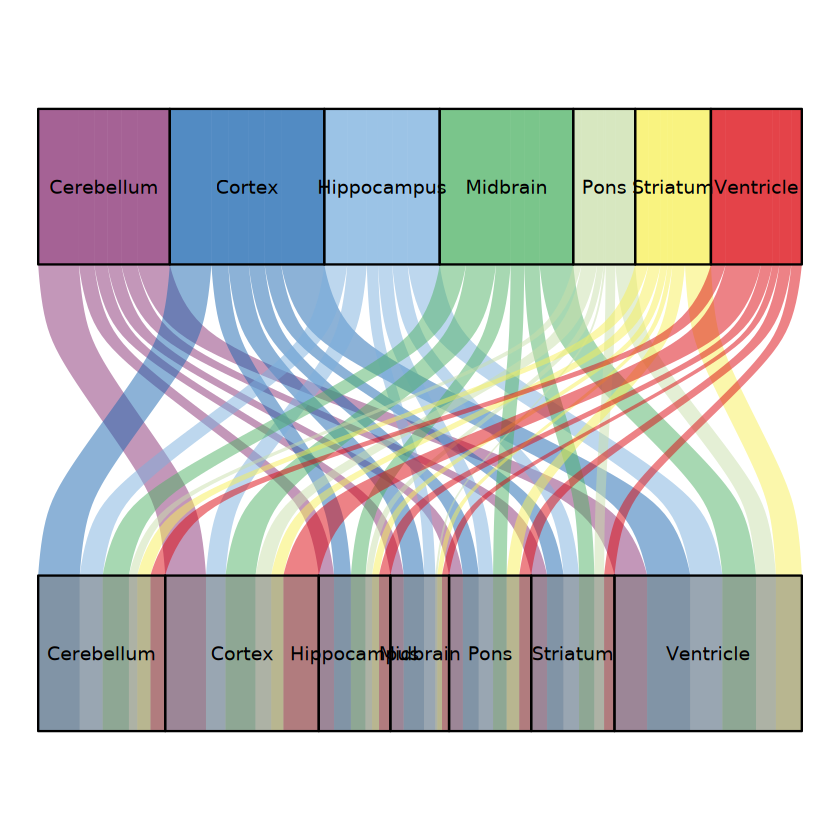

In [91]:
# #df_wide
# areas <- names(df_wide)[-1] 

# combinations <- expand.grid(ismajorT = areas, ismajorF = areas, stringsAsFactors = FALSE)
# combinations$value = 0
# for(i in 1:nrow(combinations)){
#     x <- combinations[i,"ismajorT"]
#     y <- combinations[i,"ismajorF"]
#     df_widei = df_wide[,c(x,y)]
#     df_widei = df_widei[!is.na(df_widei[,1]) & !is.na(df_widei[,2]),]
#     combinations[i,]$value = nrow(df_widei[df_widei[,1] & !df_widei[,2],])
# }
# combinations

df = df_wide
# 生成单细胞组合统计表
result_single <- df %>%
  pivot_longer(-transcript_id, names_to = "cell_type", values_to = "value") %>%
  filter(!is.na(value)) %>%
  group_by(transcript_id) %>%
  summarise(
    T_cells = list(cell_type[value == TRUE]),
    F_cells = list(cell_type[value == FALSE])
  ) %>%
  filter(lengths(T_cells) > 0 & lengths(F_cells) > 0) %>%
  # 拆分单个细胞并计算权重
  mutate(
    T_single = map(T_cells, ~ {
      if(length(.x) > 0) tibble(T_single = .x, t_weight = 1/length(.x))
    }),
    F_single = map(F_cells, ~ {
      if(length(.x) > 0) tibble(F_single = .x, f_weight = 1/length(.x))
    })
  ) %>%
  dplyr::select(-T_cells, -F_cells) %>%
  # 展开单细胞组合
  unnest(T_single, keep_empty = TRUE) %>%
  unnest(F_single, keep_empty = TRUE) %>%
  # 计算标准化频数
  mutate(norm = t_weight * f_weight,count = 1) %>%
  group_by(T_single, F_single) %>%
  summarise(count = sum(count), 
            norm = sum(norm), 
            .groups = "drop") %>%
  # 格式整理
  arrange(desc(count)) %>%
  filter(!is.na(T_single) & !is.na(F_single))

# 查看结果
# print(result_single)
# result_single$T_single = factor(result_single$T_single,suborder)
# result_single$F_single = factor(result_single$F_single,suborder)
library(ggalluvial)
pf1.1 = ggplot(result_single,
                   aes(axis2 = T_single, axis1 = F_single, y = norm, fill = T_single)) +
        scale_x_discrete(expand = c(.1, .1)) +
        geom_alluvium(aes(fill = T_single)) +
        # geom_flow(aes(color = celltype)) +
        #geom_flow(aes(fill = prog)) +
        geom_stratum(alpha = .5) +
        scale_fill_discreterainbow() + 
        geom_text(stat = "stratum", aes(label = after_stat(stratum))) +
coord_flip() + scale_y_reverse() +
theme_void() + theme(legend.position = "none")
pf1.1 

# library(igraph)
# final_results <- result_single %>%
#     mutate(OR = (count / sum(count)) / ((sum(count) - count) / sum(count))) %>%
#   filter(count >= quantile(count, 0.75)) %>%
#   filter(abs(log(OR)) > 1) %>%
#   arrange(desc(count))

# sum(final_results$count)
# pf1.1 = ggplot(result_single,
#                    aes(axis1 = T_single, axis2 = F_single, y = count, fill = T_single)) +
#         scale_x_discrete(expand = c(.1, .1)) +
#         geom_alluvium(aes(fill = T_single)) +
#         # geom_flow(aes(color = celltype)) +
#         #geom_flow(aes(fill = prog)) +
#         geom_stratum(alpha = .5) +
#         scale_fill_discreterainbow() + 
#         geom_text(stat = "stratum", aes(label = after_stat(stratum))) +
# theme_void()
# pf1.1

# 安装并加载 dplyr 包
#install.packages("dplyr")
#library(dplyr)

ggexport(pf1.1,filename = "result/figure6_other_cmp/sigiso_subcortical_isoform_shift_alluv_25_03_10.pdf",
         width = 3.5,height = 5)

In [93]:
result_single[order(-result_single$count),]

T_single    F_single    count norm     
1  Cortex      Ventricle   139   30.941667
2  Midbrain    Ventricle   131   24.116667
3  Hippocampus Ventricle   128   22.958333
4  Cerebellum  Ventricle   123   23.358333
5  Striatum    Ventricle   104   18.583333
6  Cerebellum  Cortex       95   29.200000
7  Cortex      Cerebellum   92   29.791667
8  Midbrain    Cortex       92   21.511111
9  Ventricle   Cortex       91   25.319444
10 Pons        Ventricle    86   14.208333
11 Midbrain    Cerebellum   84   18.802778
12 Hippocampus Cerebellum   76   16.416667
13 Hippocampus Cortex       69   13.991667
14 Cerebellum  Striatum     62   11.366667
15 Midbrain    Striatum     62   10.991667
16 Cortex      Pons         61   11.366667
17 Pons        Cortex       61   11.211111
18 Cortex      Striatum     59   11.841667
19 Hippocampus Pons         58   10.233333
20 Hippocampus Striatum     57   11.058333
21 Cerebellum  Pons         54    9.916667
22 Midbrain    Pons         54    9.741667
23 Striatum    Cerebellum   53    9.483333
24 Ventricle   Cerebellum   53   10.544444
25 Striatum    Cortex       52    8.766667
26 Striatum    Pons         52    9.000000
27 Cerebellum  Hippocampus  51   10.941667
28 Midbrain    Hippocampus  50   10.486111
29 Ventricle   Pons         46    8.575000
30 Pons        Striatum     45    6.950000
31 Ventricle   Hippocampus  45    8.152778
32 Cortex      Midbrain     44   14.666667
33 Ventricle   Striatum     44    7.458333
34 Cortex      Hippocampus  43   12.075000
35 Cerebellum  Midbrain     40    9.500000
36 Pons        Cerebellum   39    5.961111
37 Hippocampus Midbrain     36    8.008333
38 Pons        Hippocampus  30    4.661111
39 Striatum    Hippocampus  26    5.016667
40 Ventricle   Midbrain     25    5.066667
41 Striatum    Midbrain     18    3.383333
42 Pons        Midbrain      8    1.375000

In [ ]:
shiftprop = data.frame()
mkls.region.st$prop = mkls.region.st$genenum / sum(mkls.region.st$genenum)
mkls.region.st$proplabel = paste0(round(mkls.region.st$prop*100,1),"%")
mkls.region.st$group = "region"

mkls.transt = rbind(mkls.layer.st,mkls.lobe.st,mkls.region.st)
mkls.transt
p1.4 = ggplot(mkls.transt[mkls.transt$group == "layer",], aes(x=group, y=prop, fill=transnum)) +
  geom_bar(stat="identity", width = 0.5, color= NA) +
  coord_polar("y", start=0) +
  geom_text(aes(label = proplabel),position = position_stack(0.5), color = "white", size=6) +
  scale_fill_flatui() + theme_void()
p1.4
write.csv(mkls.transt,file = "result/figure2/gene_marker_isoform_heterogeneity_stat_pie_24_12_05.csv")
ggexport(p1.4,filename = "result/figure2/gene_marker_isoform_heterogeneity_stat_pie_24_12_05.pdf",width = 4,height = 5)

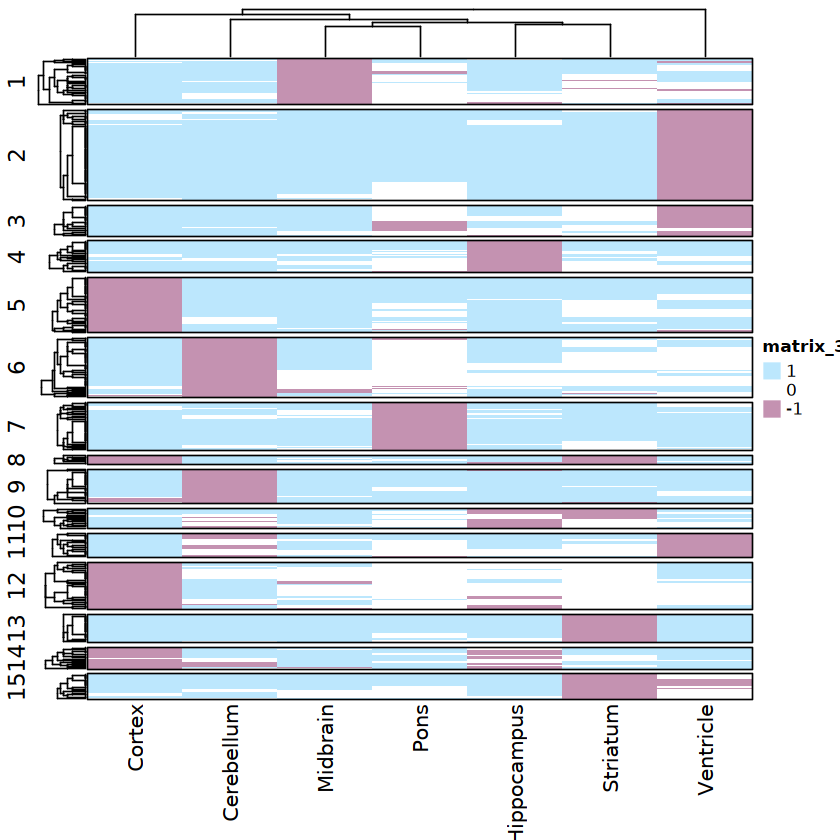

In [26]:
# 转换逻辑值为数值
df_numeric <- df_wide %>%
  mutate(across(
    everything(),
    function(x) {
      x %>%
        replace(is.na(x), 0) %>%  # 将 NA 替换为 0
        replace(x == TRUE, 1) %>%  # 将 TRUE 替换为 1
        replace(x == FALSE, -1)    # 将 FALSE 替换为 -1
    }
  ))

# 查看结果
#print(df_numeric)
df_numeric = as.data.frame(df_numeric)
gtdf = unique(isosigi[,c("gene_id","transcript_id")])
rownames(df_numeric) = gtdf[match(df_numeric$transcript_id,gtdf$transcript_id),]$gene_id
df_numeric = df_numeric[,-1]

dist_na <- function(x) {
  dist(x, method = "euclidean", diag = FALSE, upper = FALSE, p = 2)
}

library(ComplexHeatmap)
n = 15
fit = kmeans(df_numeric,n)
split <- factor(as.character(fit$cluster), levels=as.character(c(1:n)))

ht = Heatmap(as.matrix(df_numeric),show_row_names = F,border = T,row_split = split,
        col = c("#C492B1","white","#BCE7FD"),cluster_row_slices = FALSE,cluster_rows = T)
ht
#ggexport(p,filename = "result/figure6_other_cmp/iso_sig_subclass_subcortical_cor_heatmap_24_11_27.pdf",width = 4,height = 5)

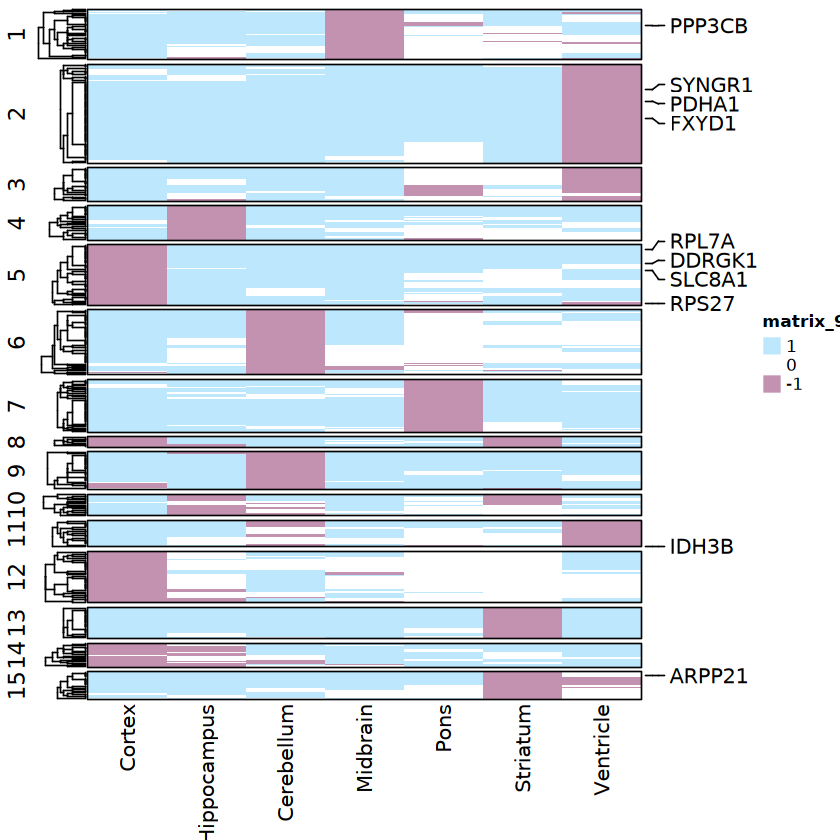

In [44]:
colorder = c("Cortex","Hippocampus","Cerebellum","Midbrain","Pons","Striatum","Ventricle")
annoid = c("ARPP19","ARPP21","DDRGK1","RPS27","PPP3CB","IDH3B","SYNGR1","FXYD1","EPB41","PDHA1","SLC8A1","RPL7A")
df_numeric = df_numeric[,colorder]
ha = rowAnnotation(foo =  anno_mark(at = which(rownames(df_numeric) %in% annoid), 
                                    labels = rownames(df_numeric)[which(rownames(df_numeric) %in% annoid)]))
Heatmap(as.matrix(df_numeric),show_row_names = F,border = T,row_split = split,cluster_columns = F,
        col = c("#C492B1","white","#BCE7FD"),cluster_row_slices = FALSE,cluster_rows = T,
        right_annotation = ha,row_names_side = "left", row_names_gp = gpar(fontsize = 4))

file saved to result/figure6_other_cmp/sigiso_subcortical_isoform_shift_cluster_heatmap_clone_25_03_10.pdf



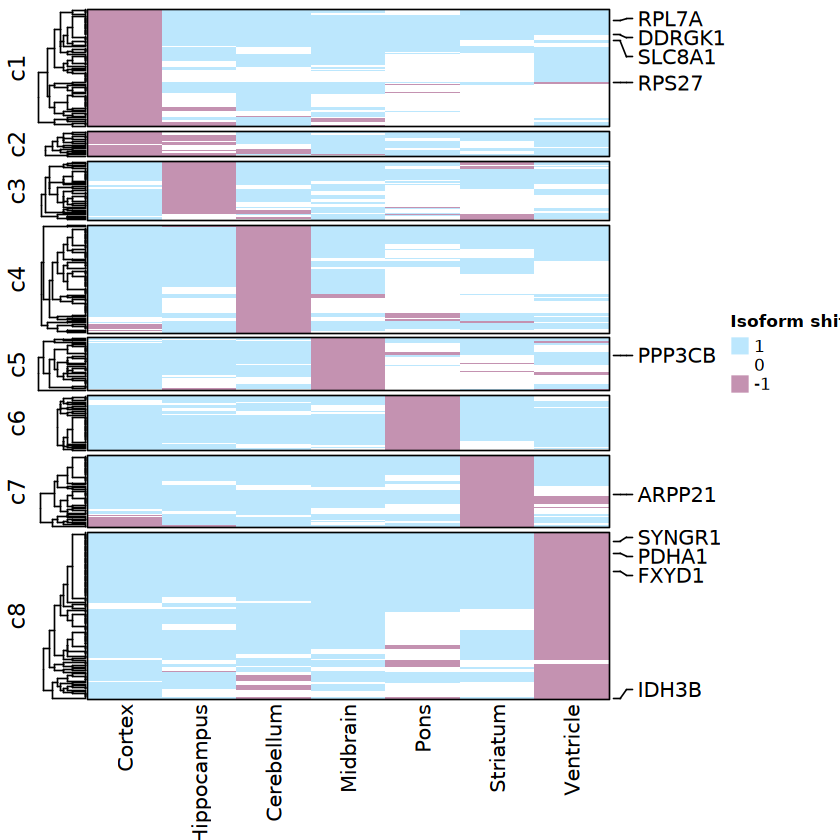

In [73]:
clist = list("c1" = c(5,12),"c2" = c(14),"c3" = c(4,10),"c4" = c(6,9),"c5" = c(1),
             "c6" = c(7),"c7" = c(13,15,8),"c8" = c(2,3,11))

MergeCluster = function(htls,clist){
  #merge cluster
  split = as.character(htls$rowcluster)
  for (i in 1:length(clist)) {
    split[which(as.character(split) %in% as.character(clist[[i]]))] = names(clist)[i]
  }
  # 
  split = factor(as.character(split), levels = names(clist))
  names(split) = names(htls$rowcluster)
  reorder.hmap = Heatmap(htls$ht@matrix, 
                         name = "delta Isoform\n ratio",
                         row_split = split,
                         # cluster_rows = F,
                         cluster_columns = F,
                         cluster_row_slices = FALSE,
                         #cluster_column_slices = FALSE,
                         show_row_names = F,
                         col = colorRamp2(c(-0.4,0,0.4), 
                                          c("#08306B", "white", "red")),
                         column_order = htls$colorder
  )
  reorder.hmap
  htls$rowcluster = split
  htls$ht = reorder.hmap
  return(htls)
}
htls = list(rowcluster = split,ht = ht,colorder = colorder)
htls = MergeCluster(htls,clist)
htmx = htls$ht@matrix
ha = rowAnnotation(foo =  anno_mark(at = which(rownames(df_numeric) %in% annoid), 
                                    labels = rownames(df_numeric)[which(rownames(df_numeric) %in% annoid)]))
pclonehti2 = Heatmap(htmx, name = "Isoform shift",
                         row_split = htls$rowcluster,
                         # cluster_rows = F,
                         cluster_columns = F,
                         cluster_row_slices = FALSE,
                         #cluster_column_slices = FALSE,
                         show_row_names = F,
                         col = c("#C492B1","white","#BCE7FD"),
                         column_order = htls$colorder,
                         border = TRUE,right_annotation = ha,row_names_side = "left")
pclonehti2
ggexport(pclonehti2,filename = "result/figure6_other_cmp/sigiso_subcortical_isoform_shift_cluster_heatmap_clone_25_03_10.pdf",
         width =7,height = 7)

In [60]:
isosigt = isosigls$subcortical
isosigt[isosigt$gene_id %in% "DISP2",]

gene_id transcript_id  areatr      count genecount relative  
17789 DISP2   DISP2-WeiLab-1 Cerebellum  109    204      0.53431373
17790 DISP2   DISP2-WeiLab-1 Cortex      154   1087      0.14167433
17791 DISP2   DISP2-WeiLab-1 Hippocampus   1     22      0.04545455
17792 DISP2   DISP2-WeiLab-1 Midbrain      4     54      0.07407407
17793 DISP2   XM_005559173.2 Cerebellum   95    204      0.46568627
17794 DISP2   XM_005559173.2 Cortex      933   1087      0.85832567
17795 DISP2   XM_005559173.2 Hippocampus  21     22      0.95454545
17796 DISP2   XM_005559173.2 Midbrain     50     54      0.92592593
      meanrelative otherrelative dr          sig  pvalue       padj        
17789 0.1988792    0.08706765     0.44724607 Up   4.436925e-38 1.946583e-36
17790 0.1988792    0.21794745    -0.07627312 N    4.436925e-38 1.946583e-36
17791 0.1988792    0.25002071    -0.20456617 N    4.436925e-38 1.946583e-36
17792 0.1988792    0.24048087    -0.16640679 N    4.436925e-38 1.946583e-36
17793 0.8011208    0.91293235    -0.44724607 Down 4.436925e-38 1.946583e-36
17794 0.8011208    0.78205255     0.07627312 N    4.436925e-38 1.946583e-36
17795 0.8011208    0.74997929     0.20456617 Up   4.436925e-38 1.946583e-36
17796 0.8011208    0.75951913     0.16640679 Up   4.436925e-38 1.946583e-36

In [58]:
shiftgcl = data.frame("gene_id" = rownames(df_numeric),"cluster" = htls$rowcluster)
hubiso = isosigi[isosigi$gene_id %in% shiftgcl[as.character(shiftgcl$cluster) == "c4",]$gene_id,]
hubiso = hubiso[hubiso$sig != "N" & hubiso$areatr == "Cerebellum" & abs(hubiso$dr) > 0.2,]
hubiso
#hubiso[hubiso$gene_id %in% "DISP2",]

gene_id         transcript_id            areatr     count genecount
1  BambuGene125645 BambuGene125645-WeiLab-1 Cerebellum  14    41      
2  BambuGene6150   BambuGene6150-WeiLab-3   Cerebellum  23    53      
3  BRF2            NM_001284122.1           Cerebellum  42    96      
4  C19H19orf47     C19H19orf47-WeiLab-1     Cerebellum  19    62      
5  DAPK2           XM_005559755.2           Cerebellum  15    39      
6  DISP2           XM_005559173.2           Cerebellum  95   204      
7  FBXO27          NM_001284024.1           Cerebellum  17    38      
8  IFT74           NM_001284974.1           Cerebellum  16    63      
9  KCNK4           XM_015434524.1           Cerebellum  28    68      
10 LOC102133863    LOC102133863-WeiLab-1    Cerebellum 101   285      
11 LOC102145582    XR_001487224.1           Cerebellum  14    58      
12 LOC107130717    LOC107130717-WeiLab-1    Cerebellum  25    57      
13 LRRC4C          XM_005578156.2           Cerebellum  45   113      
14 MLH1            XM_005546625.2           Cerebellum  16    36      
15 NAT16           XM_015447191.1           Cerebellum  14    35      
16 P2RX6           XM_005567913.2           Cerebellum  12    48      
17 PLCB3           XM_015434525.1           Cerebellum  15    35      
18 PLD5            XM_005539658.2           Cerebellum  25    59      
19 SCRN2           XM_005583518.2           Cerebellum  46   122      
20 SERPINB9        XM_005554163.2           Cerebellum  11    35      
21 SPA17           SPA17-WeiLab-1           Cerebellum  11    24      
22 SRRD            XM_005567728.2           Cerebellum  71   169      
23 STK38           XM_005553164.2           Cerebellum  26    60      
24 TAF9B           TAF9B-WeiLab-1           Cerebellum  16    39      
25 XPNPEP3         XM_005567171.2           Cerebellum  17    49      
26 ZCRB1           ZCRB1-WeiLab-1           Cerebellum 143   334      
27 ZNF71           XM_015441569.1           Cerebellum  11    44      
   relative  meanrelative otherrelative dr         sig  pvalue      
1  0.3414634 0.5693312    0.6262981     -0.2848347 Down 9.064172e-03
2  0.4339623 0.7010237    0.9680851     -0.5341228 Down 7.954143e-13
3  0.4375000 0.6116627    0.6552034     -0.2177034 Down 8.517855e-04
4  0.3064516 0.5150100    0.5845294     -0.2780778 Down 9.625219e-30
5  0.3846154 0.5128205    0.6410256     -0.2564103 Down 9.889572e-04
6  0.4656863 0.8011208    0.9129323     -0.4472461 Down 4.436925e-38
7  0.4473684 0.6272526    0.6722236     -0.2248552 Down 9.782277e-03
8  0.2539683 0.5201728    0.5734137     -0.3194455 Down 5.140140e-05
9  0.4117647 0.5702423    0.6230682     -0.2113035 Down 1.642027e-03
10 0.3543860 0.6450286    0.6934690     -0.3390831 Down 1.786780e-15
11 0.2413793 0.4774505    0.5954861     -0.3541068 Down 2.808577e-05
12 0.4385965 0.6117116    0.6694166     -0.2308201 Down 9.484489e-03
13 0.3982301 0.7210776    0.7856471     -0.3874170 Down 3.229350e-80
14 0.4444444 0.6093144    0.6505319     -0.2060875 Down 8.497647e-03
15 0.4000000 0.6082717    0.7124075     -0.3124075 Down 3.529630e-04
16 0.2500000 0.7787149    0.9108936     -0.6608936 Down 4.491238e-37
17 0.4285714 0.5921881    0.6739965     -0.2454250 Down 1.928375e-02
18 0.4237288 0.6267580    0.8297872     -0.4060584 Down 4.864116e-07
19 0.3770492 0.5948199    0.6311150     -0.2540658 Down 1.150946e-04
20 0.3142857 0.5086010    0.6057586     -0.2914729 Down 9.927913e-03
21 0.4583333 0.6498424    0.6977197     -0.2393864 Down 3.882456e-04
22 0.4201183 0.6062793    0.6373061     -0.2171878 Down 1.702510e-04
23 0.4333333 0.5946358    0.6349614     -0.2016281 Down 9.553633e-04
24 0.4102564 0.5420076    0.6737589     -0.2635025 Down 2.377149e-03
25 0.3469388 0.5838126    0.6627706     -0.3158318 Down 1.209815e-04
26 0.4281437 0.6196979    0.6516236     -0.2234799 Down 9.751823e-10
27 0.2500000 0.5381737    0.8263473     -0.5763473 Down 9.733218e-22
   padj         ismajor
1  2.179206e-02 FALSE  
2  1.014522e-11 FALSE  
3  2.757271

In [105]:
df = df_wide
# 生成单细胞组合统计表
result_single <- df %>%
  pivot_longer(-transcript_id, names_to = "cell_type", values_to = "value") %>%
  filter(!is.na(value)) %>% 


  group_by(transcript_id) %>%
  summarise(
    T_cells = list(cell_type[value == TRUE]),
    F_cells = list(cell_type[value == FALSE])
  ) %>%
  filter(lengths(T_cells) > 0 & lengths(F_cells) > 0) %>%
  # 拆分单个细胞并计算权重
  mutate(
    T_single = map(T_cells, ~ {
      if(length(.x) > 0) tibble(T_single = .x, t_weight = 1/length(.x))
    }),
    F_single = map(F_cells, ~ {
      if(length(.x) > 0) tibble(F_single = .x, f_weight = 1/length(.x))
    })
  ) %>%
  select(-T_cells, -F_cells) %>%
  # 展开单细胞组合
  unnest(T_single, keep_empty = TRUE) %>%
  unnest(F_single, keep_empty = TRUE) %>%
  # 计算标准化频数
  mutate(count = t_weight * f_weight) %>%
  group_by(F_single) %>%
  mutate(F_isonum = length(unique(transcript_id))) %>%
  group_by(T_single, F_single) %>%
  summarise(count = sum(count), .groups = "drop", 
            isonum = length(unique(transcript_id)),F_isonum = unique(F_isonum)) %>%
  # 格式整理
  arrange(desc(count)) %>%
  filter(!is.na(T_single) & !is.na(F_single))


# 查看结果
print(result_single)
library(ggalluvial)
result_single$celltype = result_single$F_single

# A tibble: 42 × 5
   T_single    F_single   count isonum F_isonum
   <chr>       <chr>      <dbl>  <int>    <int>
 1 Cortex      Ventricle   30.9    139      151
 2 Cortex      Cerebellum  29.8     92      109
 3 Cerebellum  Cortex      29.2     95      132
 4 Ventricle   Cortex      25.3     91      132
 5 Midbrain    Ventricle   24.1    131      151
 6 Cerebellum  Ventricle   23.4    123      151
 7 Hippocampus Ventricle   23.0    128      151
 8 Midbrain    Cortex      21.5     92      132
 9 Midbrain    Cerebellum  18.8     84      109
10 Striatum    Ventricle   18.6    104      151
# ℹ 32 more rows


In [56]:
head(result_single)

T_single    F_single   count    isonum F_isonum celltype  
1 Cortex      Ventricle  25.68333 103    104      Ventricle 
2 Cortex      Cerebellum 22.21944  59     63      Cerebellum
3 Cerebellum  Ventricle  16.40000  86    104      Ventricle 
4 Cerebellum  Cortex     15.26667  48     67      Cortex    
5 Midbrain    Ventricle  15.25833  85    104      Ventricle 
6 Hippocampus Ventricle  15.02500  87    104      Ventricle

file saved to result/figure6_other_cmp/sigiso_subcortical_isoform_shift_stat_25_03_01.pdf



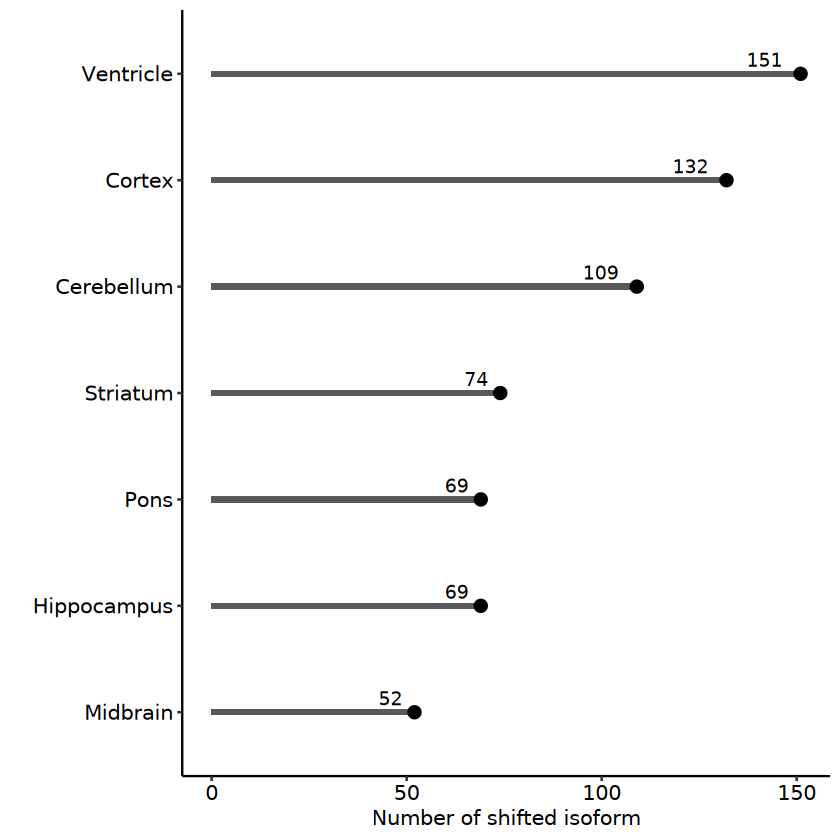

In [107]:
result_single.st = unique(result_single[,c("F_single","F_isonum")])
# head(result_single.st)
# ggplot(result_single,aes(x = T_single, y = F_single,size = isonum,color = log(count))) + geom_point() + 
# scale_color_viridis(option = "A") + coord_fixed() + theme_bw()
#result_single.st = result_single.st[order(result_single.st),]
result_single.st = result_single.st[order(result_single.st$F_isonum),]
result_single.st$F_single = factor(result_single.st$F_single,levels = unique(result_single.st$F_single))
p2 = ggplot(result_single.st,aes(y = F_single,x = F_isonum)) + 
    geom_bar(stat = "identity",width = 0.05) + 
    geom_point(size = 3) +
    geom_text(aes(label = F_isonum),hjust = 1.5,vjust = -0.5) +
    scale_fill_viridis(option = "A") + theme_pubr() + ylab("") + xlab("Number of shifted isoform")
p2
ggexport(p2,filename = "result/figure6_other_cmp/sigiso_subcortical_isoform_shift_stat_25_03_01.pdf",
         width = 3,height = 4)

GRanges object with 6 ranges and 8 metadata columns:
         seqnames    ranges strand |   source       type     score     phase
            <Rle> <IRanges>  <Rle> | <factor>   <factor> <numeric> <integer>
  [1] NC_012670.1  620-2452      + |    Bambu transcript        NA      <NA>
  [2] NC_012670.1  620-1566      + |    Bambu exon              NA      <NA>
  [3] NC_012670.1 1633-2452      + |    Bambu exon              NA      <NA>
  [4] NC_012670.1 1637-2483      - |    Bambu transcript        NA      <NA>
  [5] NC_012670.1 1637-2300      - |    Bambu exon              NA      <NA>
  [6] NC_012670.1 2354-2483      - |    Bambu exon              NA      <NA>
              gene_id          transcript_id        transcript_name exon_number
          <character>            <character>            <character> <character>
  [1] BambuGene146379 BambuGene146379-WeiL.. BambuGene146379-WeiL..        <NA>
  [2] BambuGene146379 BambuGene146379-WeiL.. BambuGene146379-WeiL..           1
  [3] Bambu

`summarise()` has grouped output by 'areatr'. You can override using the
`.groups` argument.


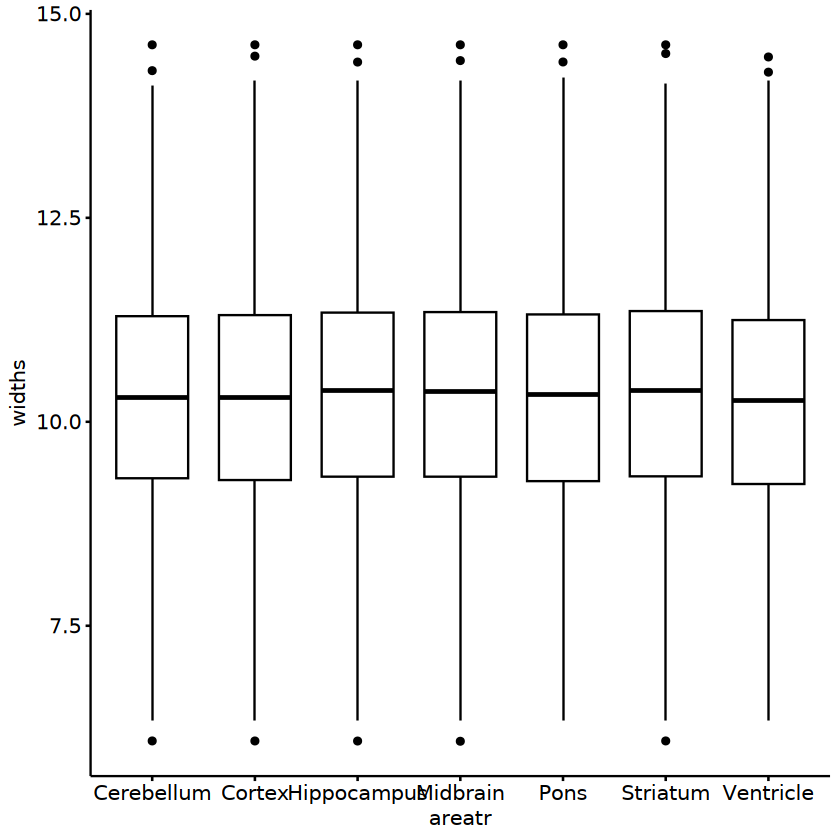

In [181]:
#isoform length stat
head(gtf)
gtfdf = as.data.frame(gtf)
gtfdf$width = width(gtf)
gtfdf = gtfdf[gtfdf$type == "transcript",]
isosigi = isosigls$subcortical
hubgene = unique(isosigi[isosigi$sig != "N",]$gene_id)
isosigi = isosigi[isosigi$gene_id %in% hubgene,]
isosigi = merge(isosigi,gtfdf[,c("transcript_id","width")],by = "transcript_id")
isowidth = isosigi %>% group_by(areatr,gene_id) %>% summarise(widths = log(sum(relative * width)))
ggboxplot(isowidth,x = "areatr",y = "widths")

### Case plot

In [228]:
isosigi = isosigls$subcortical
isosighub = isosigi[isosigi$sig != "N",]
write.csv(isosighub,file = "result/figure6_other_cmp/isosig_subcortical_ls_24_11_27.csv")

In [432]:
#plot case list
isosigi = isosigls$subcortical
isosighub = isosigi[isosigi$sig != "N",]
gmksi = unique(isosighub$gene_id)
pcls.subc = list()
for(i in 1:length(gmksi)){
    print(i)
    grtdfl = BuildPlotBed(fsrawdp,longbed,"subcortical",gmksi[i],NULL)
    pcls.subc[[i]] = tryCatch(IsoformReadPlot(gtf, grtdfl, gmksi[i],onlyhub = T), 
                                                  error = function(e) NULL)
                               
}
  # ggexport(parcl_casels
ggexport(pcls.subc,filename = "result/figure6_other_cmp/dtu_case_ls_subcortical_24_03_30.pdf",
           width = 10,height = 8)

[1] 1


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 2


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 3


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 4


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 5


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 6


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 7


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 8


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 9


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 10


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 11


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 12


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 13


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 14


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 15


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 16


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 17


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 18


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 19


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 20


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 21


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 22


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 23


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 24


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 25


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 26


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 27


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 28


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 29


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 30


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 31


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 32


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 33


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 34


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 35


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 36


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 37


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 38


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 39


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 40


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 41


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 42


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 43


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 44


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 45


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 46


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 47


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 48


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 49


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 50


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 51


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 52


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 53


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 54


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 55


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 56


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 57


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 58


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 59


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 60


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 61


Warning message:
"There were 2 warnings in `summarise()`.
The first warning was:
ℹ In argument: `start = min(start)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning."
`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message in min(tartranstx$start):
"no non-missing arguments to min; returning Inf"
Warning message in max(tartranstx$end):
"no non-missing arguments to max; returning -Inf"


[1] 62


Warning message:
"There were 2 warnings in `summarise()`.
The first warning was:
ℹ In argument: `start = min(start)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning."
`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message in min(tartranstx$start):
"no non-missing arguments to min; returning Inf"
Warning message in max(tartranstx$end):
"no non-missing arguments to max; returning -Inf"


[1] 63


Warning message:
"There were 2 warnings in `summarise()`.
The first warning was:
ℹ In argument: `start = min(start)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning."
`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message in min(tartranstx$start):
"no non-missing arguments to min; returning Inf"
Warning message in max(tartranstx$end):
"no non-missing arguments to max; returning -Inf"


[1] 64


Warning message:
"There were 2 warnings in `summarise()`.
The first warning was:
ℹ In argument: `start = min(start)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning."
`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message in min(tartranstx$start):
"no non-missing arguments to min; returning Inf"
Warning message in max(tartranstx$end):
"no non-missing arguments to max; returning -Inf"


[1] 65


Warning message:
"There were 2 warnings in `summarise()`.
The first warning was:
ℹ In argument: `start = min(start)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning."
`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message in min(tartranstx$start):
"no non-missing arguments to min; returning Inf"
Warning message in max(tartranstx$end):
"no non-missing arguments to max; returning -Inf"


[1] 66


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 67


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 68


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 69


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 70


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 71


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 72


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 73


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 74


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 75


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 76


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 77


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 78


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 79


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 80


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 81


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 82


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 83


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 84


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 85


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 86


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 87


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 88


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 89


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 90


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 91


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 92


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 93


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 94


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 95


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 96


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 97


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 98


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 99


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 100


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 101


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 102


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 103


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 104


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 105


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 106


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 107


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 108


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 109


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 110


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 111


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 112


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 113


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 114


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 115


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 116


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 117


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 118


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 119


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 120


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 121


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 122


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 123


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 124


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 125


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 126


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 127


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 128


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 129


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 130


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 131


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 132


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 133


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 134


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 135


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 136


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 137


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 138


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 139


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 140


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 141


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 142


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 143


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 144


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 145


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 146


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 147


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 148


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 149


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 150


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 151


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 152


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 153


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 154


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 155


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 156


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 157


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 158


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 159


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 160


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 161


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 162


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 163


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 164


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 165


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 166


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 167


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 168


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 169


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 170


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 171


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 172


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 173


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 174


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 175


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 176


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 177


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 178


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 179


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 180


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 181


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 182


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 183


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 184


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 185


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 186


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 187


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 188


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 189


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 190


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 191


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 192


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 193


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 194


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 195


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 196


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 197


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 198


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 199


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 200


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 201


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 202


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 203


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 204


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 205


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 206


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 207


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 208


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 209


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 210


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 211


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 212


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 213


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 214


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 215


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 216


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 217


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 218


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 219


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 220


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 221


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 222


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 223


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 224


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 225


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 226


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 227


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 228


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 229


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 230


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 231


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 232


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 233


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 234


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 235


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 236


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 237


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 238


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 239


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 240


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 241


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 242


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 243


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 244


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 245


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 246


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 247


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 248


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 249


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 250


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 251


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 252


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 253


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 254


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 255


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 256


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 257


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 258


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 259


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 260


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 261


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 262


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 263


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 264


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 265


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 266


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 267


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 268


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 269


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 270


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 271


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 272


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 273


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 274


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 275


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 276


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 277


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 278


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 279


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 280


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 281


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 282


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 283


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 284


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 285


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 286


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 287


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 288


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 289


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 290


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 291


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 292


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 293


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 294


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 295


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 296


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 297


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 298


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 299


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 300


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 301


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 302


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 303


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 304


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 305


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 306


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 307


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 308


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 309


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 310


Warning message:
"There were 2 warnings in `summarise()`.
The first warning was:
ℹ In argument: `start = min(start)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning."
`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message in min(tartranstx$start):
"no non-missing arguments to min; returning Inf"
Warning message in max(tartranstx$end):
"no non-missing arguments to max; returning -Inf"


[1] 311


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 312


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 313


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 314


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 315


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 316


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 317


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 318


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 319


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 320


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 321


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 322


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 323


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 324


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 325


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 326


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 327


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 328


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 329


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 330


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 331


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 332


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 333


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 334


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 335


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 336


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 337


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 338


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 339


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 340


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 341


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 342


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 343


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 344


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 345


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 346


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 347


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 348


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 349


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 350


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 351


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 352


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 353


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 354


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 355


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 356


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 357


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 358


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 359


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 360


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 361


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 362


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 363


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 364


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 365


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 366


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 367


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 368


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 369


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 370


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 371


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 372


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 373


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 374


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 375


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 376


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 377


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 378


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 379


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 380


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 381


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 382


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 383


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 384


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 385


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 386


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 387


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 388


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 389


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 390


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 391


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 392


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 393


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 394


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 395


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 396


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 397


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 398


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 399


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 400


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 401


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 402


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 403


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 404


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 405


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 406


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 407


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 408


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 409


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 410


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 411


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 412


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 413


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 414


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 415


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 416


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 417


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 418


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 419


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 420


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 421


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 422


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 423


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 424


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 425


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 426


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 427


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 428


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 429


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 430


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 431


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 432


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 433


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 434


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 435


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 436


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 437


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 438


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 439


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 440


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 441


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 442


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 443


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 444


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 445


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 446


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 447


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 448


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 449


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 450


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 451


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 452


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 453


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 454


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 455


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 456


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 457


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 458


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 459


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 460


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 461


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 462


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 463


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 464


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 465


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 466


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 467


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 468


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 469


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 470


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 471


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 472


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 473


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 474


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 475


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 476


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 477


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 478


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 479


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 480


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 481


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 482


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 483


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 484


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 485


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 486


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 487


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 488


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 489


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 490


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 491


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 492


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 493


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 494


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 495


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 496


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 497


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 498


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 499


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 500


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 501


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 502


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 503


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 504


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 505


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 506


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 507


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 508


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 509


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 510


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 511


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 512


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 513


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 514


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 515


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 516


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 517


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 518


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 519


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 520


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 521


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 522


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 523


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 524


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 525


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 526


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 527


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 528


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 529


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 530


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 531


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 532


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 533


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 534


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 535


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 536


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 537


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 538


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 539


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 540


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 541


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 542


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 543


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 544


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 545


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 546


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 547


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 548


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 549


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 550


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 551


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 552


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 553


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 554


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 555


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 556


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 557


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 558


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 559


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 560


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 561


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 562


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 563


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 564


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 565


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 566


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 567


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 568


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 569


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 570


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 571


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 572


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 573


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 574


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 575


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 576


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 577


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 578


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 579


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 580


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 581


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 582


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 583


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 584


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 585


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 586


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 587


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 588


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 589


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 590


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 591


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 592


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 593


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 594


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 595


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 596


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 597


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 598


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 599


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 600


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 601


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 602


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 603


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 604


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 605


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 606


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 607


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 608


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 609


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 610


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 611


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 612


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 613


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 614


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 615


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 616


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 617


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 618


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 619


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 620


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 621


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 622


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 623


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 624


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 625


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 626


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 627


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 628


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 629


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 630


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 631


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 632


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 633


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 634


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 635


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 636


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 637


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 638


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 639


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 640


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 641


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 642


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 643


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 644


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 645


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 646


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 647


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 648


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 649


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 650


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 651


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 652


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 653


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 654


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 655


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.


[1] 656


`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead."
Warning message:
"Removed 140 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 99 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 37 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 55 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 34 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 19 rows containing

In [93]:
pref = qread("../ref/area_figure_an.qs")

#fsrawdp.cellb = qread("data//reads_full_anotation/longread_cell_position_24_03_29.qs")
fsrawdp.cell = fsrawdp %>% 
    group_by(x,y,gene_id,transcript_id,subcortical) %>%
    summarise(readnum = length(unique(readid)))
fsrawdp.cellb = unique(fsrawdp.cell[c("x","y")])
qsave(fsrawdp.cellb,file = "data/reads_full_anotation/longread_cell_position_with_subcortical_24_05_02.qs")
qsave(fsrawdp.cell,file = "data/reads_full_anotation/longread_cell_isoform_with_subcortical_24_05_02.qs")

`summarise()` has grouped output by 'x', 'y', 'gene_id', 'transcript_id'. You
can override using the `.groups` argument.


In [10]:
fsrawdp.cellb = qread("data/reads_full_anotation/longread_cell_position_with_subcortical_24_05_02.qs")
fsrawdp.cell = qread("data/reads_full_anotation/longread_cell_isoform_with_subcortical_24_03_29.qs")

In [27]:
fsrawdp.cell = fsrawdp %>% 
    group_by(x,y,gene_id,transcript_id,subcortical) %>%
    summarise(readnum = length(unique(readid)))

tmp = which(MySplit(fsrawdp.cell$transcript_id,"-",1) == fsrawdp.cell$transcript_id)
fsrawdp.cell[tmp,]$transcript_id = paste0(fsrawdp.cell[tmp,]$gene_id,"-",fsrawdp.cell[tmp,]$transcript_id)
head(fsrawdp.cell)
qsave(fsrawdp.cell,file = "data/reads_full_anotation/longread_cell_isoform_with_subcortical_dp_24_05_16.qs")

`summarise()` has grouped output by 'x', 'y', 'gene_id', 'transcript_id'. You
can override using the `.groups` argument.


x    y     gene_id  transcript_id           subcortical readnum
1 3361 32286 MGP      MGP-XM_005570218.2      Cortex      2      
2 3361 32360 SERPINF1 SERPINF1-NM_001283364.1 Cortex      1      
3 3361 32379 RPL26L1  RPL26L1-XM_005558537.2  Cortex      3      
4 3361 32460 RPLP0    RPLP0-NM_001283935.1    Cortex      1      
5 3361 32463 EIF4G3   EIF4G3-XM_015441343.1   Cortex      1      
6 3361 32516 ABCB9    ABCB9-XM_015431731.1    Cortex      1

In [440]:
#special case plot
hubgene = c("ARPP19","CD164L2","CLTA","CLTB","DDRGK1","FXYD1","GPX4","IDH3B","MYL6","NKX6-2","NUTF2","PDHA1","RPS27","TNNC1")
plmkt.sp = list()
for (i in 1:length(hubgene)) {
    plmkt.sp[[i]] = MarkerSpPlot(fsrawdp.cell,fsrawdp.cellb,hubgene[i],NULL)
}
#plmkt.spt = ggarrange(plotlist = plmkt.sp,nrow = 1)
#plmkt.spt
ggexport(plmkt.sp,
        filename = "result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_24_04_17.pdf",
        width = 4,height = 6)

file saved to result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_24_04_17.pdf



In [113]:
#head(subcoran)
pref = qread("../ref/area_figure_an.qs")
subcoran = unique(fsraw.cor[,c("region","subcortical")])
edgesdf = pref$areaedges
edgesdf[edgesdf$areaid == "1/2",]$areaid = "1|2"
edgesdf = merge(edgesdf,subcoran,by.x = "areaid",by.y = "region")
mycolor = distinctColorPalette(length(unique(edgesdf$subcortical)))
names(mycolor) = unique(edgesdf$subcortical)


#head(edgesdf)
#backpt = qread("longread_cell_isoform_")

In [138]:
a = c(1,2,3,4,5,6,7)
b = c(5,3,2)
a[a %in% b]

[1] 2 3 5

In [251]:
SpCasePlot = function(fsraw.cor,geneex,hubtrans,ptsize = 1,mycolor,downsample = 0){
    mkdf = fsraw.cor[fsraw.cor$gene_id == geneex,]
    if(downsample != 0){
        mkdf = mkdf[sample(1:nrow(mkdf),size = as.integer(downsample*nrow(mkdf)),replace = F),]
    }
    # if(nrow(mkdf) > 3000){
    #     mkdf = mkdf[sample(1:nrow(mkdf),size = 3000,replace = F),]
    # }
    mkdf$transtype = MySplit(mkdf$transcript_id,"-",1)
    mkdf[mkdf$transtype != MySplit(mkdf$gene_id,"-",1),]$transcript_id = 
    paste0(mkdf[mkdf$transtype != MySplit(mkdf$gene_id,"-",1),]$gene_id,"-",
           mkdf[mkdf$transtype != MySplit(mkdf$gene_id,"-",1),]$transcript_id)
    hubtrans = hubtrans[hubtrans %in% mkdf$transcript_id]
    mkdf = mkdf[mkdf$transcript_id %in% hubtrans,]
    # mkdf.st = mkdf %>% group_by(transcript_id) %>% summarise(count = length(readid))
    # mkdf.st = mkdf.st[order(mkdf.st$count),]
    # transorder = unique(mkdf.st$transcript_id)
    mkdf$transcript_id = factor(mkdf$transcript_id,levels = hubtrans)
    mkdf = mkdf[order(-as.numeric(mkdf$transcript_id)),]
    #mkdf = mkdf[order(mkdf$transcript_id),]
    
    pmkpti1 = ggplot() +
        geom_segment(data = edgesdf, 
                   aes(x = x1, y = y1, xend = x2, yend = y2,color = subcortical),
                   size = 0.2,alpha = 1) +
      geom_point(data = mkdf,
                 aes(x,y,fill = transcript_id),shape = 21,size = ptsize,stroke = NA) + 
      # geom_segment(data = edgesdf, aes(x = x1, y = y1, xend = x2, yend = y2,color = areatr),
      #            size = 0.5,alpha = 0.75) + 
     # scale_size(range = c(0.05,0.1)) +
      #facet_wrap(~layer,nrow = 2) 

      theme_void() +
      #scale_fill_discreterainbow() +
      scale_color_flatui() +
      scale_fill_manual(values = mycolor) +
      #scale_color_manual(values = mycolor) +
      #scale_color_flatui() +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 8)) +
      guides(color = "none",
            fill = guide_legend(override.aes = list(size=6),nrow = 2),size = 7) +
      scale_y_reverse() + scale_x_reverse()
    return(pmkpti1)
}


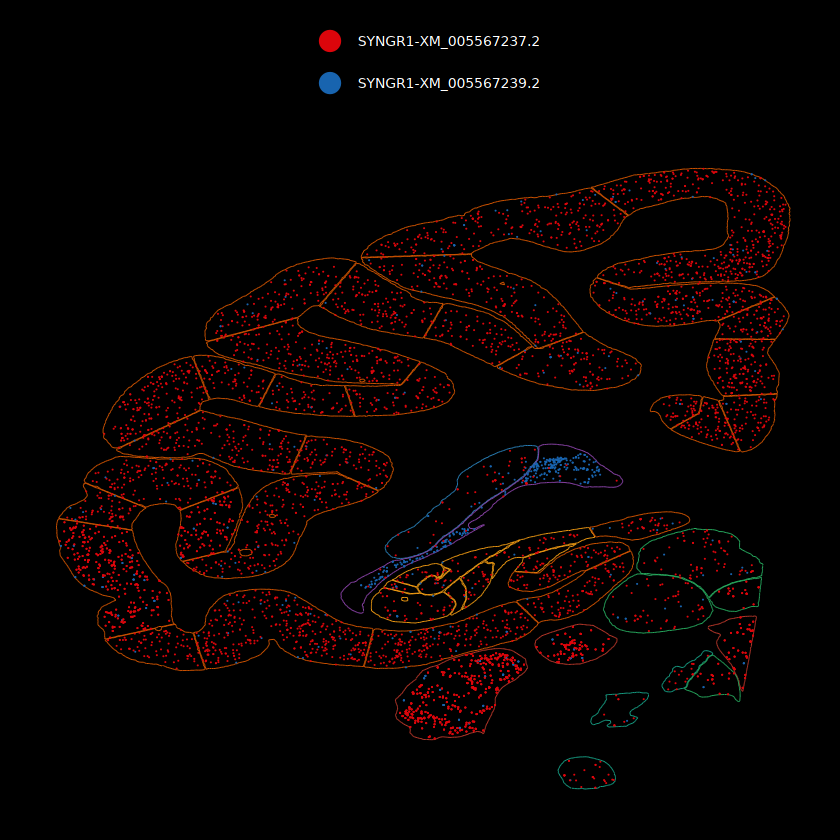

In [175]:
geneex = "SYNGR1"
mycolor =  c('#DC050B','#1864AF','#F7EF55')
hubtrans = c("ARPP19-NM_001283415.1","ARPP19-XM_015452432.1",
             "DDRGK1-WeiLab-1","DDRGK1-XM_005568473.2",
             "ARPP21-XM_005545496.2","ARPP21-XM_005545480.2","ARPP21-XM_015444956.1",
             "FXYD1-XM_005588819.1","FXYD1-XM_005588818.2",
             "IDH3B-XM_005568512.1","IDH3B-XM_005568513.1",
             "EPB41-XM_005544192.2","EPB41-XM_005544198.2",
             "MYL6-WeiLab-2","MYL6-WeiLab-1",
             "TSTD1-XM_005541224.2","TSTD1-XM_005541226.2",
             "GPX4-WeiLab-2","GPX4-XM_005587358.2",
             "NKX6-2-WeiLab-1","NKX6-2-WeiLab-3",
             "PDHA1-WeiLab-1","PDHA1-XM_005593119.2",
             "RPS27-XM_005541720.2","RPS27-WeiLab-1",
            "SYNGR1-XM_005567237.2","SYNGR1-XM_005567239.2",
            "PPP3CB-XM_015455847.1","PPP3CB-XM_015455855.1",
            "SLC8A1-XM_005576034.2","SLC8A1-XM_005576035.2",
            "RPL7A-NM_001284957.1","RPL7A-WeiLab-1")
#fileid = paste0("result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_",geneex,"_24_05_02.pdf")
#hubtrans = c("XM_015452432.1","NM_001283415.1")
# hubtrans = c("ARPP19-NM_001283415.1","ARPP19-XM_015452432.1","FXYD1-XM_005588818.2","FXYD1-XM_005588819.1",
#              "GPX4-WeiLab-2","GPX4-XM_005587358.2",
#             "MYL6-WeiLab-1","MYL6-WeiLab-2","NKX6-2-WeiLab-1","NKX6-2-WeiLab-3","DDRGK1-XM_005568473.2","DDRGK1-WeiLab-1",
#              "PDHA1-XM_005593119.2","PDHA1-WeiLab-1","RPS27-WeiLab-1","RPS27-XM_005541720.2",
#             "IDH3B-XM_005568512.1","IDH3B-XM_005568513.1","TSTD1-XM_005541226.2","TSTD1-XM_005541224.2",
#             "SYNGR1-XM_005567237.2","SYNGR1-XM_005567239.2")
pci = SpCasePlot(fsraw.cor,geneex,hubtrans,ptsize = 0.3,mycolor)
pci 

region subcortical
1 lv     Ventricle  
2 cb     Cerebellum 
3 TEpv   Cortex     
4 1|2    Cortex     
5 CL     Cortex     
6 CPB    Cortex

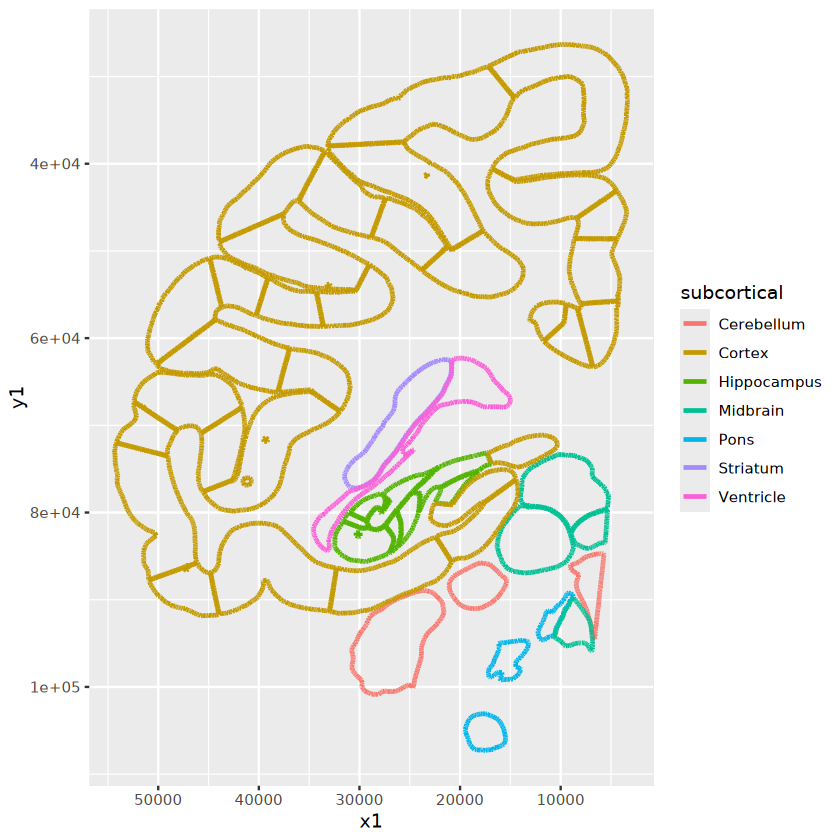

In [179]:
#subcoran = unique(fsraw.cor[,c("region","subcortical")])
head(subcoran)
edgesdf = pref$areaedges
edgesdf[edgesdf$areaid == "1/2",]$areaid = "1|2"
edgesdf = merge(edgesdf,subcoran,by.x = "areaid",by.y = "region")
ggplot() + geom_segment(data = edgesdf, 
                   aes(x = x1, y = y1, xend = x2, yend = y2,color = subcortical),
                   size = 1,alpha = 1) + scale_y_reverse() + scale_x_reverse()


In [252]:
hubgene = c("ARPP19","ARPP21","DDRGK1","RPS27","PPP3CB","IDH3B","SYNGR1","FXYD1","EPB41","PDHA1","SLC8A1","RPL7A")
#NPFF ZNF71
mycolor =  c('#DC050B','#1864AF','#F7EF55')
hubtrans = c("ARPP19-NM_001283415.1","ARPP19-XM_015452432.1",
             "DDRGK1-WeiLab-1","DDRGK1-XM_005568473.2",
             "ARPP21-XM_005545496.2","ARPP21-XM_005545480.2","ARPP21-XM_015444956.1",
             "FXYD1-XM_005588819.1","FXYD1-XM_005588818.2",
             "IDH3B-XM_005568512.1","IDH3B-XM_005568513.1",
             "EPB41-XM_005544192.2","EPB41-XM_005544198.2",
             "MYL6-WeiLab-2","MYL6-WeiLab-1",
             "TSTD1-XM_005541224.2","TSTD1-XM_005541226.2",
             "GPX4-WeiLab-2","GPX4-XM_005587358.2",
             "NKX6-2-WeiLab-1","NKX6-2-WeiLab-3",
             "PDHA1-WeiLab-1","PDHA1-XM_005593119.2",
             "RPS27-XM_005541720.2","RPS27-WeiLab-1",
            "SYNGR1-XM_005567237.2","SYNGR1-XM_005567239.2",
            "PPP3CB-XM_015455847.1","PPP3CB-XM_015455855.1",
            "SLC8A1-XM_005576034.2","SLC8A1-XM_005576035.2",
            "RPL7A-NM_001284957.1","RPL7A-WeiLab-1")
plmkt.sp = list()
for (i in 1:3) {
    print(hubgene[i])
    plmkt.sp[[i]] = SpCasePlot(fsraw.cor,
                               hubgene[i],hubtrans,ptsize = 0.5,mycolor,0.5)
}

for (i in 4:length(hubgene)) {
    print(hubgene[i])
    plmkt.sp[[i]] = SpCasePlot(fsraw.cor,hubgene[i],hubtrans,ptsize = 0.5,mycolor)
}
plmkt.spt = ggarrange(plotlist = plmkt.sp,ncol = 4,nrow = 3)
ggexport(plmkt.spt,filename = "result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_total_case_25_03_04.pdf", 
         width = 12,height = 16)

[1] "ARPP19"
[1] "ARPP21"
[1] "DDRGK1"
[1] "RPS27"
[1] "PPP3CB"
[1] "IDH3B"
[1] "SYNGR1"
[1] "FXYD1"
[1] "EPB41"
[1] "PDHA1"
[1] "SLC8A1"
[1] "RPL7A"


file saved to result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_total_case_25_03_04.pdf



file saved to result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_legend_12_27.pdf



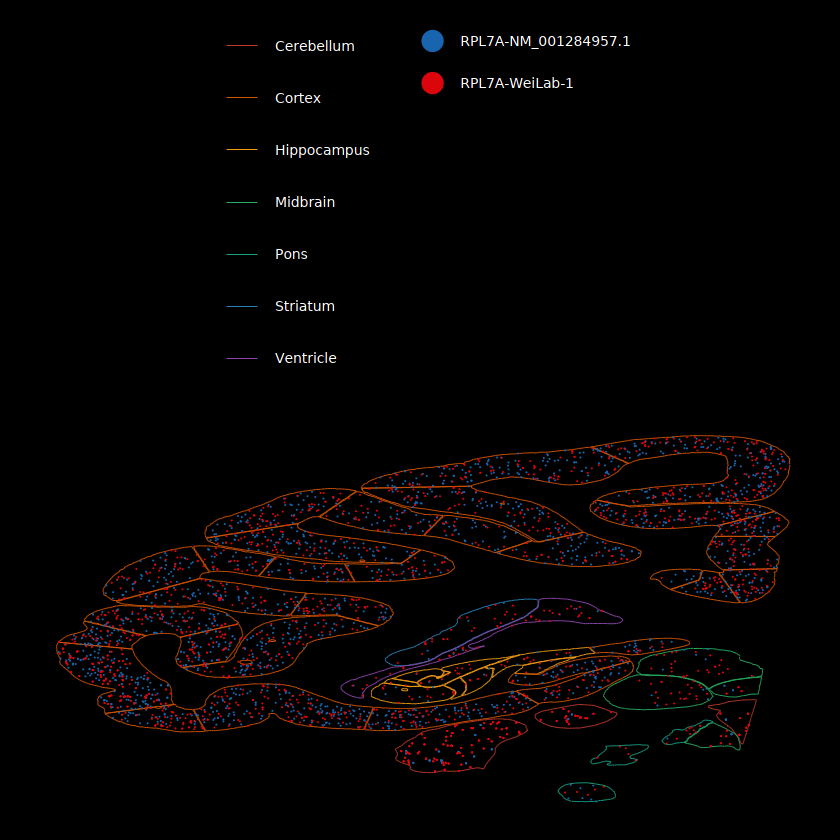

In [20]:
plgend = plmkt.sp[[i]] + guides(color = guide_legend(override.aes = list(size=8),ncol = 1),
                       fill = guide_legend(override.aes = list(size=6),nrow = 2),size = 7)
plgend
ggexport(plgend,filename = "result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_legend_12_27.pdf", 
         width = 4,height = 8)

In [94]:
geneex = "ARPP19"
fileid = paste0("result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_",geneex,"_24_05_02.pdf")
hubtrans = c("NM_001283415.1","XM_015452431.1")
pci = MarkerSpPlot(fsrawdp.cell,fsrawdp.cellb,geneex,hubtrans = hubtrans)
ggexport(pci,filename = fileid,width = 4,height = 6)

geneex = "FXYD1"
fileid = paste0("result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_",geneex,"_24_05_02.pdf")
hubtrans = c("XM_005588818.2","XM_005588819.1")
pci = MarkerSpPlot(fsrawdp.cell,fsrawdp.cellb,geneex,hubtrans = hubtrans)
ggexport(pci,filename = fileid,width = 4,height = 6)

geneex = "GPX4"
fileid = paste0("result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_",geneex,"_24_05_02.pdf")
hubtrans = c("GPX4-WeiLab-2","XM_005587358.2")
pci = MarkerSpPlot(fsrawdp.cell,fsrawdp.cellb,geneex,hubtrans = hubtrans)
ggexport(pci,filename = fileid,width = 4,height = 6)

geneex = "MYL6"
fileid = paste0("result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_",geneex,"_24_05_02.pdf")
hubtrans = c("MYL6-WeiLab-1","MYL6-WeiLab-2")
pci = MarkerSpPlot(fsrawdp.cell,fsrawdp.cellb,geneex,hubtrans = hubtrans)
ggexport(pci,filename = fileid,width = 4,height = 6)



file saved to result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_ARPP19_24_05_02.pdf

file saved to result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_FXYD1_24_05_02.pdf

file saved to result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_GPX4_24_05_02.pdf

file saved to result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_MYL6_24_05_02.pdf



file saved to result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_RPS27_24_11_22.pdf



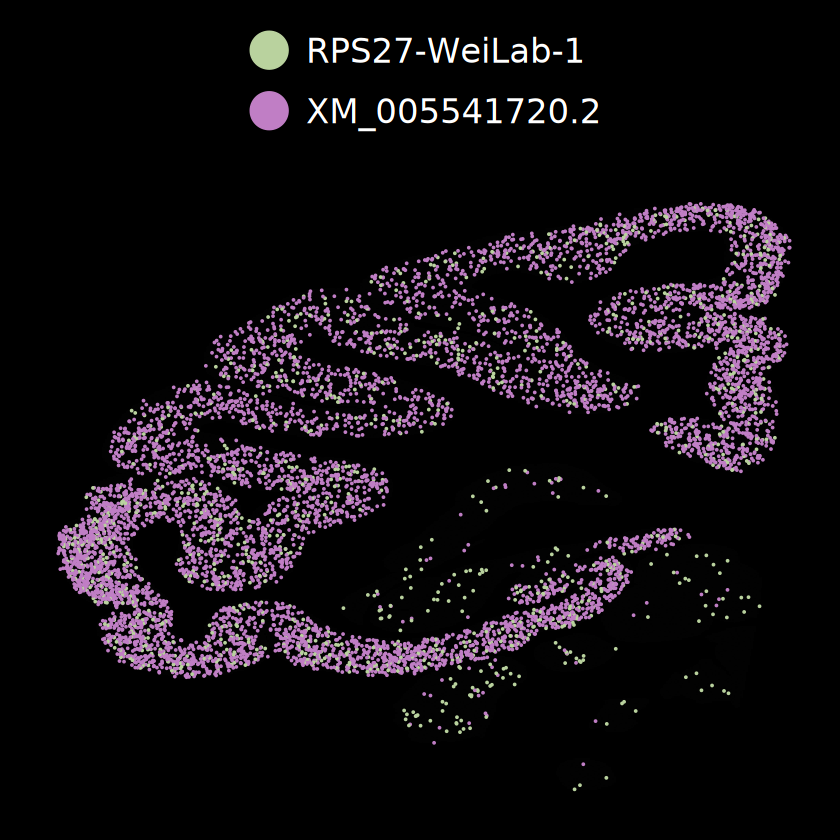

In [14]:
geneex = "RPS27"
fileid = paste0("result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_",geneex,"_24_11_22.pdf")
pci = MarkerSpPlot(fsrawdp.cell,fsrawdp.cellb,geneex)
ggexport(pci,filename = fileid,width = 4,height = 6)
pci

file saved to result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_SYNGR1_24_11_22.pdf



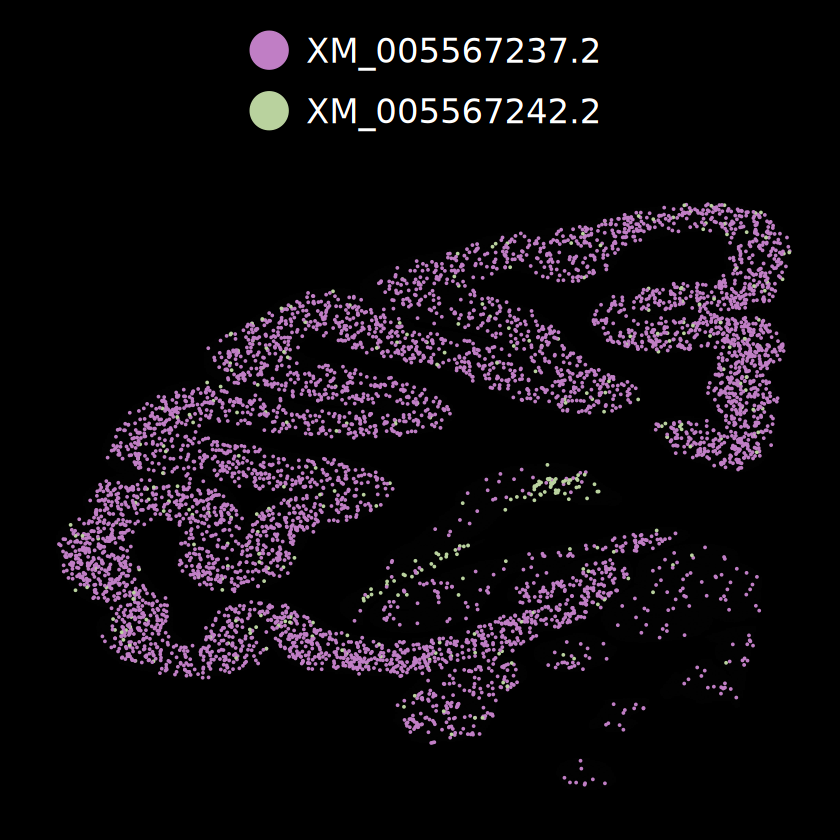

In [16]:
geneex = "SYNGR1"
fileid = paste0("result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_",geneex,"_24_11_22.pdf")
pci = MarkerSpPlot(fsrawdp.cell,fsrawdp.cellb,geneex,hubtrans = c("XM_005567242.2","XM_005567237.2"))
ggexport(pci,filename = fileid,width = 4,height = 6)
pci

In [430]:
geneex = "MYL6"
fileid = paste0("result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_",geneex,"_24_12_10.pdf")
mytranscolor = rev(distinctColorPalette(2))
hubtrans = c("MYL6-WeiLab-2","MYL6-WeiLab-1")
pci = SpCasePlot(fsraw.cor,geneex,hubtrans,ptsize = 0.4,mytranscolor)
ggexport(pci,filename = fileid,width = 3,height = 21/4)

Warning message in grid.newpage():
"Cannot open temporary file '/tmp/Rtmp8Es689/pdff5b3651de7dd' for compression (reason: No such file or directory); compression has been turned off for this device"
file saved to result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_MYL6_24_12_10.pdf



In [431]:
geneex = "CDC42"
fileid = paste0("result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_",geneex,"_24_12_10.pdf")
mytranscolor = rev(distinctColorPalette(2))
mytranscolor = c("#125B9A","#F05A7E")
hubtrans = c("CDC42-NM_001283401.1","CDC42-WeiLab-1")
pci = SpCasePlot(fsraw.cor,geneex,hubtrans,ptsize = 0.4,mytranscolor)
ggexport(pci,filename = fileid,width = 3,height = 21/4)

Warning message in grid.newpage():
"Cannot open temporary file '/tmp/Rtmp8Es689/pdff5b37f1abfd1' for compression (reason: No such file or directory); compression has been turned off for this device"
file saved to result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_CDC42_24_12_10.pdf



In [425]:
geneex = "EPB41"
fileid = paste0("result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_",geneex,"_24_12_10.pdf")
hubtrans = c("EPB41-XM_005544192.2","EPB41-XM_005544198.2")
pci = SpCasePlot(fsraw.cor,geneex,hubtrans,ptsize = 0.6,mycolor)
ggexport(pci,filename = fileid,width = 3,height = 21/4)

Warning message in grid.newpage():
"Cannot open temporary file '/tmp/Rtmp8Es689/pdff5b3701b910' for compression (reason: No such file or directory); compression has been turned off for this device"
file saved to result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_EPB41_24_12_10.pdf



In [421]:
geneex = "ARPP21"
fileid = paste0("result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_",geneex,"_24_12_10.pdf")
hubtrans = c("ARPP21-XM_015444956.1","ARPP21-XM_005545480.2","ARPP21-XM_005545496.2")
mycolor =  c('#1864AF','#DC050B','#F7EF55')
#c('#1864AF','#DC050B','#F7EF55')
pci = SpCasePlot(fsraw.cor,geneex,hubtrans,ptsize = 0.3,mycolor)
ggexport(pci,filename = fileid,width = 3,height = 21/4)

Warning message in grid.newpage():
"Cannot open temporary file '/tmp/Rtmp8Es689/pdff5b34ea66cae' for compression (reason: No such file or directory); compression has been turned off for this device"
file saved to result/figure6_other_cmp/dtu_case_ls_subcortical_spatial_point_ARPP21_24_12_10.pdf



`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead."
Warning message:
"Removed 39 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 23 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 14 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 39 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 23 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 14 rows containing missing values or values outside the scale range
(`geom_segment()`)."
file saved to result/figure6_other_cmp/dtu_

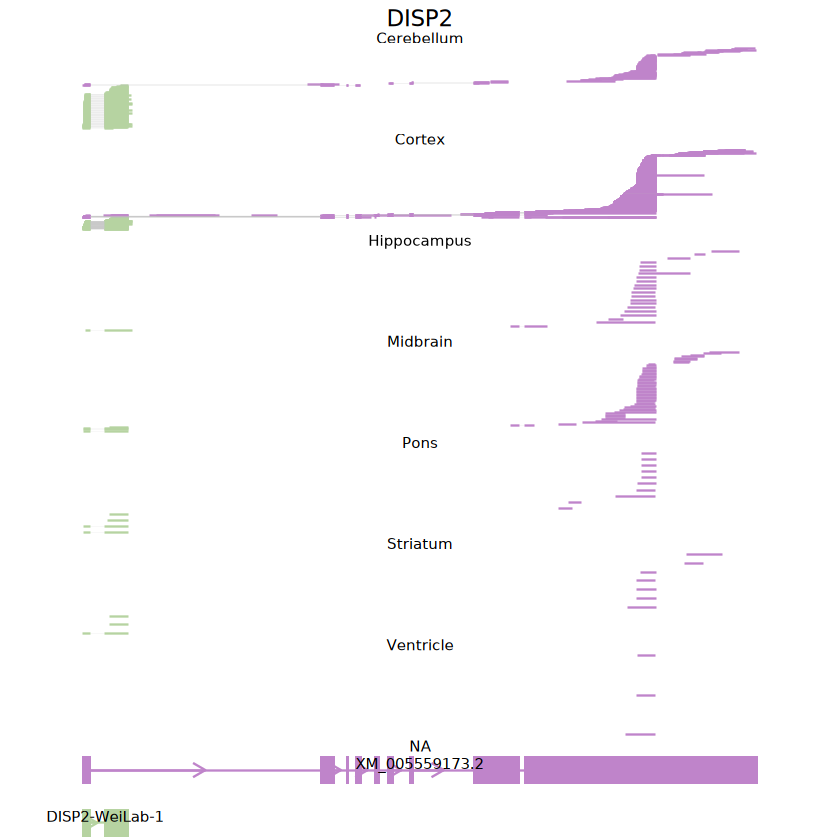

In [74]:
#fsraw$areatr = fsraw$subcortical
fsraw.cor$areatr = fsraw.cor$subcortical
geneex = "DISP2"
fileid = paste0("result/figure6_other_cmp/dtu_case_ls_subcortical_readsplice_point_",geneex,"_24_12_10.pdf")
grtdfl = BuildPlotBed(fsraw.cor,longbed,"subcortical",geneex,NULL)
pclsi = tryCatch(IsoformReadPlot(gtf, grtdfl, geneex,onlyhub = F), 
                                                  error = function(e) NULL)
pclsi
ggexport(pclsi,filename = fileid,width = 5,height = 6)

In [424]:
fsraw.cor$areatr = fsraw.cor$subcortical
geneex = "RPS27"
fileid = paste0("result/figure6_other_cmp/dtu_case_ls_subcortical_readsplice_point_",geneex,"_24_12_10.pdf")
grtdfl = BuildPlotBed(fsraw.cor,longbed,"subcortical",geneex,NULL)
pclsi = tryCatch(IsoformReadPlot(gtf, grtdfl, geneex,onlyhub = F), 
                                                  error = function(e) NULL)
pclsi
ggexport(pclsi,filename = fileid,width = 5,height = 6)

`summarise()` has grouped output by 'transcript_id'. You can override using the
`.groups` argument.
Warning message:
"Removed 30271 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 24104 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 5578 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message in grid.newpage():
"Cannot open temporary file '/tmp/Rtmp8Es689/pdff5b319826f67' for compression (reason: No such file or directory); compression has been turned off for this device"
Warning message:
"Removed 30271 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 24104 rows containing missing values or values outside the scale range
(`geom_segment()`)."

ERROR: Error in file(con, "rb"): cannot open the connection


plot without title

In [118]:
ggexport(pclsi,filename = "result/figure6_other_cmp/dtu_case_ls_subcortical_PDHA1_splice_05_03.pdf",width = 4,height = 5)

Warning message:
"Removed 1983 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 238 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1721 rows containing missing values or values outside the scale range
(`geom_segment()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`)."
file saved to result/figure6_other_cmp/dtu_case_ls_subcortical_PDHA1_splice_05_03.pdf



In [406]:
isosigi = isosigls$subcortical
isosigi = isosigi[isosigi$sig != "N",]
isosigi[isosigi$gene_id == "ARPP21",]
isosigi = isosigi %>% group_by(transcript_id) %>% filter(length(unique(areatr)) < 3)
isosigi = isosigi[isosigi$areatr == "Striatum",]
isosigi[abs(isosigi$dr) > 0.2 & isosigi$count > 30,]
#unique(isosigi$gene_id)


gene_id transcript_id  areatr      count genecount relative   meanrelative
3980 ARPP21  XM_005545480.2 Hippocampus  214    437     0.48970252 0.38758218  
3981 ARPP21  XM_005545480.2 Midbrain     226    434     0.52073733 0.38758218  
3983 ARPP21  XM_005545480.2 Striatum     198   2316     0.08549223 0.38758218  
3985 ARPP21  XM_005545496.2 Cerebellum    34    861     0.03948897 0.27545467  
3987 ARPP21  XM_005545496.2 Hippocampus   69    437     0.15789474 0.27545467  
3988 ARPP21  XM_005545496.2 Midbrain      32    434     0.07373272 0.27545467  
3989 ARPP21  XM_005545496.2 Striatum    1418   2316     0.61226252 0.27545467  
3990 ARPP21  XM_005545496.2 Ventricle     29     52     0.55769231 0.27545467  
3995 ARPP21  XM_005545497.2 Striatum     554   2316     0.23920553 0.06872105  
3997 ARPP21  XM_015444950.1 Cortex      2200  19182     0.11469086 0.19997465  
4000 ARPP21  XM_015444950.1 Pons          18     42     0.42857143 0.19997465  
4001 ARPP21  XM_015444950.1 Striatum      29   2316     0.01252159 0.19997465  
4003 ARPP21  XM_015444956.1 Cortex      4734  19182     0.24679387 0.08074998  
     otherrelative dr         sig  pvalue padj
3980 0.37056212     0.1191404 Up   0      0   
3981 0.36538966     0.1553477 Up   0      0   
3983 0.43793051    -0.3524383 Down 0      0   
3985 0.32264781    -0.2831588 Down 0      0   
3987 0.29896666    -0.1410719 Down 0      0   
3988 0.31579906    -0.2420663 Down 0      0   
3989 0.20809310     0.4041694 Up   0      0   
3990 0.21900714     0.3386852 Up   0      0   
3995 0.02609993     0.2131056 Up   0      0   
3997 0.21703141    -0.1023406 Down 0      0   
4000 0.15425529     0.2743161 Up   0      0   
4001 0.23746526    -0.2249437 Down 0      0   
4003 0.05307600     0.1937179 Up   0      0

gene_id      transcript_id         areatr   count genecount relative 
1  ARPP21       XM_005545497.2        Striatum 554   2316      0.2392055
2  C6H5orf63    C6H5orf63-WeiLab-4    Striatum  35     82      0.4268293
3  CALB1        NM_001284560.1        Striatum  38     75      0.5066667
4  CALB1        XM_015454768.1        Striatum  37     75      0.4933333
5  CCDC173      XM_015432334.1        Striatum  43     54      0.7962963
6  CCNDBP1      CCNDBP1-WeiLab-1      Striatum  36     57      0.6315789
7  DNAJC24      XM_005578309.2        Striatum  35     37      0.9459459
8  EXOSC7       EXOSC7-WeiLab-1       Striatum  45     51      0.8823529
9  G3BP1        XM_005558324.2        Striatum  46     69      0.6666667
10 HSF1         XM_005564345.2        Striatum  36     52      0.6923077
11 KARS         XM_005592591.2        Striatum  44     62      0.7096774
12 LOC107126709 LOC107126709-WeiLab-1 Striatum  42     56      0.7500000
13 PCSK1        XM_005557414.2        Striatum  43     55      0.7818182
14 PDE10A       XM_015448493.1        Striatum 506    739      0.6847091
15 PDS5B        XM_005585608.2        Striatum  41     88      0.4659091
16 TAF1         XM_005593911.2        Striatum  32     52      0.6153846
17 TCEAL1_1     NM_001283855.1_1      Striatum  50     87      0.5747126
18 TCEAL1_1     TCEAL1_1-WeiLab-1     Striatum  37     87      0.4252874
   meanrelative otherrelative dr         sig  pvalue       padj        
1  0.06872105   0.02609993     0.2131056 Up   0.000000e+00 0.000000e+00
2  0.18552004   0.14530184     0.2815274 Up   7.137426e-10 6.589869e-09
3  0.31565141   0.27744836     0.2292183 Up   1.122523e-04 4.520786e-04
4  0.68434859   0.72255164    -0.2292183 Down 1.122523e-04 4.520786e-04
5  0.62376882   0.58926332     0.2070330 Up   2.622408e-04 9.667589e-04
6  0.44050435   0.40865858     0.2229204 Up   4.352996e-03 1.153712e-02
7  0.71503394   0.67654861     0.2693973 Up   3.635019e-08 2.722304e-07
8  0.70309861   0.67322289     0.2091301 Up   1.191624e-03 3.694932e-03
9  0.85471500   0.88605639    -0.2193897 Down 3.456194e-07 2.241092e-06
10 0.87828381   0.90927983    -0.2169721 Down 1.285583e-09 1.144261e-08
11 0.88715258   0.91673178    -0.2070544 Down 9.036729e-07 5.496677e-06
12 0.59385042   0.51577564     0.2342244 Up   3.036542e-03 8.381994e-03
13 0.95933785   0.98892446    -0.2071063 Down 1.504448e-36 6.204345e-35
14 0.49976479   0.45352872     0.2311803 Up   3.103037e-20 6.551327e-19
15 0.69248155   0.73024362    -0.2643345 Down 2.258688e-05 1.069850e-04
16 0.80225105   0.83962434    -0.2242397 Down 3.996236e-05 1.791356e-04
17 0.78557934   0.82072379    -0.2460111 Down 2.157708e-06 1.238180e-05
18 0.21442066   0.17927621     0.2460111 Up   2.157708e-06 1.238180e-05

In [414]:
rgb(220,5,11,max = 255)
rgb(24,100,175,max = 255)
rgb(247,239,85,max = 255)

[1] "#DC050B"

[1] "#1864AF"

[1] "#F7EF55"

In [10]:
# isosigi = isosigls$subcortical
# isosighub = isosigi[isosigi$gene_id %in% c("PDHA1","FXYD1", "SYNGR1"),]
# isosighub[isosighub$areatr %in% "Ventricle",]
# #isosighub
# isosighub[!isosighub$areatr %in% "Ventricle",] %>% group_by(gene_id,transcript_id) %>% summarise(mean(relative))

# isosigi = isosigls$subcortical
# isosighub = isosigi[isosigi$gene_id %in% c("IDH3B"),]
# isosighub[isosighub$areatr %in% c("Hippocampus","Midbrain","Cortex","Striatum"),] %>% group_by(gene_id,transcript_id) %>% summarise(mean(relative))
# isosighub[!isosighub$areatr %in% c("Hippocampus","Midbrain","Cortex","Striatum"),] %>% group_by(gene_id,transcript_id) %>% summarise(mean(relative))

# isosigi = isosigls$subcortical
# isosighub = isosigi[isosigi$gene_id %in% c("PPP3CB"),]
# isosighub[isosighub$areatr %in% c("Midbrain","Pons"),] %>% group_by(gene_id,transcript_id) %>% summarise(mean(relative))
# isosighub[!isosighub$areatr %in% c("Midbrain","Pons"),] %>% group_by(gene_id,transcript_id) %>% summarise(mean(relative))

isosigi = isosigls$subcortical
isosighub = isosigi[isosigi$gene_id %in% c("RPL7A","RPS27","SLC8A1"),]
isosighub[isosighub$areatr %in% c("Cortex"),] %>% group_by(gene_id,transcript_id) %>% summarise(mean(relative))
isosighub[!isosighub$areatr %in% c("Cortex"),] %>% group_by(gene_id,transcript_id) %>% summarise(mean(relative))


`summarise()` has grouped output by 'gene_id'. You can override using the
`.groups` argument.


gene_id transcript_id  mean(relative)
1 IDH3B   XM_005568512.1 0.2519387     
2 IDH3B   XM_005568513.1 0.5234449     
3 IDH3B   XM_015457683.1 0.1716300

`summarise()` has grouped output by 'gene_id'. You can override using the
`.groups` argument.


gene_id transcript_id  mean(relative)
1 IDH3B   XM_005568512.1 0.3711028     
2 IDH3B   XM_005568513.1 0.2384923     
3 IDH3B   XM_015457683.1 0.3072911

`summarise()` has grouped output by 'gene_id'. You can override using the
`.groups` argument.


gene_id transcript_id  mean(relative)
1 PPP3CB  XM_015455847.1 0.3332696     
2 PPP3CB  XM_015455855.1 0.6071640

`summarise()` has grouped output by 'gene_id'. You can override using the
`.groups` argument.


gene_id transcript_id  mean(relative)
1 PPP3CB  XM_015455847.1 0.8211115     
2 PPP3CB  XM_015455855.1 0.1068791

Warning message:
"package 'scatterpie' was built under R version 4.3.3"
scatterpie v0.2.4 Learn more at https://yulab-smu.top/

Please cite:

D Wang, G Chen, L Li, S Wen, Z Xie, X Luo, L Zhan, S Xu, J Li, R
Wang, Q Wang, G Yu. Reducing language barriers, promoting information
absorption, and communication using fanyi. Chinese Medical Journal. 2024,
137(16):1950-1956. doi: 10.1097/CM9.0000000000003242



Attaching package: 'scatterpie'


The following object is masked from 'package:sp':

    recenter




areatr     gene_id 1          2         3          groupid geneidn
1 Cerebellum ARPP19  0.09650924 0.7268994 0.00000000 1       1      
2 Cerebellum ARPP21  0.03948897 0.4657375 0.09756098 1       2      
3 Cerebellum DDRGK1  0.30817610 0.6918239 0.00000000 1       3      
4 Cerebellum EPB41   0.50000000 0.3541667 0.00000000 1       9      
5 Cerebellum FXYD1   0.32872928 0.6546961 0.00000000 1       8      
6 Cerebellum IDH3B   0.41666667 0.2320513 0.00000000 1       6

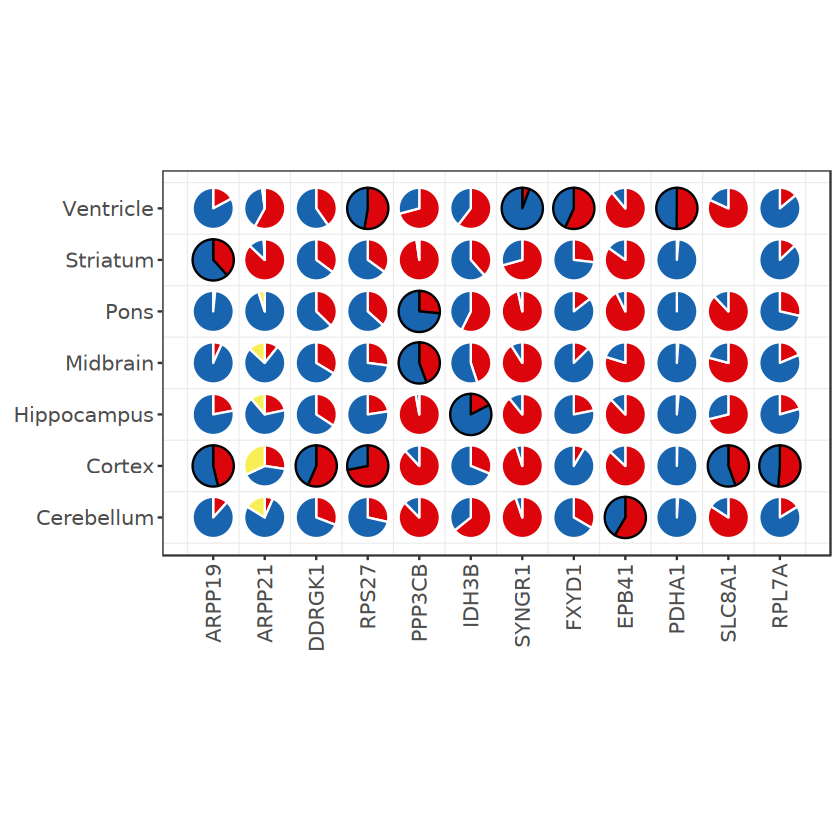

In [4]:
#case plot
#hubgene = c("ARPP19","DDRGK1","FXYD1","IDH3B","MYL6","TSTD1","PDHA1","RPS27","NKX6-2")

#hubgene = c("ARPP19","DDRGK1","FXYD1","IDH3B","MYL6","SYNGR1","PDHA1","RPS27","NKX6-2","PPP3CB","SLC8A1","RPL7A")
hubgene = c("ARPP19","ARPP21","DDRGK1","RPS27","PPP3CB","IDH3B","SYNGR1","FXYD1","EPB41","PDHA1","SLC8A1","RPL7A")
#NPFF ZNF71
mycolor =  c('#DC050B','#1864AF','#F7EF55')
hubtrans = c("NM_001283415.1","XM_015452432.1",
             "DDRGK1-WeiLab-1","XM_005568473.2",
             "XM_005545496.2","XM_005545480.2","XM_015444956.1",
             "XM_005588819.1","XM_005588818.2",
             "XM_005568512.1","XM_005568513.1",
             "XM_005544192.2","XM_005544198.2",
             "MYL6-WeiLab-2","MYL6-WeiLab-1",
             "XM_005541224.2","XM_005541226.2",
             "GPX4-WeiLab-2","XM_005587358.2",
             "NKX6-2-WeiLab-1","NKX6-2-WeiLab-3",
             "PDHA1-WeiLab-1","XM_005593119.2",
             "XM_005541720.2","RPS27-WeiLab-1",
            "XM_005567237.2","XM_005567239.2",
            "XM_015455847.1","XM_015455855.1",
            "XM_005576034.2","XM_005576035.2",
            "NM_001284957.1","RPL7A-WeiLab-1")
#caseg = colnames(isosigimx)
isosigi2 = isosigls$subcortical
#isosigi2 = isosigi2[isosigi2$meanrelative > 0.1,]
casecti = isosigi2[isosigi2$gene_id %in% hubgene & isosigi2$transcript_id %in% hubtrans,]
isosigi2 = isosigi2[isosigi2$sig == "Up",]

#casecti = casecti[casecti$genecount > 10,]

# casecti = casecti %>% group_by(transcript_id) %>% mutate(tcount = sum(count))
# casecti = casecti[order(casecti$gene_id,casecti$tcount),]
# transorder = unique(casecti$transcript_id)
# casecti$transcript_id = factor(casecti$transcript_id,levels = transorder)
casecti$transcript_id = factor(casecti$transcript_id,levels = hubtrans)
casecti = casecti[order(casecti$gene_id,casecti$transcript_id),]
casecti = casecti %>% group_by(gene_id) %>% 
    mutate(id = as.character(as.numeric(factor(transcript_id,levels = unique(transcript_id)))))

casecti$gene_tran = paste0(casecti$gene_id,"-",casecti$id)
library(scatterpie)
casectl = dcast(casecti,areatr+gene_id~id,value.var = "relative")
casectl[is.na(casectl)] = 0
casectl = casectl[order(casectl$areatr),]
casectl$groupid = as.numeric(factor(casectl$areatr,levels = unique(casectl$areatr)))
casectl$geneidn = as.numeric(factor(casectl$gene_id,levels = hubgene))
head(casectl)

library(patchwork)
ison = casecti %>% group_by(gene_id) %>% summarise(transn = length(unique(transcript_id)))
ison = max(ison$transn)
casectl$sig = 'N'
#caseg = c("INTU",'DNAJC7',"TUSC3","GRIP1","CACNB4","FAM173A","KLC1","MPG","MTG2","EIF5A","ARID4A","SIVA1","IDH3B")
#caseg = c("MYL6",'NTRK2',"DBNDD2","DDRGK1","ARPP19","ARPP21")
transcolors = c("")
highlight = c("ARPP19-Cortex","ARPP19-Striatum","DDRGK1-Cortex",
              "FXYD1-Ventricle","IDH3B-Hippocampus","EPB41-Cerebellum","SYNGR1-Ventricle",
             "PDHA1-Ventricle","RPS27-Cortex","RPS27-Ventricle",
              "NKX6-2-Striatum","PPP3CB-Midbrain",
              "PPP3CB-Pons","SLC8A1-Cortex","RPL7A-Cortex")
casectl[paste0(casectl$gene_id,"-",casectl$areatr) %in% highlight,]$sig = "Y"
casectl$gene_id = factor(casectl$gene_id,levels = hubgene)
plt = ggplot() + 
      geom_scatterpie(data = casectl,
                      aes(y = groupid, x = geneidn, group = groupid,color = sig,
                                           r = 0.4),
                      cols= colnames(casectl)[3:(3+ison-1)]) + 
      coord_fixed() +
      scale_y_continuous(breaks = c(1:length(unique(casectl$areatr))),labels = unique(casectl$areatr)) +
      scale_x_continuous(breaks = c(1:length(hubgene)),labels = hubgene) +
      scale_color_manual(values = c("white","black")) +
      # geom_smooth(data = tem2, aes(x=x, y=y), se = F, method = 'loess',color = "black") +
      scale_fill_manual(values = mycolor) +
      #annotate("text", x = 8, y = 7, label = caseg[i], hjust = 1.1, vjust = 1.1, size = 5, angle = 90) +
      ylab("") + xlab("") +
      theme_bw() + theme(legend.position="none",axis.text = element_text(size = 12),panel.grid.major = element_blank(),
                         axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1),
                        strip.background =element_rect(fill="white"))
plt
#ggexport(plt,filename = "result/figure6_other_cmp//case_subcortical_isoform_rate_stat_pie_25_03_04.pdf",width = 4,height = 8)

In [5]:
casectl

areatr      gene_id 1           2          3           groupid geneidn sig
1  Cerebellum  ARPP19  0.096509240 0.72689938 0.00000000  1        1      N  
2  Cerebellum  ARPP21  0.039488966 0.46573751 0.09756098  1        2      N  
3  Cerebellum  DDRGK1  0.308176101 0.69182390 0.00000000  1        3      N  
4  Cerebellum  EPB41   0.500000000 0.35416667 0.00000000  1        9      Y  
5  Cerebellum  FXYD1   0.328729282 0.65469613 0.00000000  1        8      N  
6  Cerebellum  IDH3B   0.416666667 0.23205128 0.00000000  1        6      N  
7  Cerebellum  PDHA1   0.010121457 0.98987854 0.00000000  1       10      N  
8  Cerebellum  PPP3CB  0.813333333 0.11466667 0.00000000  1        5      N  
9  Cerebellum  RPL7A   0.162790698 0.83720930 0.00000000  1       12      N  
10 Cerebellum  RPS27   0.285198556 0.71480144 0.00000000  1        4      N  
11 Cerebellum  SLC8A1  0.595505618 0.11235955 0.00000000  1       11      N  
12 Cerebellum  SYNGR1  0.869822485 0.04733728 0.00000000  1        7      N  
13 Cortex      ARPP19  0.439606448 0.50961452 0.00000000  2        1      Y  
14 Cortex      ARPP21  0.211656762 0.31440934 0.24679387  2        2      N  
15 Cortex      DDRGK1  0.565608108 0.43439189 0.00000000  2        3      Y  
16 Cortex      EPB41   0.765151515 0.11363636 0.00000000  2        9      N  
17 Cortex      FXYD1   0.084157840 0.89931323 0.00000000  2        8      N  
18 Cortex      IDH3B   0.243011301 0.53649418 0.00000000  2        6      N  
19 Cortex      PDHA1   0.003938248 0.99606175 0.00000000  2       10      N  
20 Cortex      PPP3CB  0.834773636 0.11311750 0.00000000  2        5      N  
21 Cortex      RPL7A   0.513279802 0.48672020 0.00000000  2       12      Y  
22 Cortex      RPS27   0.719510910 0.28048909 0.00000000  2        4      Y  
23 Cortex      SLC8A1  0.372777239 0.46686065 0.00000000  2       11      Y  
24 Cortex      SYNGR1  0.900857561 0.04727045 0.00000000  2        7      N  
25 Hippocampus ARPP19  0.196531792 0.69797688 0.00000000  3        1      N  
26 Hippocampus ARPP21  0.157894737 0.48970252 0.08237986  3        2      N  
27 Hippocampus DDRGK1  0.342446043 0.65755396 0.00000000  3        3      N  
28 Hippocampus EPB41   0.837209302 0.11627907 0.00000000  3        9      N  
29 Hippocampus FXYD1   0.213114754 0.76229508 0.00000000  3        8      N  
30 Hippocampus IDH3B   0.146341463 0.69163763 0.00000000  3        6      Y  
⋮  ⋮           ⋮       ⋮           ⋮          ⋮           ⋮       ⋮       ⋮  
54 Pons        IDH3B   0.31132075  0.23113208 0.000000000 5        6      N  
55 Pons        PDHA1   0.00000000  1.00000000 0.000000000 5       10      N  
56 Pons        PPP3CB  0.24873096  0.69035533 0.000000000 5        5      Y  
57 Pons        RPL7A   0.28571429  0.71428571 0.000000000 5       12      N  
58 Pons        RPS27   0.36734694  0.63265306 0.000000000 5        4      N  
59 Pons        SLC8A1  0.81481481  0.11111111 0.000000000 5       11      N  
60 Pons        SYNGR1  0.93333333  0.03333333 0.000000000 5        7      N  
61 Striatum    ARPP19  0.37515325  0.60318758 0.000000000 6        1      Y  
62 Striatum    ARPP21  0.61226252  0.08549223 0.005613126 6        2      N  
63 Striatum    DDRGK1  0.35192308  0.64807692 0.000000000 6        3      N  
64 Striatum    EPB41   0.73770492  0.13114754 0.000000000 6        9      N  
65 Striatum    FXYD1   0.26234568  0.71296296 0.000000000 6        8      N  
66 Striatum    IDH3B   0.29151292  0.46494465 0.000000000 6        6      N  
67 Striatum    PDHA1   0.01307190  0.98692810 0.000000000 6       10      N  
68 Striatum    PPP3CB  0.90410959  0.02054795 0.000000000 6        5      N  
69 Striatum    RPL7A   0.12903226  0.87096774 0.000000000 6       12      N  
70 Striatum    RPS27   0.35000000  0.65000000 0.000000000 6        4      N  
71 Striatum    SYNGR1  0.69491525  0.28813559 0.000000000 6        7      N  
72 Ventricle   ARPP19  0.15736041  0.75634518 0.000000000 7        1      N  
73 Ventricle   ARPP21  0.

In [96]:
isosigi2 = isosigls$subcortical
length(unique(isosigi2$gene_id))
#isosigi2 = isosigi2[isosigi2$meanrelative > 0.1,]
hubgene
casecti = isosigi2[isosigi2$gene_id %in% hubgene,]
isosigi2[isosigi2$gene_id %in% "DDRGK1",]
##isosigi2 = isosigi2[isosigi2$sig == "Up",]
#casecti = casecti[casecti$genecount > 10,]
unique(casecti$transcript_id)
unique(casecti$gene_id)

[1] 4842

[1] "ARPP19" "ARPP21" "DDRGK1" "RPS27"  "PPP3CB" "IDH3B"  "SYNGR1" "FXYD1" 
 [9] "EPB41"  "PDHA1"  "SLC8A1" "RPL7A"

gene_id transcript_id   areatr   count genecount relative   meanrelative
27160 DDRGK1  DDRGK1-WeiLab-1 ASC        18   256      0.07031250 0.06929246  
27161 DDRGK1  DDRGK1-WeiLab-1 L2         99   506      0.19565217 0.06929246  
27162 DDRGK1  DDRGK1-WeiLab-1 L2/3      221  1417      0.15596330 0.06929246  
27163 DDRGK1  DDRGK1-WeiLab-1 L2/3/4     34   285      0.11929825 0.06929246  
27164 DDRGK1  DDRGK1-WeiLab-1 L3/4       56   745      0.07516779 0.06929246  
27165 DDRGK1  DDRGK1-WeiLab-1 L3/4/5      2    69      0.02898551 0.06929246  
27166 DDRGK1  DDRGK1-WeiLab-1 L4         37   576      0.06423611 0.06929246  
27167 DDRGK1  DDRGK1-WeiLab-1 L4/5       26   642      0.04049844 0.06929246  
27168 DDRGK1  DDRGK1-WeiLab-1 L4/5/6     13   358      0.03631285 0.06929246  
27169 DDRGK1  DDRGK1-WeiLab-1 L5/6       22   428      0.05140187 0.06929246  
27170 DDRGK1  DDRGK1-WeiLab-1 L6         18   298      0.06040268 0.06929246  
27171 DDRGK1  DDRGK1-WeiLab-1 LAMP5       2    58      0.03448276 0.06929246  
27172 DDRGK1  DDRGK1-WeiLab-1 OLG        13   347      0.03746398 0.06929246  
27173 DDRGK1  DDRGK1-WeiLab-1 OPC         4    47      0.08510638 0.06929246  
27174 DDRGK1  DDRGK1-WeiLab-1 PVALB      12   204      0.05882353 0.06929246  
27175 DDRGK1  DDRGK1-WeiLab-1 RELN        3    87      0.03448276 0.06929246  
27176 DDRGK1  DDRGK1-WeiLab-1 SST        15   276      0.05434783 0.06929246  
27177 DDRGK1  DDRGK1-WeiLab-1 VIP         4    73      0.05479452 0.06929246  
27178 DDRGK1  DDRGK1-WeiLab-1 VIP_RELN    4    68      0.05882353 0.06929246  
27179 DDRGK1  XM_005568473.2  ASC       238   256      0.92968750 0.93070754  
27180 DDRGK1  XM_005568473.2  L2        407   506      0.80434783 0.93070754  
27181 DDRGK1  XM_005568473.2  L2/3     1196  1417      0.84403670 0.93070754  
27182 DDRGK1  XM_005568473.2  L2/3/4    251   285      0.88070175 0.93070754  
27183 DDRGK1  XM_005568473.2  L3/4      689   745      0.92483221 0.93070754  
27184 DDRGK1  XM_005568473.2  L3/4/5     67    69      0.97101449 0.93070754  
27185 DDRGK1  XM_005568473.2  L4        539   576      0.93576389 0.93070754  
27186 DDRGK1  XM_005568473.2  L4/5      616   642      0.95950156 0.93070754  
27187 DDRGK1  XM_005568473.2  L4/5/6    345   358      0.96368715 0.93070754  
27188 DDRGK1  XM_005568473.2  L5/6      406   428      0.94859813 0.93070754  
27189 DDRGK1  XM_005568473.2  L6        280   298      0.93959732 0.93070754  
27190 DDRGK1  XM_005568473.2  LAMP5      56    58      0.96551724 0.93070754  
27191 DDRGK1  XM_005568473.2  OLG       334   347      0.96253602 0.93070754  
27192 DDRGK1  XM_005568473.2  OPC        43    47      0.91489362 0.93070754  
27193 DDRGK1  XM_005568473.2  PVALB     192   204      0.94117647 0.93070754  
27194 DDRGK1  XM_005568473.2  RELN       84    87      0.96551724 0.93070754  
27195 DDRGK1  XM_005568473.2  SST       261   276      0.94565217 0.93070754  
27196 DDRGK1  XM_005568473.2  VIP        69    73      0.94520548 0.93070754  
27197 DDRGK1  XM_005568473.2  VIP_RELN   64    68      0.94117647 0.93070754  
      otherrelative dr           sig  pvalue       padj       
27160 0.06923579     0.001076708 N    2.342853e-38 7.09006e-36
27161 0.06227248     0.133379697 Up   2.342853e-38 7.09006e-36
27162 0.06447741     0.091485889 N    2.342853e-38 7.09006e-36
27163 0.06651436     0.052783884 N    2.342853e-38 7.09006e-36
27164 0.06896605     0.006201731 N    2.342853e-38 7.09006e-36
27165 0.07153174    -0.042546229 N    2.342853e-38 7.09006e-36
27166 0.06957337    -0.005337258 N    2.342853e-38 7.09006e-36
27167 0.07089213    -0.030393686 N    2.342853e-38 7.09006e-36
27168 0.07112466    -0.034811812 N    2.342853e-38 7.09006e-36
27169 0.07028638    -0.018884513 N    2.342853e-38 7.09006e-36
27170 0.06978634    -0.009383653 N    2.342853e-38 7.09006e-36
27171 0.07122633    -0.036743574 N    2.342853e-38 7.09006e-36
27172 0.07106071    -0.033596733 N    2.342853e-38 7.09006e-36
27173 0.06841391     0.016692473 N    2.342

[1] "NM_001283415.1"  "XM_015452432.1"  "XM_005545480.2"  "XM_005545496.2" 
 [5] "XM_015444950.1"  "XM_015444956.1"  "DDRGK1-WeiLab-1" "XM_005568473.2" 
 [9] "XM_005544192.2"  "XM_005544198.2"  "XM_015439530.1"  "XM_005588818.2" 
[13] "XM_005588819.1"  "XM_005568512.1"  "XM_005568513.1"  "XM_015457683.1" 
[17] "XM_015455847.1"  "XM_015455855.1"  "NM_001284957.1"  "RPL7A-WeiLab-1" 
[21] "RPS27-WeiLab-1"  "XM_005541720.2"  "XM_005576034.2"  "XM_005576035.2" 
[25] "XM_015433741.1"  "XM_015433745.1"  "XM_005567237.2"  "XM_005567239.2"

[1] "ARPP19" "ARPP21" "DDRGK1" "EPB41"  "FXYD1"  "IDH3B"  "PPP3CB" "RPL7A" 
 [9] "RPS27"  "SLC8A1" "SYNGR1"

### Subcortical dtu vs subclass dtu

In [272]:
isosigi = transtls$subcortical
isosigi$relative = isosigi$count/isosigi$genecount
head(isosigi)

gene_id transcript_id  areatr      count genecount relative 
1 A1BG    XM_015441069.1 Cortex       1     1        1.0000000
2 A2ML1   XM_005570054.2 Cortex      11    15        0.7333333
3 A2ML1   XM_005570054.2 Hippocampus  1     1        1.0000000
4 A2ML1   XM_005570054.2 Midbrain     2     2        1.0000000
5 A2ML1   XM_015430339.1 Cortex       4    15        0.2666667
6 A3GALT2 XM_005544050.2 Cerebellum   2     2        1.0000000

In [275]:
isosigi = isosigi[isosigi$genecount > 20,]
isosigi = isosigi %>% group_by(gene_id) %>% filter(length(unique(areatr)) > 3)
length(unique(isosigi$gene_id))

[1] 10843

In [283]:
isosigi = isosigls$subcortical
isosigi = isosigi[isosigi$genecount > 20 ,]
isosigi = isosigi %>% group_by(gene_id) %>% filter(length(unique(areatr)) > 3)
isosigi = isosigi[!is.na(isosigi$gene_id),]
isosigi.hub = isosigi[isosigi$sig == "Up" & isosigi$dr > 0.2,] %>% group_by(transcript_id) %>% filter(length(unique(areatr)) == 1)
length(unique(isosigi.hub$gene_id))
table(isosigi.hub$areatr)
head(isosigi.hub)

[1] 500


 Cerebellum      Cortex Hippocampus    Midbrain        Pons    Striatum 
         64          44          51          60          98          67 
  Ventricle 
        208 

gene_id transcript_id  areatr      count genecount relative  meanrelative
1 AASDH   XM_005555233.2 Midbrain    16    28        0.5714286 0.3700285   
2 AASDH   XM_005555239.2 Hippocampus 11    26        0.4230769 0.2647442   
3 AATF    XR_001485905.1 Pons        30    45        0.6666667 0.4398583   
4 ABCE1   XM_005556009.2 Striatum    21    37        0.5675676 0.3304914   
5 ABCE1   XM_005556010.2 Ventricle   40    47        0.8510638 0.6695086   
6 ACOT2   NM_001283932.1 Pons        24    30        0.8000000 0.5978228   
  otherrelative dr        sig pvalue       padj        
1 0.3028952     0.2685334 Up  7.897550e-03 1.937892e-02
2 0.2119666     0.2111103 Up  7.897550e-03 1.937892e-02
3 0.4020569     0.2646098 Up  4.483066e-03 1.183116e-02
4 0.2909788     0.2765888 Up  1.148132e-08 9.070681e-08
5 0.6392493     0.2118145 Up  1.148132e-08 9.070681e-08
6 0.5641265     0.2358735 Up  6.776712e-04 2.244151e-03

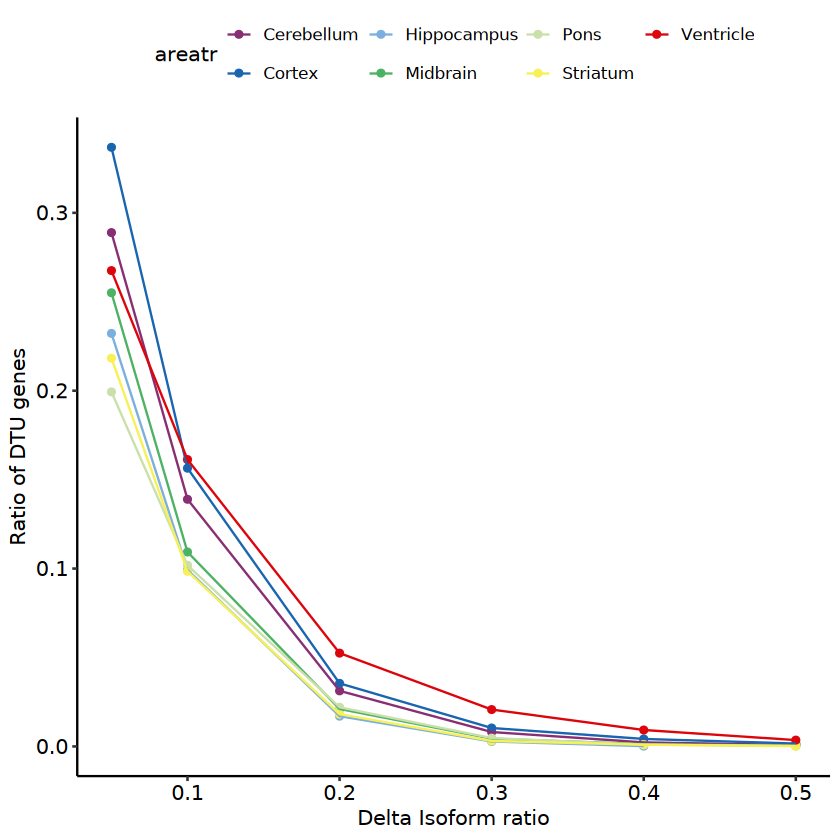

In [286]:

isosigi = isosigls$subcortical
thred = c(0.05,0.1,0.2,0.3,0.4,0.5,1)
QutileDTUst = function(isosigi,thred){
    isostdf = NULL
    genenum = length(unique(isosigi$gene_id))
    for(i in thred){
        genesign = isosigi[abs(isosigi$dr) > i & isosigi$padj < 0.05,]
        isostdfi = genesign %>% group_by(areatr) %>% summarise(sign = length(unique(gene_id)))
        isostdfi$thred = i
        isostdf = rbind(isostdf,isostdfi)
    }
    isostdf$total = genenum
    isostdf$ratio = isostdf$sign/isostdf$total
    return(isostdf)
}
isostdf = QutileDTUst(isosigls$subcortical,thred)
isostdf = isostdf[order(isostdf$areatr),]
isostdf$areatr = factor(isostdf$areatr,levels = unique(isostdf$areatr))
p2.1 = ggplot(isostdf,aes(x = thred,y = ratio,color = areatr,group = areatr)) + geom_point() + geom_line() +
#scale_y_continuous(limits = c(0,0.3)) + 
#facet_wrap(~group,nrow = 1) + 
scale_color_discreterainbow() + theme_pubr() +
xlab("Delta Isoform ratio") + ylab("Ratio of DTU genes")
p2.1
#ggexport(p2.1,filename = "result/figure2/sigiso_number_stat_lobe_layer_proportion_24_10_22.pdf",width = 5,height = 4)

`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'group'. You can override using the
`.groups` argument.
file saved to result/figure6_other_cmp/isoform_dr_cmp_layer_lobe_subcor_24_11_27.pdf



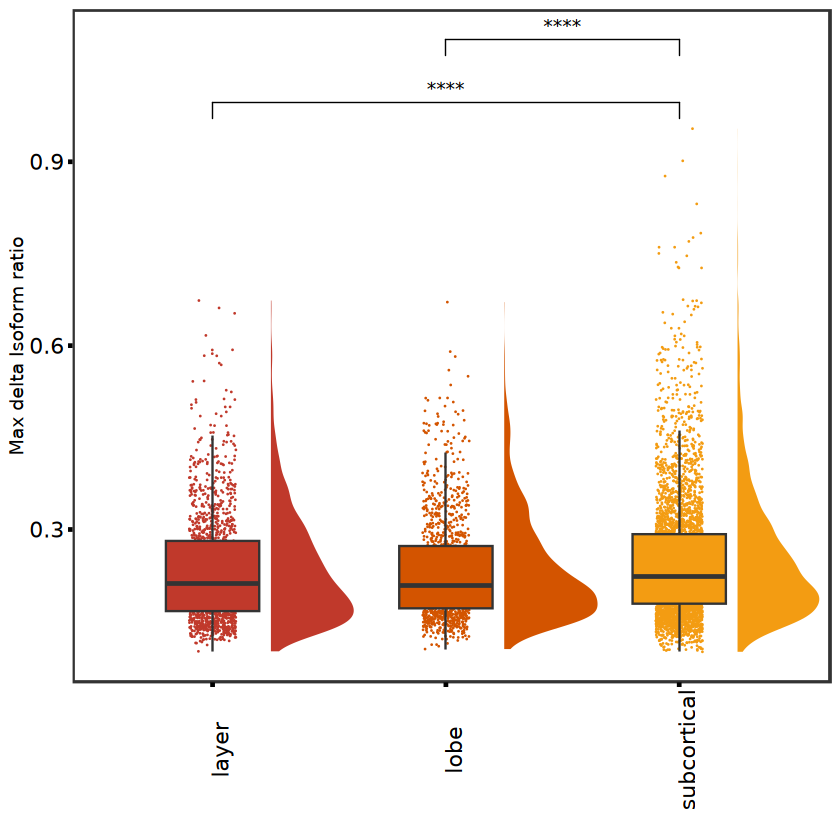

In [337]:
isosigt = NULL
isosigi = isosigls$layer
isosigi$group = "layer"
isosigi = isosigi[isosigi$transcript_id %in% isosigi[isosigi$sig != "N",]$transcript_id,]
isosigt = rbind(isosigt,isosigi)
isosigi = isosigls$subclass
# isosigi$group = "subclass"
# isosigi = isosigi[isosigi$transcript_id %in% isosigi[isosigi$sig != "N",]$transcript_id,]
# isosigt = rbind(isosigt,isosigi)
isosigi = isosigls$lobe
isosigi$group = "lobe"
isosigi = isosigi[isosigi$transcript_id %in% isosigi[isosigi$sig != "N",]$transcript_id,]
isosigt = rbind(isosigt,isosigi)

isosigt = isosigt %>% group_by(group,transcript_id) %>% summarise(maxdr = max(relative) - min(relative))
isosigi = isosigls$subcortical
isosigi$group = "subcortical"
isosigi = isosigi[isosigi$transcript_id %in% isosigi[isosigi$sig != "N",]$transcript_id,]
isosigi = isosigi %>% group_by(group,transcript_id) %>% summarise(maxdr = max(relative) - min(relative))
isosigt = rbind(isosigt,isosigi)
library(gghalves)
pbox1 = ggplot(isosigt,aes(x = group,y = maxdr,fill = group)) +
      geom_jitter(shape=21,size=0.5,width=0.1,stroke = NA) +
      geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
      geom_boxplot(width=0.4,size=0.5, outlier.color =NA) +
      stat_compare_means(label = "p.signif", method = "t.test",hide.ns = T,
                         comparisons = list(c("subcortical","layer"),c("subcortical","lobe")))  +
      theme_bw() +
      theme(panel.grid = element_blank(),legend.position = "none",
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90),
        axis.text.y = element_text(color = "black",size = 13),
        axis.ticks = element_line(color="black",linewidth = 1)) +
      scale_fill_flatui() + ylab("Max delta Isoform ratio") + xlab("")
pbox1
ggexport(pbox1,filename = "result/figure6_other_cmp/isoform_dr_cmp_layer_lobe_subcor_24_11_27.pdf",width = 3,height = 4)

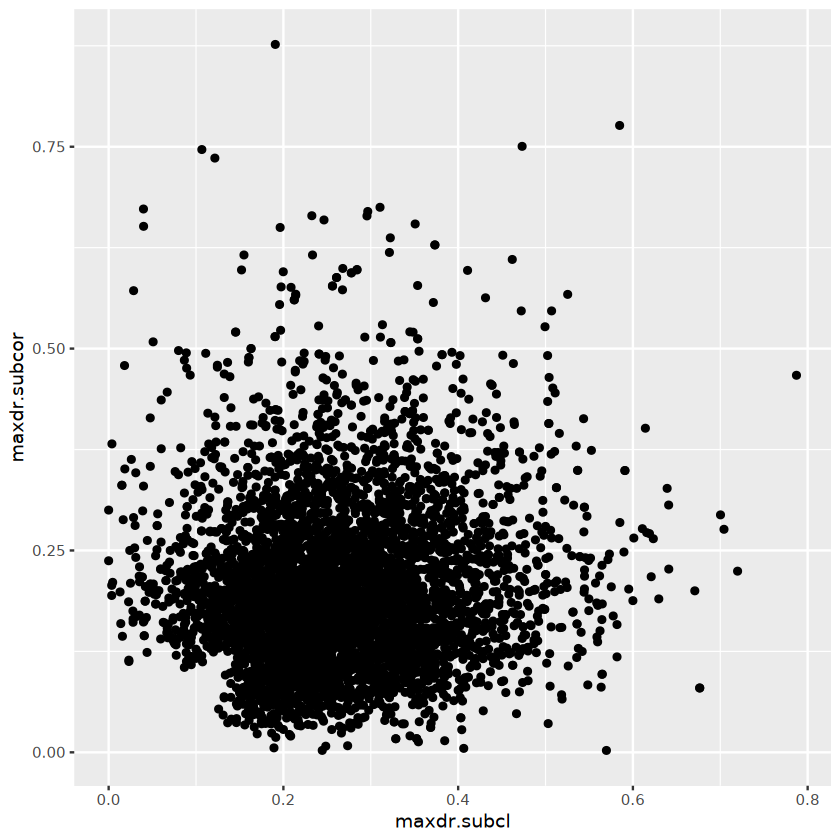

In [304]:
isosigi = isosigls$subclass
hubtrans = isosigi[isosigi$sig != "N",]$transcript_id
isosigi = isosigi %>% group_by(transcript_id) %>% summarise(maxdr.subcl = max(relative) - min(relative))

#isosigi = isosigi[isosigi$transcript_id %in% ,]
isosigi2 = isosigls$subcortical
hubtrans = unique(c(hubtrans,isosigi2[isosigi2$sig != "N",]$transcript_id))
isosigi2 = isosigi2 %>% group_by(transcript_id) %>% summarise(maxdr.subcor = max(relative) - min(relative))
isosigt = merge(isosigi2,isosigi,by = "transcript_id")
isosigt = isosigt[isosigt$transcript_id %in% hubtrans,]
ggplot(isosigt,aes(x = maxdr.subcl,y = maxdr.subcor)) + geom_point()

In [306]:
isosigl = isosigls$subcortical
huntrans1 = unique(isosigl[isosigl$sig == "Up",]$transcript_id)
isosigc = isosigls$subclass
huntrans2 = unique(isosigc[isosigc$sig == "Up",]$transcript_id)
huntrans = c(huntrans1,huntrans2)
print(length(unique(huntrans)))

isosigl = isosigl[isosigl$transcript_id %in% huntrans,]
isosigl$drl = isosigl$relative - isosigl$meanrelative
isosigl = unique(isosigl[,c("transcript_id","areatr","drl")])
colnames(isosigl)[2] = "subcortical"

isosigc$drc = isosigc$relative - isosigc$meanrelative
isosigc = isosigc[,c("transcript_id","areatr","drc")]
colnames(isosigc)[2] = "subclass"
isosigc = merge(isosigc,isosigl,by = "transcript_id")
isosigc.st = isosigc %>% group_by(subcortical,subclass) %>% summarise(cor = cor(drl,drc))
head(isosigc.st)

[1] 5191


`summarise()` has grouped output by 'subcortical'. You can override using the
`.groups` argument.


subcortical subclass cor         
1 Cerebellum  ASC       0.031530838
2 Cerebellum  L2        0.130384866
3 Cerebellum  L2/3      0.002552261
4 Cerebellum  L2/3/4   -0.135641422
5 Cerebellum  L3/4      0.007796974
6 Cerebellum  L3/4/5   -0.029292168

In [310]:
#jaccard score between module and layer
MyJaccard = function(genels1,genels2){
    calculate_jaccard <- function(list1, list2) {
      intersection <- length(intersect(list1, list2))
      union <- length(union(list1, list2))
      jaccard_score <- intersection / union
      return(jaccard_score)
    }
    num_groups1 = length(genels1)
    num_groups2 = length(genels2)
    jaccard_matrix <- matrix(0, nrow = num_groups1, ncol = num_groups2)
    
    for (i in 1:num_groups1) {
      for (j in 1:num_groups2) {
        jaccard_matrix[i, j] <- calculate_jaccard(genels1[[i]], genels2[[j]])
      }
    }
    rownames(jaccard_matrix) <- names(genels1)
    colnames(jaccard_matrix) <- names(genels2)
    return(jaccard_matrix)
}
  MyJaccarddf = function(isosig1, isosig2){
    sigglscl = list()
    areatrs = unique(isosig1$areatr)
    for (i in 1:length(areatrs)) {
      sigglscli = isosig1[isosig1$sig!="N" & isosig1$sig != "Y" &
                            isosig1$areatr == areatrs[i],]
      sigglscl[[i]] = unique(paste0(sigglscli$transcript_id,"-",sigglscli$sig))
    }
    names(sigglscl) = areatrs
    
    sigglscl2 = list()
    areatrs = unique(isosig2$areatr)
    for (i in 1:length(areatrs)) {
      sigglscl2i = isosig2[isosig2$sig!="N" & isosig2$sig != "Y" &
                            isosig2$areatr == areatrs[i],]
      sigglscl2[[i]] = unique(paste0(sigglscl2i$transcript_id,"-",sigglscl2i$sig))
    }
    names(sigglscl2) = areatrs
    
    subclcor = MyJaccard(sigglscl,sigglscl2)
    subclcor[subclcor == 1] = NA
    return(subclcor)
  }
  MyJaccarddf2 = function(isosigls.cl, isosig2){
    sigglscl = list()
    for (i in 1:length(isosigls.cl)) {
      sigglscli = isosigls.cl[[i]][isosigls.cl[[i]]$sig!="N" &
                                     isosigls.cl[[i]]$sig != "Y",]
      sigglscl[[i]] = unique(paste0(sigglscli$transcript_id,"-",sigglscli$sig))
    }
    names(sigglscl) = names(isosigls.cl)
    
    sigglscl2 = list()
    areatrs = unique(isosig2$areatr)
    for (i in 1:length(areatrs)) {
      sigglscl2i = isosig2[isosig2$sig!="N" & isosig2$sig != "Y" &
                             isosig2$areatr == areatrs[i],]
      sigglscl2[[i]] = unique(paste0(sigglscl2i$transcript_id,"-",sigglscl2i$sig))
    }
    names(sigglscl2) = areatrs
    
    subclcor = MyJaccard(sigglscl,sigglscl2)
    subclcor[subclcor == 1] = NA
    return(subclcor)
}


file saved to result/figure6_other_cmp/iso_sig_subclass_subcortical_cor_heatmap_24_11_27.pdf



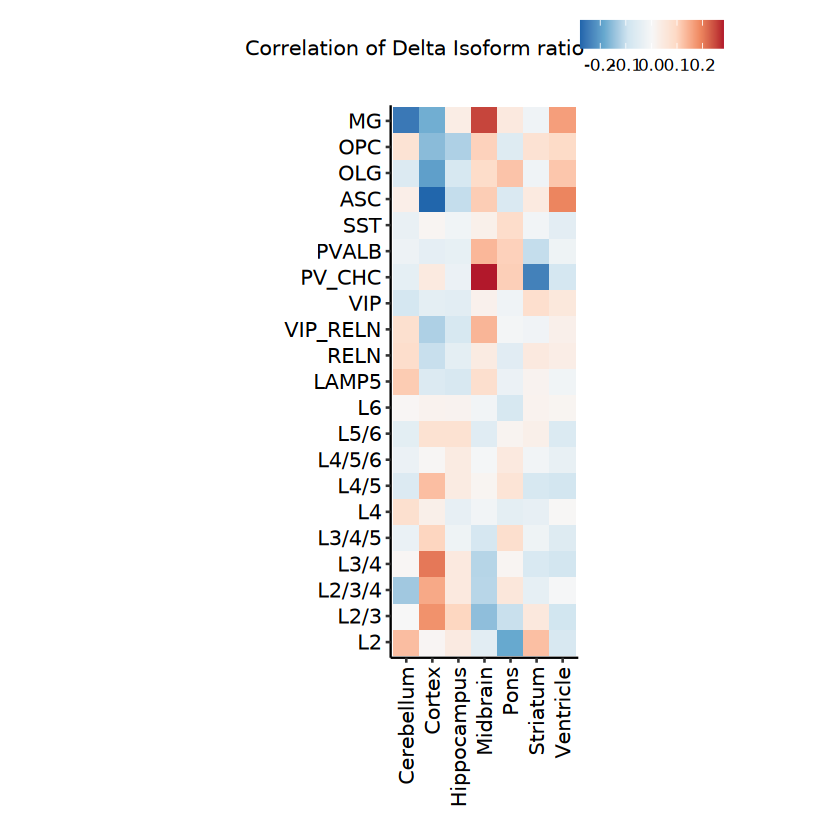

In [339]:
isosigc.st$subclass = factor(isosigc.st$subclass,levels = suborder)
p = ggplot(isosigc.st[isosigc.st$subclass != "VLMC",],aes(x = subcortical,y = subclass,fill = cor)) + geom_tile() +
theme_pubr() + scale_fill_distiller(palette = "RdBu") + coord_fixed() + xlab("") + ylab("") +  
labs(fill = "Correlation of Delta Isoform ratio") + theme(axis.text.x = element_text(angle = 90,vjust = 0.5,hjust = 1))
p
ggexport(p,filename = "result/figure6_other_cmp/iso_sig_subclass_subcortical_cor_heatmap_24_11_27.pdf",width = 4,height = 5)

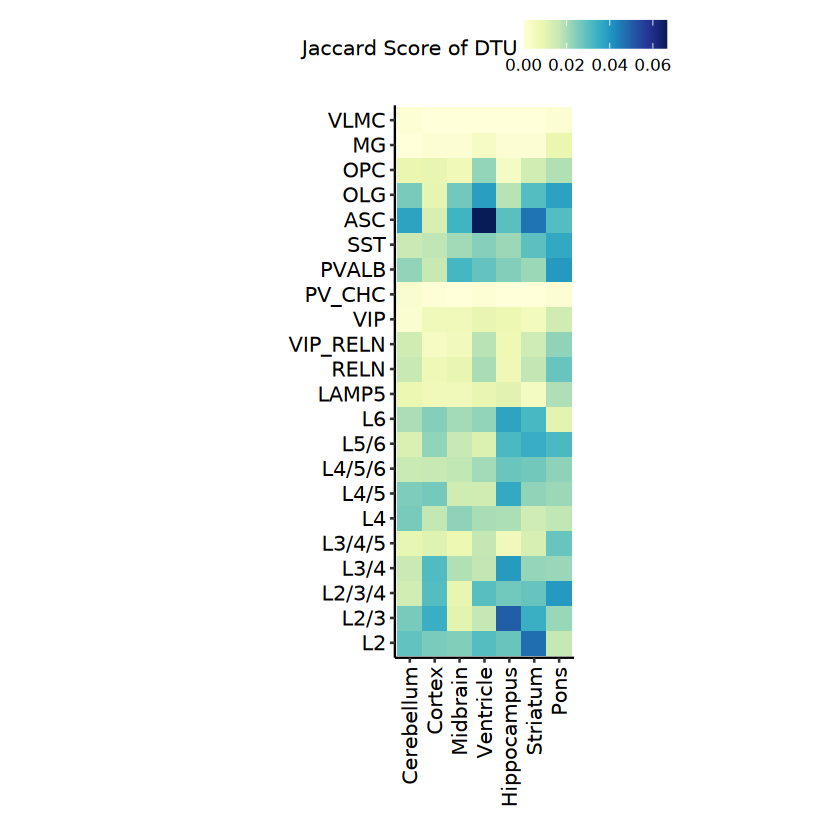

In [319]:
suborder = c('L2','L2/3','L2/3/4','L3/4','L3/4/5','L4','L4/5','L4/5/6','L5/6','L6','LAMP5','RELN',
             'VIP_RELN','VIP','PV_CHC',"PVALB",'SST','ASC','OLG','OPC','MG','EC','VLMC')
mjc = MyJaccarddf(isosigls$subclass,isosigls$subcortical)
library(RColorBrewer)
#pheatmap::pheatmap(mjc)
mjc = mjc[suborder[suborder %in% rownames(mjc)],]
mjclb = melt(mjc)
colnames(mjclb) = c("subclass","subcortical","value")
#mjclb = merge(mjclb,cellprop.lobe,by = c("subcortical","subclass"))

#mjcht = Heatmap(mjc,col =  colorRampPalette((brewer.pal(n = 9, name ="YlGnBu")))(100),cluster_columns = F,
#                cluster_rows = F,name = "Jaccard score\n by DTUs")
#mjcht
#ggexport(mjcht,filename = "result/figure4/iso_sig_subclass_layer_jaccard_heatmap_24_04_14.pdf", width = 5,height = 5)
p2 = ggplot(mjclb,aes(x = subcortical,y = subclass,fill = value)) + geom_tile() +
theme_pubr() + scale_fill_gradientn(colors = colorRampPalette((brewer.pal(n = 9, name ="YlGnBu")))(100)) + 
coord_fixed() + xlab("") + ylab("") + 
labs(fill = "Jaccard Score of DTU") + theme(axis.text.x = element_text(angle = 90,hjust = 1,vjust = 0.5))
p2

### Isoform Switch analysis R 

In [350]:
library(IsoformSwitchAnalyzeR)

Loading required package: limma

Warning message:
"package 'limma' was built under R version 4.3.3"

Attaching package: 'limma'


The following object is masked from 'package:BiocGenerics':

    plotMA


Loading required package: DEXSeq

Loading required package: BiocParallel

Loading required package: DESeq2

Loading required package: satuRn

Loading required package: sva

Loading required package: mgcv

Loading required package: nlme


Attaching package: 'nlme'


The following object is masked from 'package:Biostrings':

    collapse


The following object is masked from 'package:dplyr':

    collapse


The following object is masked from 'package:IRanges':

    collapse


This is mgcv 1.9-0. For overview type 'help("mgcv-package")'.

Loading required package: genefilter


Attaching package: 'genefilter'


The following object is masked from 'package:patchwork':

    area


The following object is masked from 'package:ComplexHeatmap':

    dist2


The following objects are masked fro

In [ ]:
aSwitchList <- importRdata(
    isoformCountMatrix   = salmonQuant$counts,
    isoformRepExpression = salmonQuant$abundance,
    designMatrix         = myDesign,
    isoformExonAnnoation = system.file("ref/bambu_extended_annotations_novelname.gtf", 
                                       package="IsoformSwitchAnalyzeR"),
    isoformNtFasta       = system.file("../ref/GCF_000364345.1_Macaca_fascicularis_5.0_genomic.fa", 
                                       package="IsoformSwitchAnalyzeR"),
    fixStringTieAnnotationProblem = TRUE,
    showProgress = FALSE
)

In [ ]:
### Extract shifts
locChange <- extractSubCellShifts(
    exampleSwitchListAnalyzed,
    returnResult = TRUE # returns data insted of plot
)

### Sort
locChange <- locChange[sort.list(
    locChange$n_genes,
    decreasing = TRUE
),]

### View
head(locChange, 3)
#> # A tibble: 3 × 6
extractSplicingEnrichment(
    exampleSwitchListAnalyzed,
    returnResult = FALSE # if TRUE returns a data.frame with the summary statistics
)

In [ ]:
myDesign <- data.frame(
    sampleID = colnames(salmonQuant$abundance)[-1],
    condition = gsub('_.*', '', colnames(salmonQuant$abundance)[-1])
)

## RNA editing analysis

### Genome liftover

In [7]:
# specify coordinates to liftover
#grObject <- GRanges(seqnames=c("chr1"), ranges=IRanges(start=226061851, end=226071523))

# import the chain file
chainObject <- import.chain("ref/RNA_editing_site/hg38ToMacFas5.over.chain")
head(chainObject)
# run liftOver
#results <- as.data.frame(liftOver(grObject, chainObject))

Chain of length 6
names(6): chr22 chr21 chr20 chr19 chr18 chrY

In [9]:
#load human RNA A to I site
refred = read.delim("ref/RNA_editing_site/TABLE1_hg38.txt.gz",header = T)
head(refred)

Region Position Ref Ed Strand db type dbsnp repeat.   
1 chr1   87158    T   C  -      A  ALU  -     SINE/AluJo
2 chr1   87168    T   C  -      A  ALU  -     SINE/AluJo
3 chr1   87171    T   C  -      A  ALU  -     SINE/AluJo
4 chr1   87189    T   C  -      A  ALU  -     SINE/AluJo
5 chr1   87218    T   C  -      A  ALU  -     SINE/AluJo
6 chr1   87225    T   C  -      A  ALU  -     SINE/AluJo
  Func.wgEncodeGencodeBasicV34 ⋯ Gene.refGene GeneDetail.refGene
1 intergenic                   ⋯ -            -                 
2 intergenic                   ⋯ -            -                 
3 intergenic                   ⋯ -            -                 
4 intergenic                   ⋯ -            -                 
5 intergenic                   ⋯ -            -                 
6 intergenic                   ⋯ -            -                 
  ExonicFunc.refGene AAChange.refGene Func.knownGene Gene.knownGene
1 intergenic         OR4F5;AL627309.1 -              -             
2 intergenic         OR4F5;AL627309.1 -              -             
3 intergenic         OR4F5;AL627309.1 -              -             
4 intergenic         OR4F5;AL627309.1 -              -             
5 intergenic         OR4F5;AL627309.1 -              -             
6 intergenic         OR4F5;AL627309.1 -              -             
  GeneDetail.knownGene ExonicFunc.knownGene AAChange.knownGene
1 -                    NA                   NA                
2 -                    NA                   NA                
3 -                    NA                   NA                
4 -                    NA                   NA                
5 -                    NA                   NA                
6 -                    NA                   NA                
  phastConsElements100way
1 NA                     
2 NA                     
3 NA                     
4 NA                     
5 NA                     
6 NA

In [11]:
refred.site = GRanges(seqnames=c(refred$Region), ranges=IRanges(start=refred$Position, end=refred$Position),strand = refred$Strand)
refred.site.mac = as.data.frame(liftOver(refred.site, chainObject))
head(refred.site.mac)
nrow(refred.site.mac)
qsave(refred.site.mac,file = "ref/RNA_editing_site/TABLE1_macf5.0_from_hg38.qs")

GRanges object with 6 ranges and 0 metadata columns:
      seqnames    ranges strand
         <Rle> <IRanges>  <Rle>
  [1]     chr1     87158      -
  [2]     chr1     87168      -
  [3]     chr1     87171      -
  [4]     chr1     87189      -
  [5]     chr1     87218      -
  [6]     chr1     87225      -
  -------
  seqinfo: 44 sequences from an unspecified genome; no seqlengths

In [4]:
refred.site.mac = qread("ref/RNA_editing_site/TABLE1_macf5.0_from_hg38.qs")
chrmap = read.table("ref/RNA_editing_site/chrmap.txt")
head(chrmap)
head(refred.site.mac)

V1 V2         V3          V4          V5   V6
1 1  CM001919.1 NC_022272.1 227,556,264 41.5 28
2 2  CM001920.1 NC_022273.1 192,460,366 39.5 20
3 3  CM001921.1 NC_022274.1 192,294,377 40.5 41
4 4  CM001922.1 NC_022275.1 170,955,103 39.5 69
5 5  CM001923.1 NC_022276.1 189,454,096 38.0 22
6 6  CM001924.1 NC_022277.1 181,584,905 39.5 15

group group_name seqnames start   end     width strand
1 44    NA         chr1     6419665 6419665 1     +     
2 45    NA         chr1     6419558 6419558 1     +     
3 46    NA         chr1     6419555 6419555 1     +     
4 47    NA         chr1     6419549 6419549 1     +     
5 48    NA         chr1     6419505 6419505 1     +     
6 49    NA         chr1     6419431 6419431 1     +

In [5]:
#chr transfer
chrmap$V1 = paste0("chr",chrmap$V1)
refred.site.mac$seqnames_ncbi = chrmap[match(refred.site.mac$seqnames, chrmap$V1), ]$V3
head(refred.site.mac)

group group_name seqnames start   end     width strand seqnames_ncbi
1 44    NA         chr1     6419665 6419665 1     +      NC_022272.1  
2 45    NA         chr1     6419558 6419558 1     +      NC_022272.1  
3 46    NA         chr1     6419555 6419555 1     +      NC_022272.1  
4 47    NA         chr1     6419549 6419549 1     +      NC_022272.1  
5 48    NA         chr1     6419505 6419505 1     +      NC_022272.1  
6 49    NA         chr1     6419431 6419431 1     +      NC_022272.1

In [6]:
qsave(refred.site.mac,file = "ref/RNA_editing_site/TABLE1_macf5.0_from_hg38.qs")

### Select RNA editing position

#### Pre process RNA mismatch position

Call mismatch from bam file in shell:
```shell
jvarkit sam2tsv -R $ref $input --skip-N -o $outfile
awk 'BEGIN {FS=OFS="\t"} $6 != $9 {print}' $outfile > ${outfile}.fi
input=/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/pacbio_revio_process/pacbio_MAS-15_24-03-12/count_mismatch/
awk 'BEGIN {FS=OFS="\t"} $10 == "X" {print}' ${input}/full_sam.tsv.fil > ${input}/full_sam.tsv.filmml
sl

Call mismatch site coverage in shell:
```shell
bedtools intersect -wa -wb -a /cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/data/snp_analysis/mismatch_pos_ref.bed -b /cluster/home/liuhengxin/P1_brain_nanopore/processed_data/pacbio_revio_process/pacbio_Mas_processdata_merged_minimap_sorted_24_03_21.bam > /cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/data/snp_analysis/mismatch_pos_ref_coverage.txt

cut -f 1,2,7 /cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/data/snp_analysis/mismatch_pos_ref_coverage.txt > /cluster/home/liuhengxin/P1_brain_nanopore/downstream_analysis/data/snp_analysis/mismatch_pos_ref_coverage_short.txt


In [ ]:
# #loading snpcount
# snpcount1 = fread("/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/pacbio_revio_process/pacbio_MAS-16_24-02-22/count_mismatch/full_sam.tsv.fil.mls",
#                  header = F)
# snpcount2 = fread("/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/pacbio_revio_process/pacbio_MAS-15_24-03-12/count_mismatch/full_sam.tsv.fil.mls",
#                  header = F)
# snpcount = rbind(snpcount1,snpcount2)
# colnames(snpcount) = c("readid","Flag","MAPQ","CHROM","READ-POS0","READ-BASE","READ-QUAL","REF-POS1","REF-BASE","CIGAR-OP")
# head(snpcount)
# qsave(snpcount,"/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/pacbio_revio_process/snp_analysis/pac-15_snpcount_total_24_03_22.qs")
readan = qread("data/reads_full_anotation/read_total_annotation_pacbio_24_03_22.qs") 
snpcount = merge(snpcount,readan,by = "readid")
qsave(snpcount,"data/snp_analysis/read_snpcount_withan_24_03_22.qs")

In [29]:
snpcount = qread("data/snp_analysis/read_snpcount_withan_24_03_22.qs")
head(snpcount)

readid                                          Flag MAPQ CHROM      
1 m84075_240302_105507_s3/100007990/ccs/1411_2171 0    60   NC_022292.1
2 m84075_240302_105507_s3/100007994/ccs/5387_5827 0    60   NC_022274.1
3 m84075_240302_105507_s3/100007994/ccs/5387_5827 0    60   NC_022274.1
4 m84075_240302_105507_s3/100007994/ccs/5387_5827 0    60   NC_022274.1
5 m84075_240302_105507_s3/100007994/ccs/5387_5827 0    60   NC_022274.1
6 m84075_240302_105507_s3/100007999/ccs/52_427    0    60   NC_022287.1
  READ-POS0 READ-BASE READ-QUAL REF-POS1  REF-BASE CIGAR-OP ⋯
1 469       G         I         150780603 A        X        ⋯
2 225       A         D          29307766 G        X        ⋯
3 306       A         <          29307847 G        X        ⋯
4 347       A         +          29307888 G        X        ⋯
5 415       A         I          29307955 G        X        ⋯
6 145       G         I          58387732 A        X        ⋯
  cell_type              subclass class layer area lobe     tranid type      
1                                       l6    TEpd temporal  89857 equal     
2                                       l3    PE   parietal 109778 equal     
3                                       l3    PE   parietal 109778 equal     
4                                       l3    PE   parietal 109778 equal     
5                                       l3    PE   parietal 109778 equal     
6 GLU L5/6.4 IL36B/MCHR2 L5/6     GLU   l6    CM   auditory  69000 compatible
  tranname       gene_id     
1 XM_015444245.1 SSR4        
2 XR_001489174.1 LOC102136839
3 XR_001489174.1 LOC102136839
4 XR_001489174.1 LOC102136839
5 XR_001489174.1 LOC102136839
6 XM_005584531.2 MAPT

#### filter mismatch site

In [31]:
#filter with MAPQ
nrow(snpcount)
snpcount = snpcount[snpcount$`CIGAR-OP` == "X",]
snpcount = snpcount[snpcount$MAPQ >= 30,]
nrow(snpcount)

#filter with REDtools site reference
snpcount$editype = paste0(snpcount$`REF-BASE`,"->",snpcount$`READ-BASE`)
snpcount$pos = paste0(snpcount$CHROM,"_",snpcount$`REF-POS1`)
snpcount$poseditype = paste0(snpcount$pos,"_",snpcount$editype)
refred.site.mac$pos = paste0(refred.site.mac$seqnames_ncbi,"_",refred.site.mac$start)
snpcount = snpcount[snpcount$pos %in% refred.site.mac$pos,]
nrow(snpcount)

#filter by snp annotation
vcfref = read.table("/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/pacbio_revio_process/L_GIREMI/9541_GCA_000364345.1_current_ids_newchr.vcf",comment.char = "#",header = F)
colnames(vcfref) = c("CHROM", "POS", "ID","REF","ALT","QUAL","FILTER","INFO")
vcfref$mispos = paste0(vcfref$CHROM,"_",vcfref$POS,"_",vcfref$REF,"->",vcfref$ALT)
snpcount = snpcount[!snpcount$poseditype %in% vcfref$mispos,]
nrow(snpcount)
qsave(snpcount,"data/snp_analysis/pac-15_snpcount_total_filter_24_04_10.qs")

#filter with splice site
gtfdf = as.data.frame(gtf)
gtfdf = unique(gtfdf[,c("gene_id","strand")])
snpcount$gstrand = gtfdf[match(snpcount$gene_id,gtfdf$gene_id),]$strand
spsite = as.data.frame(gtf[gtf$type == "exon",])
spsite = unique(spsite[c(1:3,5)])
spsites = spsite[,c(1,2,4)]
spsitee = spsite[,c(1,3,4)]
colnames(spsites) = colnames(spsitee) = c("seqnames","start","strand")
spsite = unique(rbind(spsites,spsitee))
head(spsite)
spsite = data.frame("seqnames" = rep(spsite$seqnames,each = 9), 
                    "start" = as.vector(sapply(spsite$start,function(x){(x-4):(x+4)})), 
                    "strand" = rep(spsite$strand,each = 9))
spsite = paste0(spsite$seqnames,"_",spsite$start,"_",spsite$strand)
snpcount$postrand = paste0(snpcount$CHROM,"_",snpcount$`REF-POS1`,"_",snpcount$gstrand)
snpcount = snpcount[!snpcount$postrand %in% spsite,]
nrow(snpcount)

[1] 172532162

[1] 144677031

[1] 2411148

[1] 2406269

seqnames    start strand
1 NC_012670.1   620 +     
2 NC_012670.1  1633 +     
3 NC_012670.1  1637 -     
4 NC_012670.1  2354 -     
5 NC_022272.1  8899 -     
6 NC_022272.1 35219 -

[1] 2388037

In [32]:
qsave(snpcount,"data/snp_analysis/pac-15_snpcount_total_filter_24_04_10.qs")

#### Switch strand base

In [64]:
#reverse base according to strand
snpcount$alstrand = "+"
snpcount[snpcount$Flag %in% c(16, 2064),]$alstrand = "-"
#transfer base by RNA strand
complement_base <- function(base) {
  complement_map <- c(A = "T", T = "A", C = "G", G = "C")
  return(complement_map[base])
}
snpcount = snpcount[snpcount$`REF-BASE` %in% c("A","G","C","T"),]
table(snpcount$editype)/sum(table(snpcount$editype))
editst = snpcount %>% group_by(editype) %>% summarise(sitenum = length(unique(pos)))
editst$prop = editst$sitenum/sum(editst$sitenum)
editst

snpcount[snpcount$alstrand == "-",]$`READ-BASE` = complement_base(snpcount[snpcount$alstrand == "-",]$`READ-BASE`)
snpcount[snpcount$alstrand == "-",]$`REF-BASE` = complement_base(snpcount[snpcount$alstrand == "-",]$`REF-BASE`)
snpcount$editype = paste0(snpcount$`REF-BASE`,"->",snpcount$`READ-BASE`)
table(snpcount$editype)/sum(table(snpcount$editype))
editst = snpcount %>% group_by(editype) %>% summarise(sitenum = length(unique(pos)))
editst$prop = editst$sitenum/sum(editst$sitenum)
editst
qsave(snpcount,"data/snp_analysis/pac-15_snpcount_total_filter_strand_switch_24_04_10.qs")


       A->C        A->G        A->T        C->A        C->G        C->T 
0.031871623 0.333522681 0.022461564 0.004931499 0.003925467 0.044834932 
       G->A        G->C        G->T        T->A        T->C        T->G 
0.038076730 0.003249796 0.006248458 0.026082082 0.466057268 0.018737901 

editype sitenum prop       
1  A->C     173    0.011812905
2  A->G    5062    0.345646978
3  A->T     299    0.020416524
4  C->A      61    0.004165244
5  C->G      40    0.002731308
6  C->T     449    0.030658928
7  G->A     348    0.023762376
8  G->C      34    0.002321611
9  G->T      77    0.005257767
10 T->A     273    0.018641174
11 T->C    7637    0.521474906
12 T->G     192    0.013110277


       A->C        A->G        A->T        C->A        C->G        C->T 
0.032979304 0.631701210 0.020557129 0.007789645 0.004345519 0.027011877 
       G->A        G->C        G->T        T->A        T->C        T->G 
0.055899785 0.002829744 0.003390312 0.027986516 0.167878738 0.017630220 

editype sitenum prop       
1  A->C      223   0.012496498
2  A->G    11530   0.646119361
3  A->T      259   0.014513869
4  C->A      111   0.006220230
5  C->G       49   0.002745867
6  C->T      351   0.019669375
7  G->A      634   0.035528159
8  G->C       42   0.002353600
9  G->T       59   0.003306248
10 T->A      405   0.022695433
11 T->C     3982   0.223143738
12 T->G      200   0.011207621

##### Process reference coverage

In [16]:
filels = list.files("data/snp_analysis/mismatch_pos_ref_coverage_split/",full.names = T,pattern = "*.qs")
filels
covereadi = qread(filels[5])

[1] "data/snp_analysis/mismatch_pos_ref_coverage_split//split1.qs" 
 [2] "data/snp_analysis/mismatch_pos_ref_coverage_split//split10.qs"
 [3] "data/snp_analysis/mismatch_pos_ref_coverage_split//split11.qs"
 [4] "data/snp_analysis/mismatch_pos_ref_coverage_split//split12.qs"
 [5] "data/snp_analysis/mismatch_pos_ref_coverage_split//split13.qs"
 [6] "data/snp_analysis/mismatch_pos_ref_coverage_split//split14.qs"
 [7] "data/snp_analysis/mismatch_pos_ref_coverage_split//split15.qs"
 [8] "data/snp_analysis/mismatch_pos_ref_coverage_split//split16.qs"
 [9] "data/snp_analysis/mismatch_pos_ref_coverage_split//split17.qs"
[10] "data/snp_analysis/mismatch_pos_ref_coverage_split//split18.qs"
[11] "data/snp_analysis/mismatch_pos_ref_coverage_split//split19.qs"
[12] "data/snp_analysis/mismatch_pos_ref_coverage_split//split2.qs" 
[13] "data/snp_analysis/mismatch_pos_ref_coverage_split//split20.qs"
[14] "data/snp_analysis/mismatch_pos_ref_coverage_split//split3.qs" 
[15] "data/snp_analysis/mismatch_pos_ref_coverage_split//split4.qs" 
[16] "data/snp_analysis/mismatch_pos_ref_coverage_split//split5.qs" 
[17] "data/snp_analysis/mismatch_pos_ref_coverage_split//split6.qs" 
[18] "data/snp_analysis/mismatch_pos_ref_coverage_split//split7.qs" 
[19] "data/snp_analysis/mismatch_pos_ref_coverage_split//split8.qs" 
[20] "data/snp_analysis/mismatch_pos_ref_coverage_split//split9.qs"

In [19]:
#preprocess coverage
#load coverage bed file
# filels = list.files("data/snp_analysis/mismatch_pos_ref_coverage_split/",full.names = T)
# filels
# library(dplyr)
# covereadan.st = NULL
# for(i in 1:length(filels)){
#     print(i)
#     coveread = fread(filels[i],header = F)
#     colnames(coveread) = c("chr","pos","readid")
#     coveread = coveread[coveread$readid %in% readan$readid,]
#     coveread$refpos = paste0(coveread$chr,"_",coveread$pos)
#     coveread = coveread[,c(3,4)]
#     nrow(coveread)
#     coveread = merge(readanuq, coveread,by = "readid")
#     covereadan.sti = coveread %>% group_by(refpos,layer,class,subclass,lobe,area,subcortical,blockid) %>% summarise(readnum = length(unique(readid)))
#     head(covereadan.sti)
#     qsave(covereadan.sti,file = paste0("data/snp_analysis/mismatch_pos_ref_coverage_split/split",i,".qs"))
#     covereadan.st = rbind(covereadan.st,covereadan.sti)
# }
# qsave(covereadan.st,file = "data/snp_analysis/mismatch_pos_ref_coverage_st_24_03_28.qs")

coveread = NULL
for(i in 1:length(filels)){
    print(i)
    covereadi = qread(filels[i])
    covereadi = covereadi[covereadi$refpos %in% refred.site.mac$pos,]
    coveread = rbind(coveread,covereadi)
}
coveread = coveread %>% group_by(refpos,layer,class,subclass,lobe,area,subcortical,blockid) %>% summarise(readnum = sum(readnum))
coveread.st = coveread %>% group_by(refpos) %>% summarise(readnum = sum(readnum))
head(coveread)
qsave(coveread,file = "data/snp_analysis/mismatch_red_pos_ref_coverage_st_24_04_10.qs")

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20


`summarise()` has grouped output by 'refpos', 'layer', 'class', 'subclass',
'lobe', 'area', 'subcortical'. You can override using the `.groups` argument.


refpos                layer class subclass lobe      area subcortical
1 NC_022272.1_100089594 l3                   auditory  AI   Cortex     
2 NC_022272.1_100089594 l3                   cingulate 23c  Cortex     
3 NC_022272.1_100089594 l3                   parietal  PEa  Cortex     
4 NC_022272.1_100089594 l3                   temporal  PGa  Cortex     
5 NC_022272.1_100089594 l3                   temporal  TEO  Cortex     
6 NC_022272.1_100089594 l3    GABA  PVALB    occipital V4t  Cortex     
  blockid     readnum
1 38500_55500 1      
2 6500_43500  1      
3 25500_42500 1      
4 36500_65500 1      
5 52500_73500 1      
6 50500_68500 1

In [38]:
snpcount.st = snpcount %>% group_by(pos,poseditype) %>% summarise(readnum = length(unique(readid)))
head(snpcount.st)
colnames(coveread.st)[2] = "readnumt"
snpcount.st = merge(snpcount.st,coveread.st,by.x = "pos",by.y = "refpos")

`summarise()` has grouped output by 'pos'. You can override using the `.groups`
argument.


pos                   poseditype                 readnum
1 NC_022272.1_100089594 NC_022272.1_100089594_A->G 1      
2 NC_022272.1_100089627 NC_022272.1_100089627_A->G 2      
3 NC_022272.1_100089632 NC_022272.1_100089632_A->G 2      
4 NC_022272.1_100089669 NC_022272.1_100089669_A->G 2      
5 NC_022272.1_100089693 NC_022272.1_100089693_A->G 1      
6 NC_022272.1_100089705 NC_022272.1_100089705_A->G 4

In [43]:
#filter using coverage
nrow(snpcount.st)
snpcount.st$ratio = snpcount.st$readnum / snpcount.st$readnumt
snpcount.stf = snpcount.st[snpcount.st$ratio < 0.90 & snpcount.st$readnum > 3,]
nrow(snpcount.stf)
summary(snpcount.stf$ratio)

[1] 117032

[1] 14645

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000131 0.0249799 0.0980392 0.1878621 0.2857143 0.8965517 

In [65]:
snpcount = snpcount[snpcount$poseditype %in% snpcount.stf$poseditype,]
nrow(snpcount)
qsave(snpcount,"data/snp_analysis/pac-15_snpcount_total_filter_strand_switch_coverage_24_04_10.qs")

[1] 668965

### Calculate brain region RNA editing feature

In [46]:
head(coveread)
head(snpcount)

refpos                layer class subclass lobe      area subcortical
1 NC_022272.1_100089594 l3                   auditory  AI   Cortex     
2 NC_022272.1_100089594 l3                   cingulate 23c  Cortex     
3 NC_022272.1_100089594 l3                   parietal  PEa  Cortex     
4 NC_022272.1_100089594 l3                   temporal  PGa  Cortex     
5 NC_022272.1_100089594 l3                   temporal  TEO  Cortex     
6 NC_022272.1_100089594 l3    GABA  PVALB    occipital V4t  Cortex     
  blockid     readnum
1 38500_55500 1      
2 6500_43500  1      
3 25500_42500 1      
4 36500_65500 1      
5 52500_73500 1      
6 50500_68500 1

readid                                          Flag MAPQ CHROM      
1 m84075_240302_105507_s3/100008022/ccs/1558_2446  0   60   NC_022290.1
2 m84075_240302_105507_s3/100008022/ccs/1558_2446  0   60   NC_022290.1
3 m84075_240302_105507_s3/100008022/ccs/1558_2446  0   60   NC_022290.1
4 m84075_240302_105507_s3/100008022/ccs/1558_2446  0   60   NC_022290.1
5 m84075_240302_105507_s3/100008111/ccs/8350_9479 16   60   NC_022290.1
6 m84075_240302_105507_s3/100008634/ccs/409_1265   0   60   NC_022275.1
  READ-POS0 READ-BASE READ-QUAL REF-POS1 REF-BASE CIGAR-OP ⋯ tranid type      
1 615       C         I         48306852 T        X        ⋯ 10074  compatible
2 649       C         I         48306887 T        X        ⋯ 10074  compatible
3 741       C         I         48306979 T        X        ⋯ 10074  compatible
4 749       C         I         48306987 T        X        ⋯ 10074  compatible
5 602       G         I         18601176 A        X        ⋯ 86477  compatible
6 257       A         I          4823454 C        X        ⋯ 94119  compatible
  tranname       gene_id         editype pos                 
1 BambuTx174204  BambuGene129239 T->C    NC_022290.1_48306852
2 BambuTx174204  BambuGene129239 T->C    NC_022290.1_48306887
3 BambuTx174204  BambuGene129239 T->C    NC_022290.1_48306979
4 BambuTx174204  BambuGene129239 T->C    NC_022290.1_48306987
5 XM_015440865.1 PDE4C           A->G    NC_022290.1_18601176
6 XM_015448507.1 LOC102128285    C->A    NC_022275.1_4823454 
  poseditype                gstrand postrand               alstrand
1 NC_022290.1_48306852_T->C +       NC_022290.1_48306852_+ +       
2 NC_022290.1_48306887_T->C +       NC_022290.1_48306887_+ +       
3 NC_022290.1_48306979_T->C +       NC_022290.1_48306979_+ +       
4 NC_022290.1_48306987_T->C +       NC_022290.1_48306987_+ +       
5 NC_022290.1_18601176_A->G -       NC_022290.1_18601176_- -       
6 NC_022275.1_4823454_C->A  +       NC_022275.1_4823454_+  +

In [49]:
ra = 500
snpcount$xid = as.integer(snpcount$x/(ra*2)) * ra * 2 + ra
snpcount$yid = as.integer(snpcount$y/(ra*2)) * ra * 2 + ra
snpcount$blockid = paste0(snpcount$xid,"_", snpcount$yid)

groupan = data.frame("abv" = c("cb","cortex","HC","mb","p","str","v"),
                       "ano" = c("cerebellum","Cortex","Hippocampus","Midbrain",
                                 "Pons","Striatum","Ventricle"))
  
snpcount$groupan = snpcount$layer
snpcount[snpcount$groupan %in% paste0("l",1:6),]$groupan = "cortex"
snpcount = snpcount[snpcount$groupan != "c",]
snpcount$subcortical = groupan[match(snpcount$groupan,groupan$abv),]$ano

In [70]:
table(paste0(snpcount$editype,snpcount$gstrand))
table(paste0(snpcount$editype,snpcount$alstrand))
snpcountf = snpcount[snpcount$editype == "A->G",]
snpcountf$poseditype = paste0(snpcountf$pos,"_",snpcountf$editype)
length(unique(snpcount$pos))
length(unique(snpcountf$pos))
write.csv(snpcountf,file = "result/figure6_snp_analysis/RNA_edit_site_information_24_04_11.csv",quote = F, row.names = F)


 A->C-  A->C+  A->G-  A->G+  A->T-  A->T+  C->A-  C->A+  C->G-  C->G+  C->T- 
 11083  10979 258139 164447   6944   6808   3324   1887   1175   1732   9345 
 C->T+  G->A-  G->A+  G->C-  G->C+  G->T-  G->T+  T->A-  T->A+  T->C-  T->C* 
  8725  22087  15308   1366    527   1528    740   9973   8749  57605      6 
 T->C+  T->G-  T->G+ 
 54694   8072   3722 


 A->C-  A->C+  A->G-  A->G+  A->T-  A->T+  C->A-  C->A+  C->G-  C->G+  C->T- 
  9653  12409 260292 162294   8704   5048   3279   1932   1732   1175   9756 
 C->T+  G->A-  G->A+  G->C-  G->C+  G->T-  G->T+  T->A-  T->A+  T->C-  T->C+ 
  8314  21679  15716   1451    442   1367    901   9978   8744  60821  51484 
 T->G-  T->G+ 
  8912   2882 

[1] 14468

[1] 11530

In [66]:
snpcountf = read.csv("result/figure6_snp_analysis/RNA_edit_site_information_24_04_11.csv")
head(snpcountf)

readid                                         Flag MAPQ CHROM      
1 m84075_240302_105507_s3/100009075/ccs/835_2112 0    60   NC_022278.1
2 m84075_240302_105507_s3/100009075/ccs/835_2112 0    60   NC_022278.1
3 m84075_240302_105507_s3/100009075/ccs/835_2112 0    60   NC_022278.1
4 m84075_240302_105507_s3/100009075/ccs/835_2112 0    60   NC_022278.1
5 m84075_240302_105507_s3/100009075/ccs/835_2112 0    60   NC_022278.1
6 m84075_240302_105507_s3/100009075/ccs/835_2112 0    60   NC_022278.1
  READ.POS0 READ.BASE READ.QUAL REF.POS1  REF.BASE CIGAR.OP ⋯
1 877       G         I         120881600 A        X        ⋯
2 877       G         I         120881600 A        X        ⋯
3 877       G         I         120881600 A        X        ⋯
4 882       G         I         120881605 A        X        ⋯
5 882       G         I         120881605 A        X        ⋯
6 882       G         I         120881605 A        X        ⋯
  pos                   poseditype                 gstrand
1 NC_022278.1_120881600 NC_022278.1_120881600_A->G +      
2 NC_022278.1_120881600 NC_022278.1_120881600_A->G +      
3 NC_022278.1_120881600 NC_022278.1_120881600_A->G +      
4 NC_022278.1_120881605 NC_022278.1_120881605_A->G +      
5 NC_022278.1_120881605 NC_022278.1_120881605_A->G +      
6 NC_022278.1_120881605 NC_022278.1_120881605_A->G +      
  postrand                alstrand xid   yid   blockid     groupan subcortical
1 NC_022278.1_120881600_+ +        46500 54500 46500_54500 cortex  Cortex     
2 NC_022278.1_120881600_+ +        46500 54500 46500_54500 cortex  Cortex     
3 NC_022278.1_120881600_+ +        46500 54500 46500_54500 cortex  Cortex     
4 NC_022278.1_120881605_+ +        46500 54500 46500_54500 cortex  Cortex     
5 NC_022278.1_120881605_+ +        46500 54500 46500_54500 cortex  Cortex     
6 NC_022278.1_120881605_+ +        46500 54500 46500_54500 cortex  Cortex

In [67]:
coveread = qread(file = "data/snp_analysis/mismatch_red_pos_ref_coverage_st_24_04_10.qs")
head(coveread)

refpos                layer class subclass lobe      area subcortical
1 NC_022272.1_100089594 l3                   auditory  AI   Cortex     
2 NC_022272.1_100089594 l3                   cingulate 23c  Cortex     
3 NC_022272.1_100089594 l3                   parietal  PEa  Cortex     
4 NC_022272.1_100089594 l3                   temporal  PGa  Cortex     
5 NC_022272.1_100089594 l3                   temporal  TEO  Cortex     
6 NC_022272.1_100089594 l3    GABA  PVALB    occipital V4t  Cortex     
  blockid     readnum
1 38500_55500 1      
2 6500_43500  1      
3 25500_42500 1      
4 36500_65500 1      
5 52500_73500 1      
6 50500_68500 1

In [70]:
groupan = data.frame("abv" = c("cb","cortex","HC","mb","p","str","v"),
                       "ano" = c("cerebellum","Cortex","Hippocampus","Midbrain",
                                 "Pons","Striatum","Ventricle"))
readan = qread("data/reads_full_anotation/read_total_annotation_pacbio_24_03_22.qs") 
readan$groupan = readan$layer
readan[readan$groupan %in% paste0("l",1:6),]$groupan = "cortex"
readan = readan[readan$groupan != "c",]
readan$subcortical = groupan[match(readan$groupan,groupan$abv),]$ano
#block id
ra = 500
readan$xid = as.integer(readan$x/(ra*2)) * ra * 2 + ra
readan$yid = as.integer(readan$y/(ra*2)) * ra * 2 + ra
readan$blockid = paste0(readan$xid,"_", readan$yid)

In [95]:
#stat per edit site proportion compare to coverage. in subcorical
#colnames(coveread)[1] = "pos"

#snpcountf[snpcountf$areatr != "Cortex",]$areatr = "Other"
#coveread[coveread$areatr != "Cortex",]$areatr = "Other"
StatSiteEditRate = function(snpcountf,readan){
    editpst2.subcor = snpcountf %>% group_by(areatr,blockid) %>% summarise(readnum = length(unique(readid)))
    readanst = readan %>% group_by(areatr,blockid) %>% summarise(readnumt = length(unique(readid)))
    editpst2.subcor = merge(editpst2.subcor,readanst,by = c("areatr","blockid"))
    editpst2.subcor$editpop = editpst2.subcor$readnum/editpst2.subcor$readnumt
    nrow(editpst2.subcor)
    editpst2.subcor = editpst2.subcor[editpst2.subcor$readnumt > 10,]
    nrow(editpst2.subcor)
    return(editpst2.subcor)
}

snpcountf$areatr = snpcountf$subcortical
readan$areatr = readan$subcortical
editpst2.subcor = StatSiteEditRate(snpcountf,readan)


`summarise()` has grouped output by 'areatr'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'areatr'. You can override using the
`.groups` argument.


In [126]:
editpst2.subcor$x = as.numeric(MySplit(editpst2.subcor$blockid,"_",1))
editpst2.subcor$y = as.numeric(MySplit(editpst2.subcor$blockid,"_",2))
summary(editpst2.subcor$editpop)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0002866 0.0022886 0.0026931 0.0028574 0.0031459 0.0416667 

In [464]:
head(editpst2.subcor)
summary(editpst2.subcor$readnumt)

areatr     blockid     readnum readnumt editpop     x     y    
1 cerebellum 15500_87500  4      1643     0.002434571 15500 87500
2 cerebellum 15500_88500 10      1643     0.006086427 15500 88500
3 cerebellum 16500_86500  8      1923     0.004160166 16500 86500
4 cerebellum 16500_87500  9      3784     0.002378436 16500 87500
5 cerebellum 16500_88500  9      3736     0.002408994 16500 88500
6 cerebellum 16500_89500 11      3775     0.002913907 16500 89500

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     24    4824    9153    8936   12121   40530 

file saved to result/figure6_snp_analysis/RED_read_ratio_subcortical_compare_spatial_24_04_11.pdf



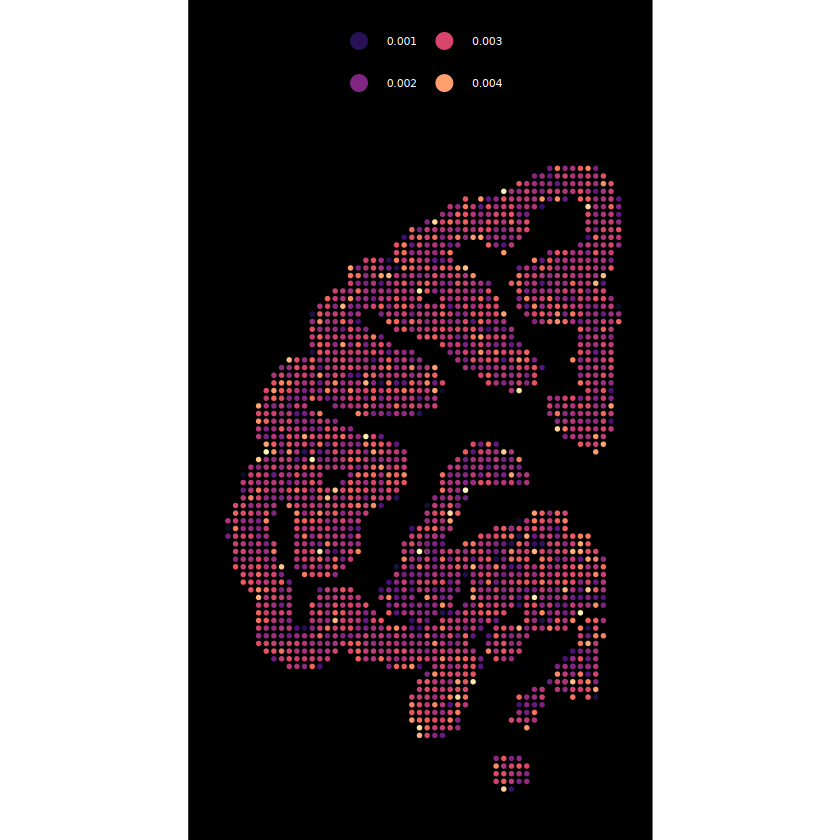

In [471]:
pmkpti = ggplot(editpst2.subcor[editpst2.subcor$readnumt > 1000 & editpst2.subcor$editpop < 0.005,],aes(x = x, y = y,color = editpop)) +
      geom_point(size = 0.5) +
      theme_void() + 
      scale_color_viridis(option = "A") +
      theme_presentation() + 
      theme(legend.position = "top",legend.title = element_blank(),
            legend.text = element_text(size = 6)) +
      guides(color = guide_legend(override.aes = list(size=4),
                                  nrow = 2),
            size = "none") +
      scale_y_reverse() + scale_x_reverse() +
        coord_fixed()
pmkpti
ggexport(pmkpti,filename =  "result/figure6_snp_analysis/RED_read_ratio_subcortical_compare_spatial_24_05_01.pdf",width = 4,height = 6)

In [119]:
library(ggplot2) # Create Elegant Data Visualisations Using the Grammar of Graphics
library(ggsignif) # Significance Brackets for 'ggplot2'
library(gghalves) # Compose Half-Half Plots Using Your Favourite Geoms

##绘图
#editpst.subcorp = editpst.subcor[editpst.subcor$editype == "total" & editpst.subcor$readnumt > 50,]
psubc2 = ggplot(editpst2.subcor[editpst2.subcor$readnumt > 1000,],aes(x = areatr, y = editpop, fill = areatr))+
  geom_jitter(aes(fill=areatr),shape=21,size=1,width=0.1) +
  geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
  geom_boxplot(width=0.4,size=0.5, outlier.color =NA) +
  stat_compare_means(label = "p.signif", method = "t.test",hide.ns = T,
                     ref.group = ".all.")  +
  theme_bw()+
  theme(panel.grid = element_blank(),
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 90,vjust = 0.5),
        axis.text.y = element_text(color = "black",size = 13),
        legend.position = "none",
        axis.ticks = element_line(color="black",linewidth = 1)) +
  scale_fill_flatui() + ylab("Log10 proportion of reads with A-to-I editing") + xlab("")

#psubc2 = ggplot(editpst.subcor[editpst.subcor$editype == "total",],
#                aes(x = subcortical, y = editpop, fill = subcortical)) + geom_boxplot(size = 0.1) + 
#theme_bw() +
#facet_wrap(editype~.,scales =  "free_y") + 
#theme(axis.text.x = element_text(angle = 90),panel.grid = element_blank(),strip.background = element_rect(fill = NA)) +
#scale_fill_flatui() + ylab("Ratio of reads with mismatch") + xlab("")
psubc2
ggexport(psubc2,filename =  "result/figure6_snp_analysis/RED_read_ratio_subcortical_compare_boxplot_24_04_11.pdf",width = 3,height = 3)

ERROR: Error in eval(expr, envir, enclos): object 'editpst2.subcor' not found


In [136]:
snpcountf$areatr = snpcountf$class
readan$areatr = readan$class
editpst2.class = StatSiteEditRate(snpcountf,readan)

`summarise()` has grouped output by 'areatr'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'areatr'. You can override using the
`.groups` argument.


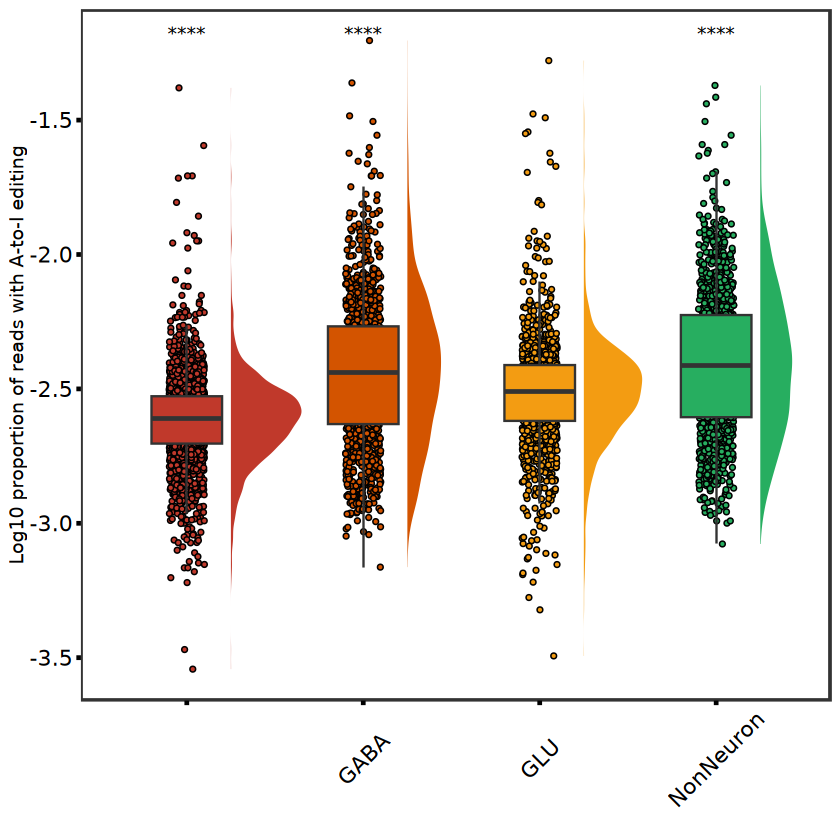

In [137]:
#editpst.subcorp = editpst.subcor[editpst.subcor$editype == "total" & editpst.subcor$readnumt > 50,]
plc2 = ggplot(editpst2.class,aes(x = areatr, y = log10(editpop), fill = areatr))+
  geom_jitter(aes(fill=areatr),shape=21,size=1,width=0.1) +
  geom_half_violin(position = position_nudge(x=0.25),side = "r",width=0.8,color=NA)+
  geom_boxplot(width=0.4,size=0.5, outlier.color =NA) +
  stat_compare_means(label = "p.signif", method = "t.test",hide.ns = T,
                     ref.group = ".all.")  +
  theme_bw()+
  theme(panel.grid = element_blank(),
        panel.border = element_rect(size = 1),
        axis.text.x = element_text(color = "black", size = 13,angle = 45,vjust = 0.5),
        axis.text.y = element_text(color = "black",size = 13),
        legend.position = "none",
        axis.ticks = element_line(color="black",linewidth = 1)) +
  scale_fill_flatui() + ylab("Log10 proportion of reads with A-to-I editing") + xlab("")

plc2

#### Cal Diff RNA editing Case

In [68]:
#layer level
DiffVafcal = function(snpcountf,coveread){
    editst.gene = snpcountf %>% group_by(pos,areatr,chunk,gene_id) %>% summarise(readnum = length(unique(readid)))
    covereadst = coveread %>% group_by(pos,areatr,chunk) %>% summarise(readnumt = sum(readnum))
    editst.gene = merge(editst.gene,covereadst,by = c("areatr","chunk","pos"))
    editst.gene$editpop = editst.gene$readnum/editst.gene$readnumt
    
    editst.gene = editst.gene[editst.gene$readnumt > 5,]
    editst.gene = editst.gene %>% group_by(pos,gene_id) %>% filter(length(unique(areatr)) > 1)

    editst.gene$pvalue = 1
    editst.gene = editst.gene %>%
      group_by(pos,gene_id) %>%
      mutate(pvalue = anova(lm(editpop ~ areatr))$`Pr(>F)`[1])
    editst.gene.st = editst.gene %>%
      group_by(pos,gene_id,areatr) %>%
      summarise(pvalue = pvalue[1],readnum = sum(readnum),readnumt = sum(readnumt),mep = readnum/readnumt)
    editst.gene.st = editst.gene.st %>%
      group_by(pos,gene_id) %>%
      mutate(mept = sum(readnum)/sum(readnumt))
    
    editst.gene.st$padj = p.adjust(editst.gene.st$pvalue,method = "BH")
    editst.gene.st$dr = editst.gene.st$mep - editst.gene.st$mept
    editst.gene.st[is.na(editst.gene.st$padj),]$padj = 1

    return(editst.gene.st)
}
#layer
snpcountf$areatr = snpcountf$subcortical
snpcountf$chunk = snpcountf$area
coveread$areatr = coveread$subcortical
coveread$chunk = coveread$area
dvafst.subc = DiffVafcal(snpcountf, coveread)
head(dvafst.subc)

`summarise()` has grouped output by 'pos', 'areatr', 'chunk'. You can override
using the `.groups` argument.


ERROR: [1m[33mError[39m in `group_by()`:[22m
[1m[22m[33m![39m Must group by variables found in `.data`.
[31m✖[39m Column `pos` is not found.


In [71]:
DiffVafGeneCal = function(snpcountf,readan){
    editst.gene = snpcountf %>% group_by(areatr,chunk,gene_id) %>% summarise(readnum = length(unique(readid)))
    readanst = readan %>% group_by(gene_id,areatr,chunk) %>% summarise(readnumt = length(unique(readid)))
    editst.gene = merge(editst.gene,readanst,by = c("areatr","chunk","gene_id"),all = T)
    editst.gene[is.na(editst.gene$readnum),]$readnum = 0
    editst.gene$editpop = editst.gene$readnum/editst.gene$readnumt
    
    editst.gene = editst.gene[editst.gene$readnumt > 5,]
    editst.gene = editst.gene %>% group_by(gene_id) %>% filter(length(unique(areatr)) > 1)

    editst.gene$pvalue = 1
    editst.gene = editst.gene %>%
      group_by(gene_id) %>%
      mutate(pvalue = anova(lm(editpop ~ areatr))$`Pr(>F)`[1])
    editst.gene.st = editst.gene %>%
      group_by(gene_id,areatr) %>%
      summarise(pvalue = pvalue[1],readnum = sum(readnum),readnumt = sum(readnumt),mep = readnum/readnumt)
    editst.gene.st = editst.gene.st %>%
      group_by(gene_id) %>%
      mutate(mept = sum(readnum)/sum(readnumt))
    
    editst.gene.st$padj = p.adjust(editst.gene.st$pvalue,method = "BH")
    editst.gene.st$dr = editst.gene.st$mep - editst.gene.st$mept
    editst.gene.st[is.na(editst.gene.st$padj),]$padj = 1

    return(editst.gene.st)
}
#layer
snpcountf$areatr = snpcountf$subcortical
snpcountf$chunk = snpcountf$area
readan$areatr = readan$subcortical
readan$chunk = readan$area
dvafst.subcg = DiffVafGeneCal(snpcountf, readan)
head(dvafst.subc)

`summarise()` has grouped output by 'areatr', 'chunk'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'gene_id', 'areatr'. You can override using
the `.groups` argument.
Warning message:
"There were 163 warnings in `mutate()`.
The first warning was:
ℹ In argument: `pvalue = anova(lm(editpop ~ areatr))$`Pr(>F)`[1]`.
ℹ In group 19: `gene_id = "ABCA2"`.
Caused by warning in `anova.lm()`:
! ANOVA F-tests on an essentially perfect fit are unreliable
ℹ Run `dplyr::last_dplyr_warnings()` to see the 162 remaining warnings."
`summarise()` has grouped output by 'gene_id'. You can override using the
`.groups` argument.


ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 'head': object 'dvafst.subc' not found


In [75]:
dvafst.subcg.hub = dvafst.subcg[abs(dvafst.subcg$dr) > 0.05 & dvafst.subcg$readnumt > 50,]
nrow(dvafst.subcg.hub)
dvafst.subcg.hub

[1] 66

gene_id        areatr      pvalue       readnum readnumt mep       
1  ABCG2          Cortex      4.241466e-01 11       60      0.18333333
2  ACSL6          Hippocampus 3.036586e-02 11       69      0.15942029
3  ARL6IP4        Pons        2.353005e-04 17      161      0.10559006
4  ASRGL1         cerebellum  9.869436e-02  2       62      0.03225806
5  ATP5S          cerebellum  6.828465e-01 26       67      0.38805970
6  BambuGene11813 Ventricle   4.913202e-01  4       68      0.05882353
7  BambuGene55408 cerebellum  1.955810e-01  6       52      0.11538462
8  BambuGene5703  Midbrain    5.944440e-01  9       79      0.11392405
9  BambuGene96170 Midbrain    3.806191e-01 22      122      0.18032787
10 BambuGene96170 cerebellum  3.806191e-01 22      106      0.20754717
11 C11H12orf49    cerebellum  9.047874e-01  7       58      0.12068966
12 CALCOCO2       Midbrain    6.067471e-02  3       54      0.05555556
13 CCDC173        Ventricle   1.639316e-01 18       53      0.33962264
14 CDH22          cerebellum  2.717031e-02 38      112      0.33928571
15 CEP70          cerebellum  7.986509e-02  7       51      0.13725490
16 CHP1           Pons        1.199251e-06  6       72      0.08333333
17 CLCC1          cerebellum  1.593204e-01 22      101      0.21782178
18 CMC2           Midbrain    2.337808e-01  1       51      0.01960784
19 DNM1L          Midbrain    7.064659e-03 12      110      0.10909091
20 DOPEY2         cerebellum  4.119553e-01 15       64      0.23437500
21 DUT            cerebellum  6.032776e-01 14       81      0.17283951
22 FAM20B         Midbrain    6.648391e-01  5       60      0.08333333
23 FAM213A        Ventricle   6.921866e-01  7       74      0.09459459
24 FTO            Hippocampus 8.688972e-02  4       70      0.05714286
25 FTO            Ventricle   8.688972e-02  4       69      0.05797101
26 GTF2F1         Midbrain    2.718869e-01  8       57      0.14035088
27 IDS            Pons        4.279956e-05 21      166      0.12650602
28 KIF5A          Pons        1.018280e-11 10      128      0.07812500
29 KPNA6          Midbrain    5.966773e-01  5       66      0.07575758
30 LOC101865285   Pons        6.378663e-01 18       84      0.21428571
⋮  ⋮              ⋮           ⋮            ⋮       ⋮        ⋮         
37 MCAM           Pons        0.001870053  12       56      0.21428571
38 NABP2          cerebellum  0.472178718  17       94      0.18085106
39 NGEF           Hippocampus 0.057350572  12       74      0.16216216
40 NGEF           Striatum    0.057350572  39      224      0.17410714
41 NMT2           cerebellum  0.085374299   4       53      0.07547170
42 P3H4           cerebellum  0.023980019  16       51      0.31372549
43 PECR           Ventricle   0.678675161   4       78      0.05128205
44 POLR1E         cerebellum  0.050054577  30       66      0.45454545
45 PPP2R2B        cerebellum  0.044841995   7       85      0.08235294
46 PQLC3          Cortex      0.732999128  26       72      0.36111111
47 PRRT3          Midbrain    0.017899958  10       68      0.14705882
48 RDH11          cerebellum  0.020349079   8       67      0.11940299
49 RNF157         cerebellum  0.484776013  13       74      0.17567568
50 RPL7L1         cerebellum  0.381208715  30       98      0.30612245
51 RPS15A         Hippocampus 0.028005770   9       86      0.10465116
52 SIK3           Striatum    0.100650034   5       70      0.07142857
53 SIRT2          Ventricle   0.223004138   6       53      0.11320755
54 SLC12A6        Midbrain    0.022324540  16       54      0.29629630
55 SLC17A5        Midbrain    0.095803298  29       75      0.38666667
56 SLC17A5        cerebellum  0.095803298  34       75      0.45333333
57 SMIM14         cerebellum  0.167870153   8       62      0.12903226
58 SNRPD3         Midbrain    0.039219255  31      137      0.22627737
59 SNRPD3         Ventricle   0.039219255   7       71      0.09859155
60 TGOLN2         Hippocampus 0.101525838   3       74      0.04054054
61 TGOLN2         Ventricle

< table of extent 0 >

subcortical readnum
1 Cortex      1097   
2 Hippocampus   14   
3 Midbrain      15   
4 Pons           1   
5 Striatum      39   
6 Ventricle      4   
7 cerebellum     6

subcortical readnum readnumt ratio    
1 cerebellum     6      25     0.2400000
2 Cortex      1097    4268     0.2570291
3 Hippocampus   14      83     0.1686747
4 Midbrain      15      50     0.3000000
5 Pons           1       3     0.3333333
6 Striatum      39     224     0.1741071
7 Ventricle      4      18     0.2222222

file saved to result/figure6_snp_analysis/mismatch_gene_case_NGEF_subcortical_bar_24_05_17.pdf



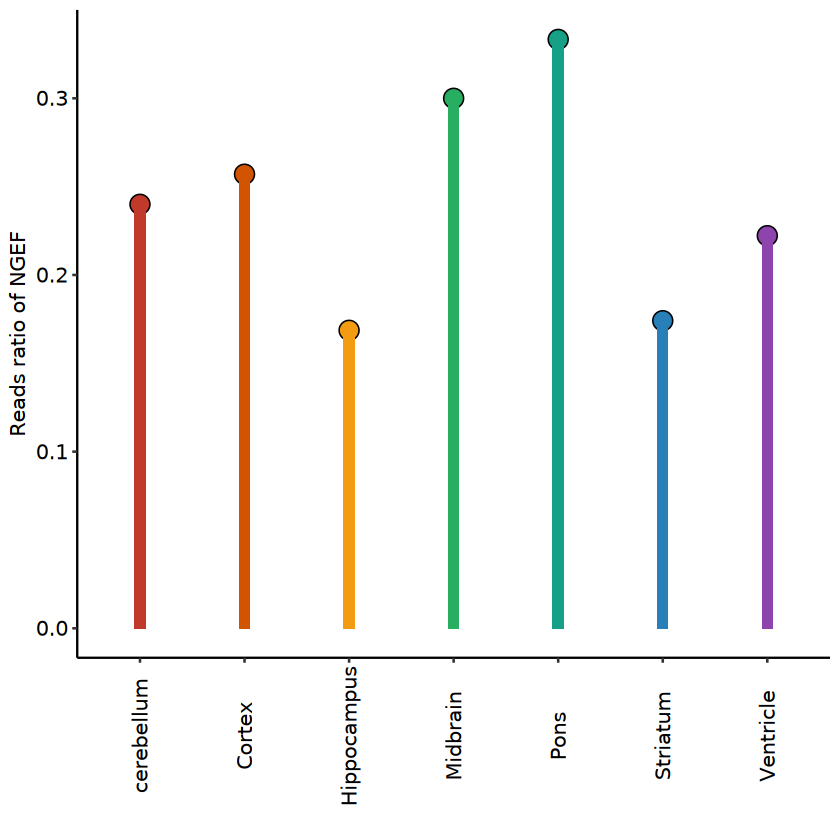

In [79]:
#plot case
geneex = "NGEF"
snpcountf.case = snpcountf[snpcountf$gene_id == geneex & !is.na(snpcountf$readid),]
table(snpcountf.case$mispos)
snpcountf.case.st = snpcountf.case %>% group_by(subcortical) %>% summarise(readnum = length(unique(readid)))
snpcountf.case = snpcountf.case[,c("readid","x","y")]
snpcountf.case.st

#snpcountf.case
ref.case = readan[readan$gene_id == geneex,]
ref.case.st = ref.case %>% group_by(subcortical) %>% summarise(readnumt = length(unique(readid)))
snpcountf.case.st = merge(snpcountf.case.st,ref.case.st,by = "subcortical")
snpcountf.case.st$ratio = snpcountf.case.st$readnum/snpcountf.case.st$readnumt
snpcountf.case.st

pcasebar = ggplot(snpcountf.case.st,aes(x = subcortical,y = ratio,fill = subcortical)) + 
geom_point(shape = 21,size = 5) + 
geom_bar(stat = "identity",width = 0.1) + 
theme_pubr() + 
theme(axis.text.x = element_text(angle = 90,vjust = 0.5),legend.position = "none") +
scale_fill_flatui() + xlab("") + ylab("Reads ratio of NGEF")
pcasebar

snpcountf.case$group = "mismatch"
ref.case = ref.case[!ref.case$readid %in% snpcountf.case$readid,c("readid","x","y")]
ref.case$group = "nomismatch"
snpcountf.case = rbind(snpcountf.case,ref.case)
ggexport(pcasebar,filename = "result/figure6_snp_analysis/mismatch_gene_case_NGEF_subcortical_bar_24_05_17.pdf",width = 4, height = 4)

file saved to result/figure6_snp_analysis/mismatch_gene_case_NGEF_subcortical_spatial_24_05_17.pdf



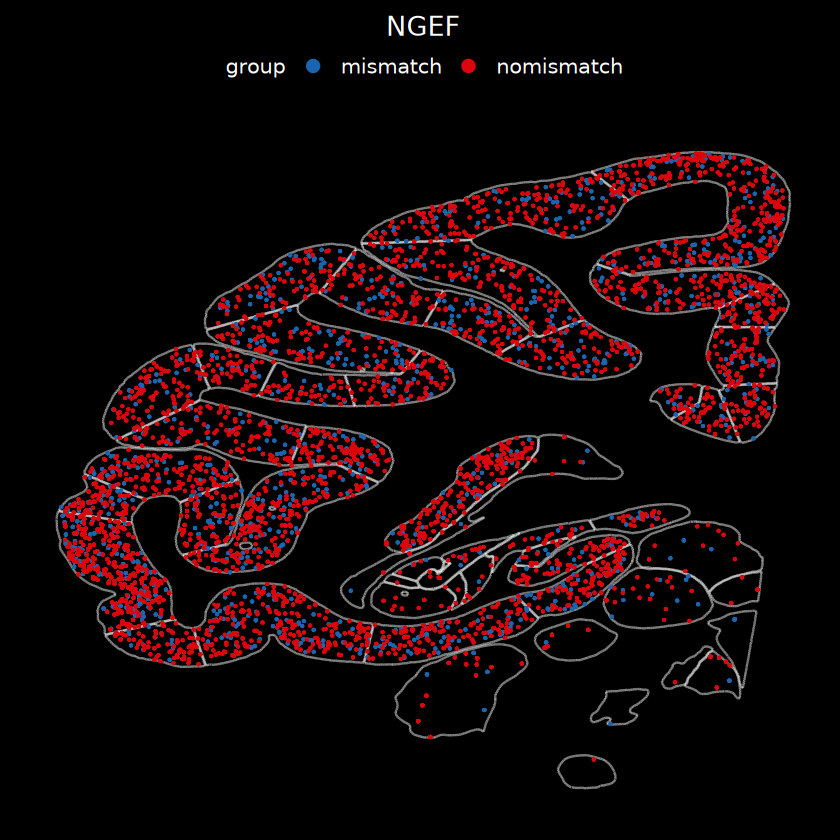

In [80]:
myrange = qread("../ref/area_figure_an.qs")
areaedges = myrange$areaedges
areaedges = areaedges[areaedges$areaid != "IG",]
pcasesp = ggplot() +
      geom_segment(data = areaedges, aes(x = x1, y = y1, xend = x2, yend = y2),
                 size = 0.5,color = "white",alpha = 0.5) + 
      geom_point(data = snpcountf.case,aes(x,y,color = group),
                 size = 0.1) +
      theme_void() + 
      scale_color_discreterainbow() +
      theme_presentation() +
      guides(color = guide_legend(override.aes = list(size=3))) +
      scale_y_reverse() + scale_x_reverse() + ggtitle(geneex)  +
      theme(legend.position = "top")
pcasesp
ggexport(pcasesp,filename = "result/figure6_snp_analysis/mismatch_gene_case_NGEF_subcortical_spatial_24_05_17.pdf",width = 4, height = 6)

In [83]:
BiocManager::install("Gviz")
library(Gviz)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.22), R 4.3.1 (2023-06-16)

Installing package(s) 'Gviz'

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Old packages: 'AnnotationHub', 'ape', 'arrow', 'bambu', 'BiocFileCache',
  'BiocManager', 'BiocVersion', 'biomaRt', 'boot', 'brio', 'broom.helpers',
  'BSgenome', 'bslib', 'cachem', 'callr', 'cluster', 'codetools', 'crul',
  'curl', 'data.table', 'DBI', 'dbplyr', 'DESeq2', 'digest', 'diptest',
  'dqrng', 'DT', 'e1071', 'edgeR', 'estimability', 'farver', 'fastmap',
  'filelock', 'foreign', 'fpc', 'fs', 'future', 'future.apply',
  'GenomicFeatures', 'ggh4x', 'ggplot2', 'ggsci', 'ggstats', 'gh', 'globals',
  'gtable', 'hardhat', 'haven', 'hdf5r', 'htmltools', 'httpuv', 'httr2',
  'igraph', 'interp', 'KernSmooth', 'knit

In [86]:
gtf[gtf$gene_id == "NGEF",]
min(start(gtf[gtf$gene_id == "NGEF",]))
max(end(gtf[gtf$gene_id == "NGEF",]))

GRanges object with 60 ranges and 8 metadata columns:
          seqnames              ranges strand |   source       type     score
             <Rle>           <IRanges>  <Rle> | <factor>   <factor> <numeric>
   [1] NC_022283.1 122719674-122768427      - |    Bambu transcript        NA
   [2] NC_022283.1 122719674-122768565      - |    Bambu transcript        NA
   [3] NC_022283.1 122719674-122822782      - |    Bambu transcript        NA
   [4] NC_022283.1 122719674-122854824      - |    Bambu transcript        NA
   [5] NC_022283.1 122719674-122720647      - |    Bambu exon              NA
   ...         ...                 ...    ... .      ...        ...       ...
  [56] NC_022283.1 122812316-122812430      - |    Bambu       exon        NA
  [57] NC_022283.1 122816932-122817282      - |    Bambu       exon        NA
  [58] NC_022283.1 122816932-122817282      - |    Bambu       exon        NA
  [59] NC_022283.1 122822768-122822782      - |    Bambu       exon        NA
  [60] NC_

[1] 122719674

[1] 122854824

In [95]:
#change bam chr name
renameref = read.delim("/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/pacbio_revio_process/sequence_report.tsv")
head(renameref)

Assembly.Accession Assembly.Unplaced.Count Assembly.unit.accession
1 GCF_000364345.1    NA                      Primary Assembly       
2 GCF_000364345.1    NA                      Primary Assembly       
3 GCF_000364345.1    NA                      Primary Assembly       
4 GCF_000364345.1    NA                      Primary Assembly       
5 GCF_000364345.1    NA                      Primary Assembly       
6 GCF_000364345.1    NA                      Primary Assembly       
  Chromosome.name GC.Count GC.Percent GenBank.seq.accession Molecule.type
1 1               90728469 41.5       CM001919.1            Chromosome   
2 2               73730174 39.5       CM001920.1            Chromosome   
3 3               73277329 40.5       CM001921.1            Chromosome   
4 4               65267946 39.5       CM001922.1            Chromosome   
5 5               70033605 38.0       CM001923.1            Chromosome   
6 6               69230951 39.5       CM001924.1            Chromosome   
  Ordering RefSeq.seq.accession Role               Seq.length UCSC.style.name
1 NA       NC_022272.1          assembled-molecule 227556264  chr1           
2 NA       NC_022273.1          assembled-molecule 192460366  chr2           
3 NA       NC_022274.1          assembled-molecule 192294377  chr3           
4 NA       NC_022275.1          assembled-molecule 170955103  chr4           
5 NA       NC_022276.1          assembled-molecule 189454096  chr5           
6 NA       NC_022277.1          assembled-molecule 181584905  chr6           
  Unlocalized.Count
1 28               
2 20               
3 41               
4 69               
5 22               
6 15

In [97]:
renameref = unique(renameref[,c("RefSeq.seq.accession","UCSC.style.name")])
renameref$UCSC.style.name = gsub(" ","_",renameref$UCSC.style.name)
write.table(renameref,file = "/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/pacbio_revio_process/sequence_report_ref.tsv",sep = "\t",
           row.names = F,quote = F, col.names = F)

In [100]:
alTrack <- AlignmentsTrack("/cluster/home/liuhengxin/P1_brain_nanopore/processed_data/pacbio_revio_process/pacbio_Mas_processdata_merged_minimap_sorted_rename_sorted_24_03_21.bam")

In [101]:
alTrack

ReferenceAlignmentsTrack 'AlignmentsTrack'
| genome: NA
| active chromosome: chrNA
| referenced file: /cluster/home/liuhengxin/P1_brain_nanopore/processed_data/pacbio_revio_process/pacbio_Mas_processdata_merged_minimap_sorted_rename_sorted_24_03_21.bam

| mapping: id=id, cigar=cigar, mapq=mapq, flag=flag, isize=isize, groupid=groupid, status=status, md=md, seq=seq




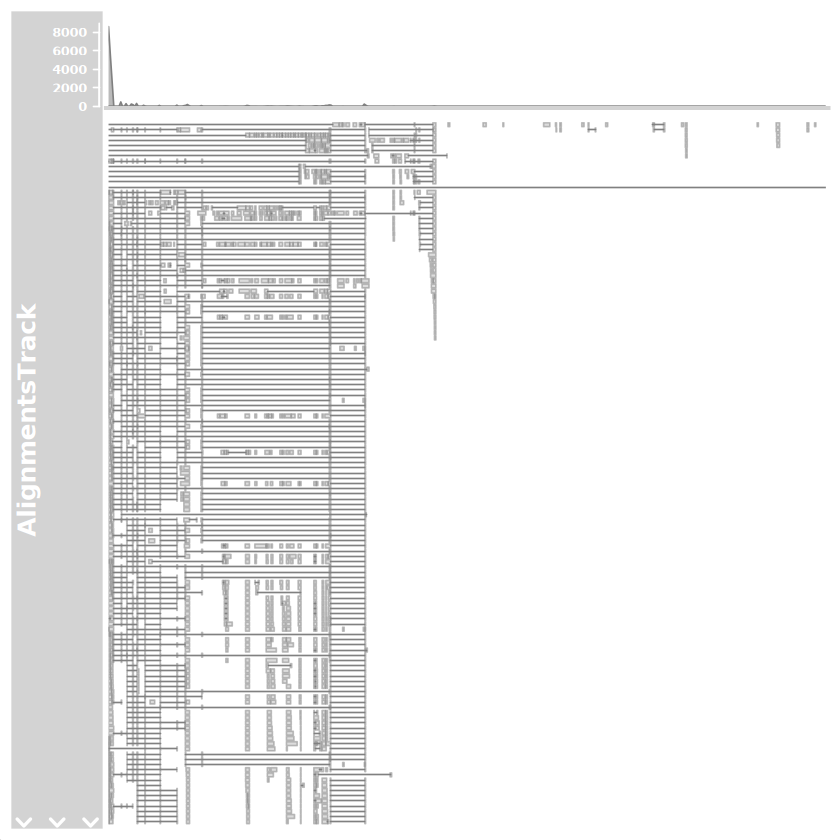

In [103]:
plotTracks(c(alTrack), chromosome = "chr12", from = 122719674, 
           to = 122854824, cex = 0.5, min.height = 3)

#### Summary data

In [ ]:
library(writexl)
write_xlsx(datas5,"result/figure5/table_s5_shift_isoform.xlsx")

### ARPP19 diger

In [7]:
transti = transtls$subcortical
head(transti)

gene_id transcript_id  areatr      count genecount
1 A1BG    XM_015441069.1 Cortex       1     1       
2 A2ML1   XM_005570054.2 Cortex      11    15       
3 A2ML1   XM_005570054.2 Hippocampus  1     1       
4 A2ML1   XM_005570054.2 Midbrain     2     2       
5 A2ML1   XM_015430339.1 Cortex       4    15       
6 A3GALT2 XM_005544050.2 Cerebellum   2     2

In [8]:
transti.st = transti %>% group_by(areatr) %>% summarise(tcount = sum(count))
head(transti.st)

areatr      tcount  
1 Cerebellum   4260997
2 Cortex      61836381
3 Hippocampus  2783850
4 Midbrain     3142746
5 Pons         1079095
6 Striatum     1575965

In [10]:
isosigi.hub = isosigi[isosigi$gene_id == "ARPP19",]
isosigi.hub = merge(isosigi.hub,transti.st,by = "areatr")
isosigi.hub$norm = isosigi.hub$count/isosigi.hub$tcount*100
isosigi.hub[isosigi.hub$areatr %in% c("Striatum","Cortex"),]

areatr   gene_id transcript_id  count genecount relative   meanrelative
4  Cortex   ARPP19  NM_001283415.1 14700 33439     0.43960645 0.19130869  
5  Cortex   ARPP19  XM_015452431.1  1667 33439     0.04985197 0.09150784  
6  Cortex   ARPP19  XM_015452432.1 17041 33439     0.50961452 0.71293551  
16 Striatum ARPP19  NM_001283415.1   918  2447     0.37515325 0.19130869  
17 Striatum ARPP19  XM_015452431.1    52  2447     0.02125051 0.09150784  
18 Striatum ARPP19  XM_015452432.1  1476  2447     0.60318758 0.71293551  
   otherrelative dr          sig  pvalue        padj          tcount  
4  0.14992573     0.28968072 Up   1.219322e-209 3.591773e-207 61836381
5  0.09845049    -0.04859852 N    1.219322e-209 3.591773e-207 61836381
6  0.74682235    -0.23720782 Down 1.219322e-209 3.591773e-207 61836381
16 0.16066793     0.21448532 Up   1.219322e-209 3.591773e-207  1575965
17 0.10321740    -0.08196689 N    1.219322e-209 3.591773e-207  1575965
18 0.73122684    -0.12803926 Down 1.219322e-209 3.591773e-207  1575965
   norm       
4  0.023772413
5  0.002695824
6  0.027558210
16 0.058250025
17 0.003299566
18 0.093656902